# PROJECT 1

## INTRODUCTION  
### Project context and data source decision

This project aims to identify and classify player roles in professional football using performance metrics and unsupervised machine learning. The primary objective is to develop a clustering model that groups players based on their actual match behavior , derived from statistical output rather than relying on generic or predefined position labels.

At the start, I considered scraping player data from FBref using `pandas.read_html()`. However, FBref's recent switch to JavaScript-rendered content made this method unreliable and time-consuming. To avoid technical complications and align with industry-standard workflows, I transitioned to a more scalable and stable solution: structured data access through the API-Football platform.

To ensure full access to detailed player statistics across multiple leagues and seasons, I upgraded to a paid plan, which allowed me to download complete performance data. To supplement the API's limitations , particularly for metrics like pass accuracy by range , I also used manually exported data from FBref. This hybrid approach resulted in a more complete dataset for role analysis.

For this project, I will focus on the 2023/24 season, analyzing players from three leagues:
- La Liga (Spain)
- Ligue 1 (France)  
- Serie A (Italy)

These competitions offer a variety of tactical systems, development environments, and stylistic diversity , supporting the project's aim of discovering role profiles across contexts. For each league, the analysis begins with midfielders, followed by center and forwards. Only players who played at least 540 minutes (6 full games) will be retained, ensuring a statistically meaningful sample.

Each dataset will be filtered and processed to extract relevant tactical features , including duels, recoveries, passes, assists, dribbles, and defensive contributions. Features will be normalized per 90 minutes and then scaled prior to clustering. Player groups will be identified using algorithms such as KMeans, with each cluster labeled based on its statistical profile — for example, "box-to-box midfielder", "ball-winning 6", or "deep distributor".

The final result will be a clean, labeled dataset of tactical roles that can be used for scouting, tactical analysis, or football app development. This project will also provide the foundation for an interactive app that allows users to explore and compare players based on how they actually play , not just by position.

---

### Personal motivation and professional goals

This project reflects my strong interest in tactical analysis, player profiling, and football scouting. With a background in sports therapy and over a decade of experience in healthcare, I bring a perspective that connects physical performance with data interpretation.

During this master's program, I developed core skills in Python, data analysis, and football-specific metrics. This project is where I put those skills into practice, creating an end-to-end analytical pipeline that mirrors real-world scouting and tactical evaluation.

My ultimate goal is to build an app that delivers clean, role-based player profiles using unsupervised models. This platform could assist scouts, analysts, or coaches who want quick, objective insights into how players behave on the pitch. Future versions could also include advanced modules like pose detection or set-piece breakdowns.

The app will not only showcase my analytical skills and football understanding but also serve as a portfolio piece to support my transition into a remote data analyst or scouting-focused role.


#1.DATA EXPORTATION

1.1 Data exportation - La Liga Midfielders

In [ ]:
import requests
import pandas as pd
import time
import numpy as np # Import numpy for robust percentage calculations

# API key - Replace with your actual API key
api_key = 'ba53d657e0973b0ae6f5a6b0be2f88d1'

# Request headers
headers = {
    'x-apisports-key': api_key
}

# La Liga ID and season
league_id = 140 # La Liga
season = 2023
page = 1
all_players = []

print("Starting API data collection for La Liga Midfielders (2023/2024 season)...")

# Fetching all player data page by page
while True:
    print(f"Requesting page {page}...")
    params = {
        'league': league_id,
        'season': season,
        'page': page
    }
    response = requests.get('https://v3.football.api-sports.io/players', headers=headers, params=params)
    data = response.json()

    # Check for errors in API response
    if data['errors']:
        print(f"❌ API Error on page {page}: {data['errors']}")
        break
    if not data['response']:
        break # No more players to fetch

    for player_entry in data['response']:
        player_info = player_entry['player']
        stats = player_entry['statistics'][0] # Get the first (and usually only) set of stats for the league/season

        # Extract relevant metrics for midfielders
        # Using .get() with default values (0 or None) to handle cases where a stat might be missing
        merged_stats = {
            'name': player_info['name'],
            'team': stats['team']['name'],
            'position': stats['games']['position'],
            'minutes': stats['games']['minutes'],

            # Duels (API provides total and won)
            'duels_total': stats.get('duels', {}).get('total', 0),
            'duels_won': stats.get('duels', {}).get('won', 0),

            # Goals scored
            'goals': stats.get('goals', {}).get('total', 0),

            # Shots
            'shots_total': stats.get('shots', {}).get('total', 0),
            'shots_on_target': stats.get('shots', {}).get('on_target', 0),

            # Assists
            'assists': stats.get('goals', {}).get('assists', 0),

            # Dribbles
            'dribbles_attempts': stats.get('dribbles', {}).get('attempts', 0),
            'dribbles_success': stats.get('dribbles', {}).get('success', 0),

            # Touches
            'touches_total': stats.get('touches', {}).get('total', 0),

            # Key passes
            'passes_key': stats.get('passes', {}).get('key', 0),

            # Passes (API provides total and accuracy)
            'passes_total': stats.get('passes', {}).get('total', 0),
            'passes_accuracy': stats.get('passes', {}).get('accuracy', 0),

            # Tackles and Interceptions (API provides total for each)
            'tackles': stats.get('tackles', {}).get('total', 0),
            'interceptions': stats.get('tackles', {}).get('interceptions', 0),
        }
        all_players.append(merged_stats)
    page += 1
    time.sleep(1) # Pause for 1 second to respect API rate limits

# Convert the collected data to a Pandas DataFrame
df = pd.DataFrame(all_players)

# Filter for 'Midfielder' position and players with at least 540 minutes played.
# The 540 minutes threshold ensures we have a sufficient sample size for per-90 metrics.
# 'Midfielder' is the common position string in API-Sports for midfielders.
midfielders_df = df[(df['position'] == 'Midfielder') & (df['minutes'] >= 540)].copy()

# Calculate derived metrics using numpy.where for robust division by zero handling
# Shots on target percentage
midfielders_df['shots_on_target_perc'] = np.where(
    midfielders_df['shots_total'].fillna(0) != 0,
    (midfielders_df['shots_on_target'].fillna(0) / midfielders_df['shots_total'].fillna(0)) * 100,
    0.0
)

# Dribble success percentage
midfielders_df['dribbles_success_perc'] = np.where(
    midfielders_df['dribbles_attempts'].fillna(0) != 0,
    (midfielders_df['dribbles_success'].fillna(0) / midfielders_df['dribbles_attempts'].fillna(0)) * 100,
    0.0
)

# Save the filtered and processed DataFrame to a CSV file
output_filename = "laliga_midfielders_2023_24_api_stats.csv"
midfielders_df.to_csv(output_filename, index=False)
print(f"\n✅ La Liga Midfielders API stats (filtered for >=540 mins) saved to: {output_filename}")

# Display the first few rows of the resulting DataFrame and its shape
print("\nFirst 5 rows of the exported Midfielders API stats:")
print(midfielders_df.head().to_string())
print(f"\nShape of the exported Midfielders API stats: {midfielders_df.shape}")


Starting API data collection for La Liga Midfielders (2023/2024 season)...
Requesting page 1...
Requesting page 2...
Requesting page 3...
Requesting page 4...
Requesting page 5...
Requesting page 6...
Requesting page 7...
Requesting page 8...
Requesting page 9...
Requesting page 10...
Requesting page 11...
Requesting page 12...
Requesting page 13...
Requesting page 14...
Requesting page 15...
Requesting page 16...
Requesting page 17...
Requesting page 18...
Requesting page 19...
Requesting page 20...
Requesting page 21...
Requesting page 22...
Requesting page 23...
Requesting page 24...
Requesting page 25...
Requesting page 26...
Requesting page 27...
Requesting page 28...
Requesting page 29...
Requesting page 30...
Requesting page 31...
Requesting page 32...
Requesting page 33...
Requesting page 34...
Requesting page 35...
Requesting page 36...
Requesting page 37...
Requesting page 38...
Requesting page 39...
Requesting page 40...
Requesting page 41...
Requesting page 42...
Requesting

In [ ]:
import pandas as pd

# Load the API-exported midfielders stats.
# This file is expected to already contain only midfielders with >= 540 minutes.
try:
    df_api_midfielders = pd.read_csv("laliga_midfielders_2023_24_api_stats.csv")
    print("✅ La Liga Midfielders API stats loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_api_stats.csv' not found.")
    print("Please ensure this file has been generated by the 'La Liga Midfielders API Data Export' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Filter for 'Midfielder' position and players with 540 minutes or more.
# Although the input file should already be filtered, this step re-confirms it.
midfielders_filtered = df_api_midfielders[
    (df_api_midfielders['position'] == 'Midfielder') &
    (df_api_midfielders['minutes'] >= 540)
].copy()

# Showing how many players were found
print(f"\n✅ Midfielders with 540 minutes or more found (re-confirmed): {len(midfielders_filtered)}")

# Printing the available columns in the filtered dataset
print("\nAvailable columns for filtered midfielders:")
print(midfielders_filtered.columns.tolist())

# Save the filtered dataset to a new CSV file
output_filename = "laliga_midfielders_2023_24_filtered.csv"
midfielders_filtered.to_csv(output_filename, index=False)
print(f"\n✅ Filtered midfielders dataset saved as: {output_filename}")

# Display the first few rows of the filtered dataset
print("\nFirst 5 rows of the filtered midfielders dataset:")
print(midfielders_filtered.head().to_string())


✅ La Liga Midfielders API stats loaded successfully.

✅ Midfielders with 540 minutes or more found (re-confirmed): 129

Available columns for filtered midfielders:
['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'goals', 'shots_total', 'shots_on_target', 'assists', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_key', 'passes_total', 'passes_accuracy', 'tackles', 'interceptions', 'shots_on_target_perc', 'dribbles_success_perc']

✅ Filtered midfielders dataset saved as: laliga_midfielders_2023_24_filtered.csv

First 5 rows of the filtered midfielders dataset:
             name         team    position  minutes  duels_total  duels_won  goals  shots_total  shots_on_target  assists  dribbles_attempts  dribbles_success  touches_total  passes_key  passes_total  passes_accuracy  tackles  interceptions  shots_on_target_perc  dribbles_success_perc
0        T. Kroos  Real Madrid  Midfielder   2129.0        168.0      104.0    1.0         25.0                

I am enhancing the La Liga 2023/24 midfielder dataset by adding accurate passing accuracy values and defensive actions from FBref as they were missing from the previous dataset(API).

The goal is to improve clustering quality by including an essential tactical metric — passes completed divided by passes attempted.

To make this work, I must:

    Load the 3 datasets (the API data and FBref passing data and defensive actions)

    Ensure player and team names are aligned

    Merge them carefully

    Update our dataset with the accurate passes_accuracy values

    Save the cleaned and enriched version for clustering



In [ ]:
%pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import unidecode

# Step 1: Load the three datasets for midfielders
# Ensure these CSV files are in the same directory as your script
try:
    api_df = pd.read_csv("laliga_midfielders_2023_24_api_stats.csv") # Adjusted for midfielders API data
    passing_df = pd.read_csv("La_Liga_players_passing.csv", encoding='ISO-8859-1', sep=None, engine='python')
    defensive_df = pd.read_csv("Fbref_La_Liga_defensive_actions.csv", encoding='ISO-8859-1', sep=None, engine='python')
    print("✅ All datasets loaded successfully for midfielders.")
except FileNotFoundError as e:
    print(f"❌ Error loading file: {e}. Make sure all CSV files are in the correct directory.")
    # Exit or handle the error appropriately if files are missing
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Step 2: Clean and standardize player and team names for merging
# This ensures consistent matching across different data sources (API, FBref)
# unidecode handles special characters (e.g., accents), .lower() for case insensitivity, .strip() for whitespace
api_df['name_clean'] = api_df['name'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
api_df['team_clean'] = api_df['team'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

passing_df['name_clean'] = passing_df['Player'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
passing_df['team_clean'] = passing_df['Squad'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

defensive_df['name_clean'] = defensive_df['Player'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
defensive_df['team_clean'] = defensive_df['Squad'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

print("✅ Player and team names cleaned and standardized for midfielders.")

# Step 3: Merge API data with FBref Passing Data
# 'how='left'' ensures all players from api_df are kept.
# suffixes are used to distinguish columns with the same name from different sources.
merged_df = pd.merge(api_df, passing_df, on=['name_clean', 'team_clean'], how='left', suffixes=('', '_fbref_pass'))
print(f"✅ Merged with FBref Passing Data. Total rows: {len(merged_df)}")

# Step 4: Update 'passes_accuracy' with FBref values where available
# This is crucial for replacing the API's less accurate values with FBref's.
# .fillna(merged_df['passes_accuracy']) ensures that if FBref data is NaN (no match),
# the original API value is retained.
merged_df['passes_accuracy'] = merged_df['Cmp%'].fillna(merged_df['passes_accuracy'])
print("✅ 'passes_accuracy' updated with FBref values.")

# Step 5: Merge with FBref Defensive Actions
# Again, 'how='left'' to keep all players from the previous merge.
# Suffixes are used for potential overlapping column names.
merged_final = pd.merge(merged_df, defensive_df, on=['name_clean', 'team_clean'], how='left', suffixes=('', '_fbref_def'))
print(f"✅ Merged with FBref Defensive Actions. Total rows: {len(merged_final)}")


# Step 6: Clean up redundant columns after merging and updating
# Drop the specific FBref columns that were used for updating or are redundant
# This list is adjusted to reflect common redundant columns from FBref for midfielders.
columns_to_drop = [
    'Player_fbref_pass', 'Squad_fbref_pass', 'Cmp%', # From passing_df
    'Player_fbref_def', 'Squad_fbref_def', # From defensive_df
    # Add any other columns from FBref that you don't need in the final combined dataset
    # e.g., 'Rk_fbref_pass', 'Age_fbref_pass', 'Born_fbref_pass', 'Matches_fbref_pass'
    # 'Rk_fbref_def', 'Age_fbref_def', 'Born_fbref_def', 'Matches_fbref_def'
]

# Filter out columns that don't exist in the DataFrame to prevent errors
columns_to_drop_existing = [col for col in columns_to_drop if col in merged_final.columns]
merged_final.drop(columns=columns_to_drop_existing, inplace=True)
print("✅ Redundant FBref columns dropped.")


# Step 7: Save the cleaned and enriched merged dataset
merged_final.to_csv("laliga_midfielders_2023_24_combined.csv", index=False) # Adjusted output filename
print("✅ Merged and cleaned dataset saved as: laliga_midfielders_2023_24_combined.csv") # Adjusted message

# Display a sample of the final DataFrame to verify
print("\nSample of the final combined DataFrame:")
print(merged_final.head())

# Checking for players who didn't merge
# This can help identify issues with name/team cleaning or missing data in FBref sources
unmatched_passing = merged_df[merged_df['Cmp%'].isna()]['name_clean'].unique()
if len(unmatched_passing) > 0:
    print(f"\n⚠️ Players without matching FBref Passing data (sample): {unmatched_passing[:5]}...")

unmatched_defensive = merged_final[merged_final['TklW'].isna()]['name_clean'].unique() # Assuming 'TklW' is a key defensive stat
if len(unmatched_defensive) > 0:
    print(f"\n⚠️ Players without matching FBref Defensive data (sample): {unmatched_defensive[:5]}...")


✅ All datasets loaded successfully for midfielders.
✅ Player and team names cleaned and standardized for midfielders.
✅ Merged with FBref Passing Data. Total rows: 129
✅ 'passes_accuracy' updated with FBref values.
✅ Merged with FBref Defensive Actions. Total rows: 129
✅ Redundant FBref columns dropped.
✅ Merged and cleaned dataset saved as: laliga_midfielders_2023_24_combined.csv

Sample of the final combined DataFrame:
             name         team    position  minutes  duels_total  duels_won  \
0        T. Kroos  Real Madrid  Midfielder   2129.0        168.0      104.0   
1       É. Capoue   Villarreal  Midfielder   1443.0        208.0      117.0   
2           Rodri   Real Betis  Midfielder   1038.0        140.0       70.0   
3  Jonathan Viera      Almeria  Midfielder    923.0         91.0       47.0   
4      I. Rakitić      Sevilla  Midfielder   1426.0        120.0       69.0   

   goals  shots_total  shots_on_target  assists  ...  Tkl%  Lost  Blocks   Sh  \
0    1.0         25

I am inspecting the missing values.

In [ ]:
import pandas as pd

# Load the combined dataset for midfielders
try:
    df_combined = pd.read_csv("laliga_midfielders_2023_24_combined.csv")
    print("✅ Combined midfielders dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_combined.csv' not found. Please ensure the file exists.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()


# Display columns and shape of the dataset
print("\nColumns in the combined midfielders dataset:")
print(df_combined.columns.tolist())
print("\nShape of the combined midfielders dataset:", df_combined.shape)

# Display the first few rows
print("\nFirst 5 rows of the combined midfielders dataset:")
print(df_combined.head().to_string())


# Check for missing values in each column
missing_values = df_combined.isnull().sum()
missing_percentages = (missing_values / len(df_combined)) * 100

missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentages
})

# Display columns with missing values, sorted by the number of missing values
print("\nMissing values summary for midfielders (columns with missing values only):")
print(missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False).to_string())


✅ Combined midfielders dataset loaded successfully.

Columns in the combined midfielders dataset:
['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'goals', 'shots_total', 'shots_on_target', 'assists', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_key', 'passes_total', 'passes_accuracy', 'tackles', 'interceptions', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP', '1-???', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk', 'Nation_fbref_def', 'Pos_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Att_fbref_def', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Matches_fbref_def']

Shape of the combined midfielders 

I am dropping the columns that I do not need.

In [ ]:
import pandas as pd

# Load the combined dataset for midfielders
# Ensure 'laliga_midfielders_2023_24_combined.csv' is in the same directory as your script
try:
    df_combined_midfielders = pd.read_csv("laliga_midfielders_2023_24_combined.csv")
    print("✅ Combined midfielders dataset loaded successfully for missing value handling.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_combined.csv' not found. Please ensure the file exists.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# --- Filter for players with >= 540 minutes ---
# Although the API export already filtered for >=540 minutes, it's good practice
# to ensure this filter is applied consistently here as well, especially if the
# combined CSV might contain players below this threshold from other sources.
initial_player_count = len(df_combined_midfielders)
df_combined_midfielders = df_combined_midfielders[df_combined_midfielders['minutes'] >= 540].copy()
print(f"✅ Filtered for players with >= 540 minutes. Reduced from {initial_player_count} to {len(df_combined_midfielders)} players.")
# --- END Filter ---


# Define columns to drop based on the missing values summary you observed (52.71% missing for many FBref columns)
# These are primarily FBref columns that did not find matches for a large portion of players.
columns_to_drop_high_missing = [
    'Pos', 'Unnamed: 0', 'Player', 'Squad', 'Age', 'Nation', 'TotDist', 'Att', 'Cmp', '90s', 'Born',
    'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.3', 'Att.3',
    'Ast', '1-???', 'KP', 'A-xAG', 'xA', 'xAG', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1',
    'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk', 'Nation_fbref_def', 'Pos_fbref_def', 'Age_fbref_def',
    'Born_fbref_def', '90s_fbref_def', 'Tkl', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int',
    'Att_fbref_def', 'Tkl%', 'Lost', 'Err', 'Clr', 'Matches_fbref_def'
]

# Drop the specified columns. 'errors='ignore'' prevents an error if a column is not found.
df_filtered_high_missing_dropped = df_combined_midfielders.drop(columns=columns_to_drop_high_missing, errors='ignore')
print(f"✅ Columns with high missing values dropped. New shape: {df_filtered_high_missing_dropped.shape}")


# Calculate missing values in the remaining columns after the first drop.
remaining_missing_after_drop = df_filtered_high_missing_dropped.isnull().sum()

# Identify columns that still have missing values (where count > 0)
# Based on your output: 'passes_accuracy', 'assists', 'passes_key', 'interceptions', 'dribbles_success'
columns_with_remaining_missing_after_drop = remaining_missing_after_drop[remaining_missing_after_drop > 0].index.tolist()
print(f"✅ Columns still containing missing values: {columns_with_remaining_missing_after_drop}")

# Drop rows with any remaining missing values in the identified columns.
# .copy() is used to prevent SettingWithCopyWarning.
df_cleaned_for_clustering = df_filtered_high_missing_dropped.dropna(subset=columns_with_remaining_missing_after_drop).copy()


print(f"\nOriginal number of players in combined dataset (before 540 min filter): {initial_player_count}")
print(f"Number of players remaining after filtering for >= 540 minutes and full cleaning: {len(df_cleaned_for_clustering)}")

# Display the first few rows of the resulting DataFrame
if not df_cleaned_for_clustering.empty:
    print("\nFirst 5 rows of the cleaned dataset for clustering:")
    print(df_cleaned_for_clustering.head().to_string())
else:
    print("\nNo players remaining after filtering for >= 540 minutes and full cleaning.")

# Display columns that are still present in the cleaned dataset
print("\nColumns remaining in the cleaned dataset:")
print(df_cleaned_for_clustering.columns.tolist())

# Save the cleaned DataFrame
output_filename = "laliga_midfielders_2023_24_cleaned_for_clustering.csv"
df_cleaned_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Cleaned dataset saved as: {output_filename}")


✅ Combined midfielders dataset loaded successfully for missing value handling.
✅ Filtered for players with >= 540 minutes. Reduced from 129 to 129 players.
✅ Columns with high missing values dropped. New shape: (129, 22)
✅ Columns still containing missing values: ['assists', 'dribbles_success', 'passes_key', 'passes_accuracy', 'interceptions']

Original number of players in combined dataset (before 540 min filter): 129
Number of players remaining after filtering for >= 540 minutes and full cleaning: 71

First 5 rows of the cleaned dataset for clustering:
             name         team    position  minutes  duels_total  duels_won  goals  shots_total  shots_on_target  assists  dribbles_attempts  dribbles_success  touches_total  passes_key  passes_total  passes_accuracy  tackles  interceptions  shots_on_target_perc  dribbles_success_perc      name_clean   team_clean
0        T. Kroos  Real Madrid  Midfielder   2129.0        168.0      104.0    1.0         25.0                0      8.0   

The following code cleans the combined midfielders by systematically dropping
columns with high missing values and then rows with any remaining missing values, preparing it for machine learning tasks like clustering.

In [ ]:
import pandas as pd

# Load the combined dataset for midfielders
try:
    df_combined = pd.read_csv("laliga_midfielders_2023_24_combined.csv")
    print("✅ Combined midfielders dataset loaded successfully for missing value handling.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_combined.csv' not found. Please ensure the file exists.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# --- Filter for players with >= 540 minutes ---
# This ensures we are working with the desired sample size of more experienced players.
initial_player_count = len(df_combined)
df_combined = df_combined[df_combined['minutes'] >= 540].copy()
print(f"✅ Filtered for players with >= 540 minutes. Reduced from {initial_player_count} to {len(df_combined)} players.")
# --- END Filter ---


# Define columns to drop based on the missing values summary you observed for midfielders (52.71% missing for many FBref columns).
# These are primarily FBref columns that did not find matches for a large portion of players.
# The API-originated 'assists', 'dribbles_success', 'passes_key', 'passes_accuracy', 'interceptions'
# are NOT included here, as per your instruction, and will be handled by the final row-wise dropna.
columns_to_drop_high_missing = [
    'Pos', 'Unnamed: 0', 'Player', 'Squad', 'Age', 'Nation', 'TotDist', 'Att', 'Cmp', '90s', 'Born',
    'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.3', 'Att.3',
    'Ast', '1-???', 'KP', 'A-xAG', 'xA', 'xAG', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1',
    'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk', 'Nation_fbref_def', 'Pos_fbref_def', 'Age_fbref_def',
    'Born_fbref_def', '90s_fbref_def', 'Tkl', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int',
    'Att_fbref_def', 'Tkl%', 'Lost', 'Err', 'Clr', 'Matches_fbref_def'
]

# Drop the specified columns. 'errors='ignore'' prevents an error if a column is not found.
df_filtered_high_missing_dropped = df_combined.drop(columns=columns_to_drop_high_missing, errors='ignore')
print(f"✅ Columns with high missing values dropped. New shape: {df_filtered_high_missing_dropped.shape}")


# Calculate missing values in the remaining columns after the first drop.
remaining_missing_after_drop = df_filtered_high_missing_dropped.isnull().sum()

# Identify columns that STILL have missing values (where count > 0)
# This will include 'assists', 'dribbles_success', 'passes_key', 'passes_accuracy', 'interceptions'
columns_with_remaining_missing_after_drop = remaining_missing_after_drop[remaining_missing_after_drop > 0].index.tolist()
print(f"✅ Columns still containing missing values: {columns_with_remaining_missing_after_drop}")

# Drop rows with any remaining missing values in the identified columns.
# By specifying 'subset', we only drop rows if they are missing values in these specific columns.
df_cleaned_for_clustering = df_filtered_high_missing_dropped.dropna(subset=columns_with_remaining_missing_after_drop).copy()


print(f"\nOriginal number of players in combined dataset (before 540 min filter): {initial_player_count}")
print(f"Number of players remaining after filtering for >= 540 minutes and full cleaning: {len(df_cleaned_for_clustering)}")

# Display the first few rows of the resulting DataFrame
if not df_cleaned_for_clustering.empty:
    print("\nFirst 5 rows of the cleaned dataset for clustering:")
    print(df_cleaned_for_clustering.head().to_string()) # Changed to .to_string() for consistent output
else:
    print("\nNo players remaining after filtering for >= 540 minutes and full cleaning.")

# Display columns that are still present in the cleaned dataset
print("\nColumns remaining in the cleaned dataset:")
print(df_cleaned_for_clustering.columns.tolist())

# Save the cleaned DataFrame
output_filename = "laliga_midfielders_2023_24_cleaned_for_clustering.csv"
df_cleaned_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Cleaned dataset saved as: {output_filename}")


✅ Combined midfielders dataset loaded successfully for missing value handling.
✅ Filtered for players with >= 540 minutes. Reduced from 129 to 129 players.
✅ Columns with high missing values dropped. New shape: (129, 22)
✅ Columns still containing missing values: ['assists', 'dribbles_success', 'passes_key', 'passes_accuracy', 'interceptions']

Original number of players in combined dataset (before 540 min filter): 129
Number of players remaining after filtering for >= 540 minutes and full cleaning: 71

First 5 rows of the cleaned dataset for clustering:
             name         team    position  minutes  duels_total  duels_won  goals  shots_total  shots_on_target  assists  dribbles_attempts  dribbles_success  touches_total  passes_key  passes_total  passes_accuracy  tackles  interceptions  shots_on_target_perc  dribbles_success_perc      name_clean   team_clean
0        T. Kroos  Real Madrid  Midfielder   2129.0        168.0      104.0    1.0         25.0                0      8.0   

I will keep only the relevant metrics for midfielders.

In [ ]:
import pandas as pd
import numpy as np

# Load the cleaned midfielders dataset
# Ensure 'laliga_midfielders_2023_24_cleaned_for_clustering.csv' is in the same directory as your script
try:
    df_midfielders = pd.read_csv("laliga_midfielders_2023_24_cleaned_for_clustering.csv")
    print("✅ Cleaned midfielders dataset loaded successfully for normalization and renaming.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_cleaned_for_clustering.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous cleaning step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define metrics to normalize to per-90 (these are count-based statistics from the API)
# This list is based on the columns remaining after the cleaning step for midfielders.
total_metrics_for_p90 = [
    'duels_total', 'duels_won', 'goals', 'shots_total', 'shots_on_target',
    'assists', 'dribbles_attempts', 'dribbles_success', 'touches_total',
    'passes_key', 'passes_total', 'tackles', 'interceptions'
]

# Calculate per-90 metrics only for the count-based statistics
# We use 'minutes' for normalization. Players with 0 minutes should already be filtered out,
# but a safety check (minutes > 0) is included to prevent division by zero.
for metric in total_metrics_for_p90:
    if metric in df_midfielders.columns:
        df_midfielders[f'{metric}_p90'] = np.where(
            df_midfielders['minutes'] > 0,
            (df_midfielders[metric] / df_midfielders['minutes']) * 90,
            0.0
        )
    else:
        print(f"Warning: Metric '{metric}' not found in the dataset for per-90 calculation. Skipping.")

print("✅ Per-90 metrics calculated for count-based statistics.")

# Define mapping for renaming columns for clarity and consistency.
# This maps existing column names (keys) to new, more descriptive names (values).
# It's crucial that the keys match the actual column names in your DataFrame.
rename_mapping = {
    # Original API columns (totals) - keeping them with '_api' suffix for clarity if needed
    'duels_total': 'duels_total_api',
    'duels_won': 'duels_won_api',
    'goals': 'goals_total_api',
    'shots_total': 'shots_total_api',
    'shots_on_target': 'shots_on_target_api',
    'assists': 'assists_total_api',
    'dribbles_attempts': 'dribbles_attempts_api',
    'dribbles_success': 'dribbles_success_api',
    'touches_total': 'touches_total_api',
    'passes_key': 'passes_key_api',
    'passes_total': 'passes_total_api',
    'tackles': 'tackles_total_api',
    'interceptions': 'interceptions_total_api',

    # Percentage metrics (already percentages, just renaming for clarity)
    # 'passes_accuracy' was filled by FBref Cmp% in previous step, so it's a good overall accuracy
    'passes_accuracy': 'passes_accuracy_perc',
    'shots_on_target_perc': 'shots_on_target_perc',
    'dribbles_success_perc': 'dribbles_success_perc',

    # Renaming the newly created per-90 columns
    'duels_total_p90': 'duels_total_p90',
    'duels_won_p90': 'duels_won_p90',
    'goals_p90': 'goals_p90',
    'shots_total_p90': 'shots_total_p90',
    'shots_on_target_p90': 'shots_on_target_p90',
    'assists_p90': 'assists_p90',
    'dribbles_attempts_p90': 'dribbles_attempts_p90',
    'dribbles_success_p90': 'dribbles_success_p90',
    'touches_total_p90': 'touches_total_p90',
    'passes_key_p90': 'passes_key_p90',
    'passes_total_p90': 'passes_total_p90',
    'tackles_p90': 'tackles_p90',
    'interceptions_p90': 'interceptions_p90',
}

df_midfielders_renamed = df_midfielders.rename(columns=rename_mapping)
print("✅ Columns renamed for clarity.")

# Display the first few rows with the new per-90 and renamed columns
print("\nDataset with per-90 metrics and renamed columns (first 5 rows):")
if not df_midfielders_renamed.empty:
    print(df_midfielders_renamed.head().to_string())
else:
    print("The DataFrame is empty after processing.")

# Save the updated dataset
output_filename = "laliga_midfielders_2023_24_preprocessed.csv"
df_midfielders_renamed.to_csv(output_filename, index=False)
print(f"\n✅ Preprocessed dataset saved as: {output_filename}")


✅ Cleaned midfielders dataset loaded successfully for normalization and renaming.
✅ Per-90 metrics calculated for count-based statistics.
✅ Columns renamed for clarity.

Dataset with per-90 metrics and renamed columns (first 5 rows):
             name         team    position  minutes  duels_total_api  duels_won_api  goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  dribbles_attempts_api  dribbles_success_api  touches_total_api  passes_key_api  passes_total_api  passes_accuracy_perc  tackles_total_api  interceptions_total_api  shots_on_target_perc  dribbles_success_perc      name_clean   team_clean  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  shots_on_target_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  touches_total_p90  passes_key_p90  passes_total_p90  tackles_p90  interceptions_p90
0        T. Kroos  Real Madrid  Midfielder   2129.0            168.0          104.0              1.0             25.0                    0        

#Explanation of Selected Metrics for Clustering – Midfielders

The objective of this section is to explain the rationale behind the features selected to cluster midfielders into meaningful tactical roles. Rather than relying on position labels like "CM" or "CAM," this project focuses on how midfielders actually perform across different phases of play: defending, possession, progression, and attacking output.

Each metric was selected not just for volume, but for its ability to reflect tactical behavior and role identity.

1. Defensive Actions

duels_total_p90 and duels_won_p90: These capture physical engagement and defensive activity. A high duel volume suggests an active presence in midfield duels, especially in ball recovery or pressing systems.

tackles_p90: Indicates a midfielder’s contribution to stopping opposition attacks directly.

interceptions_p90: Measures anticipation and positioning — essential for screening midfielders and holding players.

Together, these features help distinguish players who are more engaged defensively (e.g., ball-winning #6s) from those who contribute more with the ball.

2. Ball Circulation and Volume

passes_total_p90: Reflects a player’s overall involvement in possession. Players with high pass volumes typically operate in deeper or connective roles.

passes_key_p90: Key passes highlight creativity and passing into attacking zones, indicating a player's ability to unlock defenses.

passes_accuracy_perc: Measures overall pass completion efficiency. This metric, which was updated with more accurate FBref data where available, reflects a player's general reliability in distribution.

3. Attacking Contribution

shots_total_p90: Indicates a midfielder's volume of shooting, showing how often they attempt to score.

goals_p90: Directly measures output in the final third. High goal volume may help distinguish late runners or shadow strikers.

assists_p90: Reflects playmaking impact and a midfielder's ability to directly set up goals for teammates.

shots_on_target_p90: Provides a more refined view of shooting, indicating how often a midfielder's shots are accurate enough to test the goalkeeper.

shots_on_target_perc: This percentage metric offers insight into a midfielder's shooting efficiency, indicating what proportion of their shots actually hit the target.

These features are particularly useful for identifying attacking creators and goal-contributing midfielders.

4. Ball Progression and Carrying

dribbles_attempts_p90: Shows a player’s willingness to take on opponents with the ball.

dribbles_success_p90: Measures how often a player successfully beats an opponent with a dribble.

dribbles_success_perc: This percentage indicates the efficiency of their dribbling, showing what proportion of their dribble attempts are successful.

touches_total_p90: While a general metric, a high number of touches can indicate a midfielder's overall involvement in possession and ball progression, especially in central areas.

While direct "progressive carries" were not explicitly available from the API, these dribbling and overall touch metrics serve as strong proxies for a midfielder's ability to advance the ball and break lines under pressure.

#Tactical Role Discovery

By combining these features, we aim to cluster midfielders into profiles such as:

Holding Midfielders: Characterized by high defensive engagement (tackles, interceptions, duels) and strong ball circulation.

Box-to-Box Midfielders: Exhibiting a balanced profile across defensive, passing, and attacking contributions.

Creative Playmakers: Defined by high assists, key passes, and potentially high dribbling volume.

Attacking Midfielders: Showing high shot volumes and goal contributions.

The selected features are all normalized per 90 minutes (for count-based metrics) or are percentages, ensuring comparability and fair clustering across playing time.

This tactical profile framework forms the foundation of the role discovery model — offering a clearer view into how players operate within their teams, regardless of listed position or formation.

#2. EDA (EXPLORATORY DATA ANALYSIS)

In [ ]:
import pandas as pd
df_midfielders_renamed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
print(df_midfielders_renamed.describe().to_string())

           minutes  duels_total_api  duels_won_api  goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  dribbles_attempts_api  dribbles_success_api  touches_total_api  passes_key_api  passes_total_api  passes_accuracy_perc  tackles_total_api  interceptions_total_api  shots_on_target_perc  dribbles_success_perc  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  shots_on_target_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  touches_total_p90  passes_key_p90  passes_total_p90  tackles_p90  interceptions_p90
count    71.000000        71.000000      71.000000        71.000000        71.000000                 71.0          71.000000              71.000000             71.000000               71.0       71.000000         71.000000             71.000000          71.000000                71.000000                  71.0              71.000000        71.000000      71.000000  71.000000        71.000000                 71.0    71.000000              7

In [ ]:
import pandas as pd

# Load the preprocessed midfielders dataset

try:
    df_midfielders_renamed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Cleaned midfielders dataset loaded successfully for average calculation.")

    # Calculate averages for the relevant metrics
    avg_minutes = df_midfielders_renamed['minutes'].mean()
    avg_duels_total_p90 = df_midfielders_renamed['duels_total_p90'].mean()
    avg_duels_won_p90 = df_midfielders_renamed['duels_won_p90'].mean()
    avg_tackles_p90 = df_midfielders_renamed['tackles_p90'].mean()
    avg_interceptions_p90 = df_midfielders_renamed['interceptions_p90'].mean()
    avg_passes_total_p90 = df_midfielders_renamed['passes_total_p90'].mean()
    avg_passes_key_p90 = df_midfielders_renamed['passes_key_p90'].mean()
    avg_passes_accuracy_perc = df_midfielders_renamed['passes_accuracy_perc'].mean()
    avg_shots_total_p90 = df_midfielders_renamed['shots_total_p90'].mean()
    avg_shots_on_target_p90 = df_midfielders_renamed['shots_on_target_p90'].mean()
    avg_shots_on_target_perc = df_midfielders_renamed['shots_on_target_perc'].mean()
    avg_goals_p90 = df_midfielders_renamed['goals_p90'].mean()
    avg_assists_p90 = df_midfielders_renamed['assists_p90'].mean()
    avg_dribbles_attempts_p90 = df_midfielders_renamed['dribbles_attempts_p90'].mean()
    avg_dribbles_success_p90 = df_midfielders_renamed['dribbles_success_p90'].mean()
    avg_dribbles_success_perc = df_midfielders_renamed['dribbles_success_perc'].mean()
    avg_touches_total_p90 = df_midfielders_renamed['touches_total_p90'].mean()

    # Print the calculated averages
    print(f"Average minutes: {avg_minutes:.2f}")
    print(f"Average duels_total_p90: {avg_duels_total_p90:.2f}")
    print(f"Average duels_won_p90: {avg_duels_won_p90:.2f}")
    print(f"Average tackles_p90: {avg_tackles_p90:.2f}")
    print(f"Average interceptions_p90: {avg_interceptions_p90:.2f}")
    print(f"Average passes_total_p90: {avg_passes_total_p90:.2f}")
    print(f"Average passes_key_p90: {avg_passes_key_p90:.2f}")
    print(f"Average passes_accuracy_perc: {avg_passes_accuracy_perc:.2f}%")
    print(f"Average shots_total_p90: {avg_shots_total_p90:.2f}")
    print(f"Average shots_on_target_p90: {avg_shots_on_target_p90:.2f}")
    print(f"Average shots_on_target_perc: {avg_shots_on_target_perc:.2f}%")
    print(f"Average goals_p90: {avg_goals_p90:.2f}")
    print(f"Average assists_p90: {avg_assists_p90:.2f}")
    print(f"Average dribbles_attempts_p90: {avg_dribbles_attempts_p90:.2f}")
    print(f"Average dribbles_success_p90: {avg_dribbles_success_p90:.2f}")
    print(f"Average dribbles_success_perc: {avg_dribbles_success_perc:.2f}%")
    print(f"Average touches_total_p90: {avg_touches_total_p90:.2f}")

except FileNotFoundError:
    print("Error: The 'laliga_midfielders_2023_24_preprocessed.csv' file was not found. Please ensure it's generated and accessible.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


✅ Cleaned midfielders dataset loaded successfully for average calculation.
Average minutes: 1818.63
Average duels_total_p90: 10.77
Average duels_won_p90: 5.33
Average tackles_p90: 1.94
Average interceptions_p90: 0.83
Average passes_total_p90: 47.78
Average passes_key_p90: 1.25
Average passes_accuracy_perc: 74.44%
Average shots_total_p90: 0.90
Average shots_on_target_p90: 0.00
Average shots_on_target_perc: 0.00%
Average goals_p90: 0.11
Average assists_p90: 0.12
Average dribbles_attempts_p90: 1.66
Average dribbles_success_p90: 0.88
Average dribbles_success_perc: 56.77%
Average touches_total_p90: 0.00


# #2.1.1 EDA - La Liga Midfielders

#2.2.1 Variable Type Classification & Overview - Midfielders

As I move into the Exploratory Data Analysis (EDA) phase, it's essential to clearly classify the types of variables in my cleaned dataset. This helps me understand which features are suitable for clustering and how to interpret them.

Variable Type Classification

Identifier Variables:

These variables are crucial for identifying and labeling individual players or teams. While I won't use them directly in the clustering algorithms, they are invaluable for interpreting the clusters and displaying results later.

name (Original player name from API)

team (Original team name from API)

name_clean (Cleaned player name for merging)

team_clean (Cleaned team name for merging)

Categorical Variables:

These variables represent distinct categories. Currently, I'm not using them for direct clustering, but they can be very useful for filtering, grouping, or segmenting the data if needed for deeper analysis.

position (Player's primary position)

Numerical Variables:

These are the continuous features that provide quantitative insights into player performance. They are the primary inputs for my clustering analysis. All relevant metrics have been normalized to a 'per 90 minutes' basis or are already percentages, ensuring fair comparison regardless of playing time.

Match Involvement:

minutes (Total minutes played - useful for context, but not a direct clustering feature)

Defensive Metrics (Per 90 Minutes):

duels_total_p90

duels_won_p90

tackles_p90

interceptions_p90

Ball Circulation and Volume (Per 90 Minutes & Percentages):

passes_total_p90

passes_key_p90

passes_accuracy_perc (Percentage)

Attacking Contribution (Per 90 Minutes & Percentages):

shots_total_p90

shots_on_target_p90

shots_on_target_perc (Percentage)

goals_p90

assists_p90

Ball Progression and Carrying (Per 90 Minutes & Percentages):

dribbles_attempts_p90

dribbles_success_p90

dribbles_success_perc (Percentage)

touches_total_p90

Overview of the Dataset

Dimensions:

After the comprehensive cleaning and preprocessing steps, the dataset now contains 71 players.
The dataset includes 22 features (columns), encompassing a rich set of metrics relevant for defining midfielder roles.

Missing Data:

Crucially, after the cleaning and filtering steps, there are 0 missing values in the dataset that I will use for clustering. This ensures the integrity of my machine learning models.

Summary Statistics – Highlights:

To get a quick snapshot of the typical performance levels for these midfielders, here are some illustrative averages based on the data:

Average minutes: 1818.63

Average duels_total_p90: 10.77

Average duels_won_p90: 5.33

Average tackles_p90: 1.94

Average interceptions_p90: 0.83

Average passes_total_p90: 47.78

Average passes_key_p90: 1.25

Average passes_accuracy_perc: 74.44%

Average shots_total_p90: 0.90

Average shots_on_target_p90: 0.00

Average shots_on_target_perc: 0.00%

Average goals_p90: 0.11

Average assists_p90: 0.12

Average dribbles_attempts_p90: 1.66

Average dribbles_success_p90: 0.88

Average dribbles_success_perc: 56.77%

Average touches_total_p90: 0.00

These highlights provide a valuable initial understanding of the typical performance levels and distributions within my cleaned and preprocessed midfielder dataset.

Following I am plotting distributions of key metrics to understand typical player behavior and detect skewness
These visualizations help us grasp how common or rare certain statistical outputs are (e.g. assists, passes)

✅ Preprocessed midfielders dataset loaded successfully for EDA.


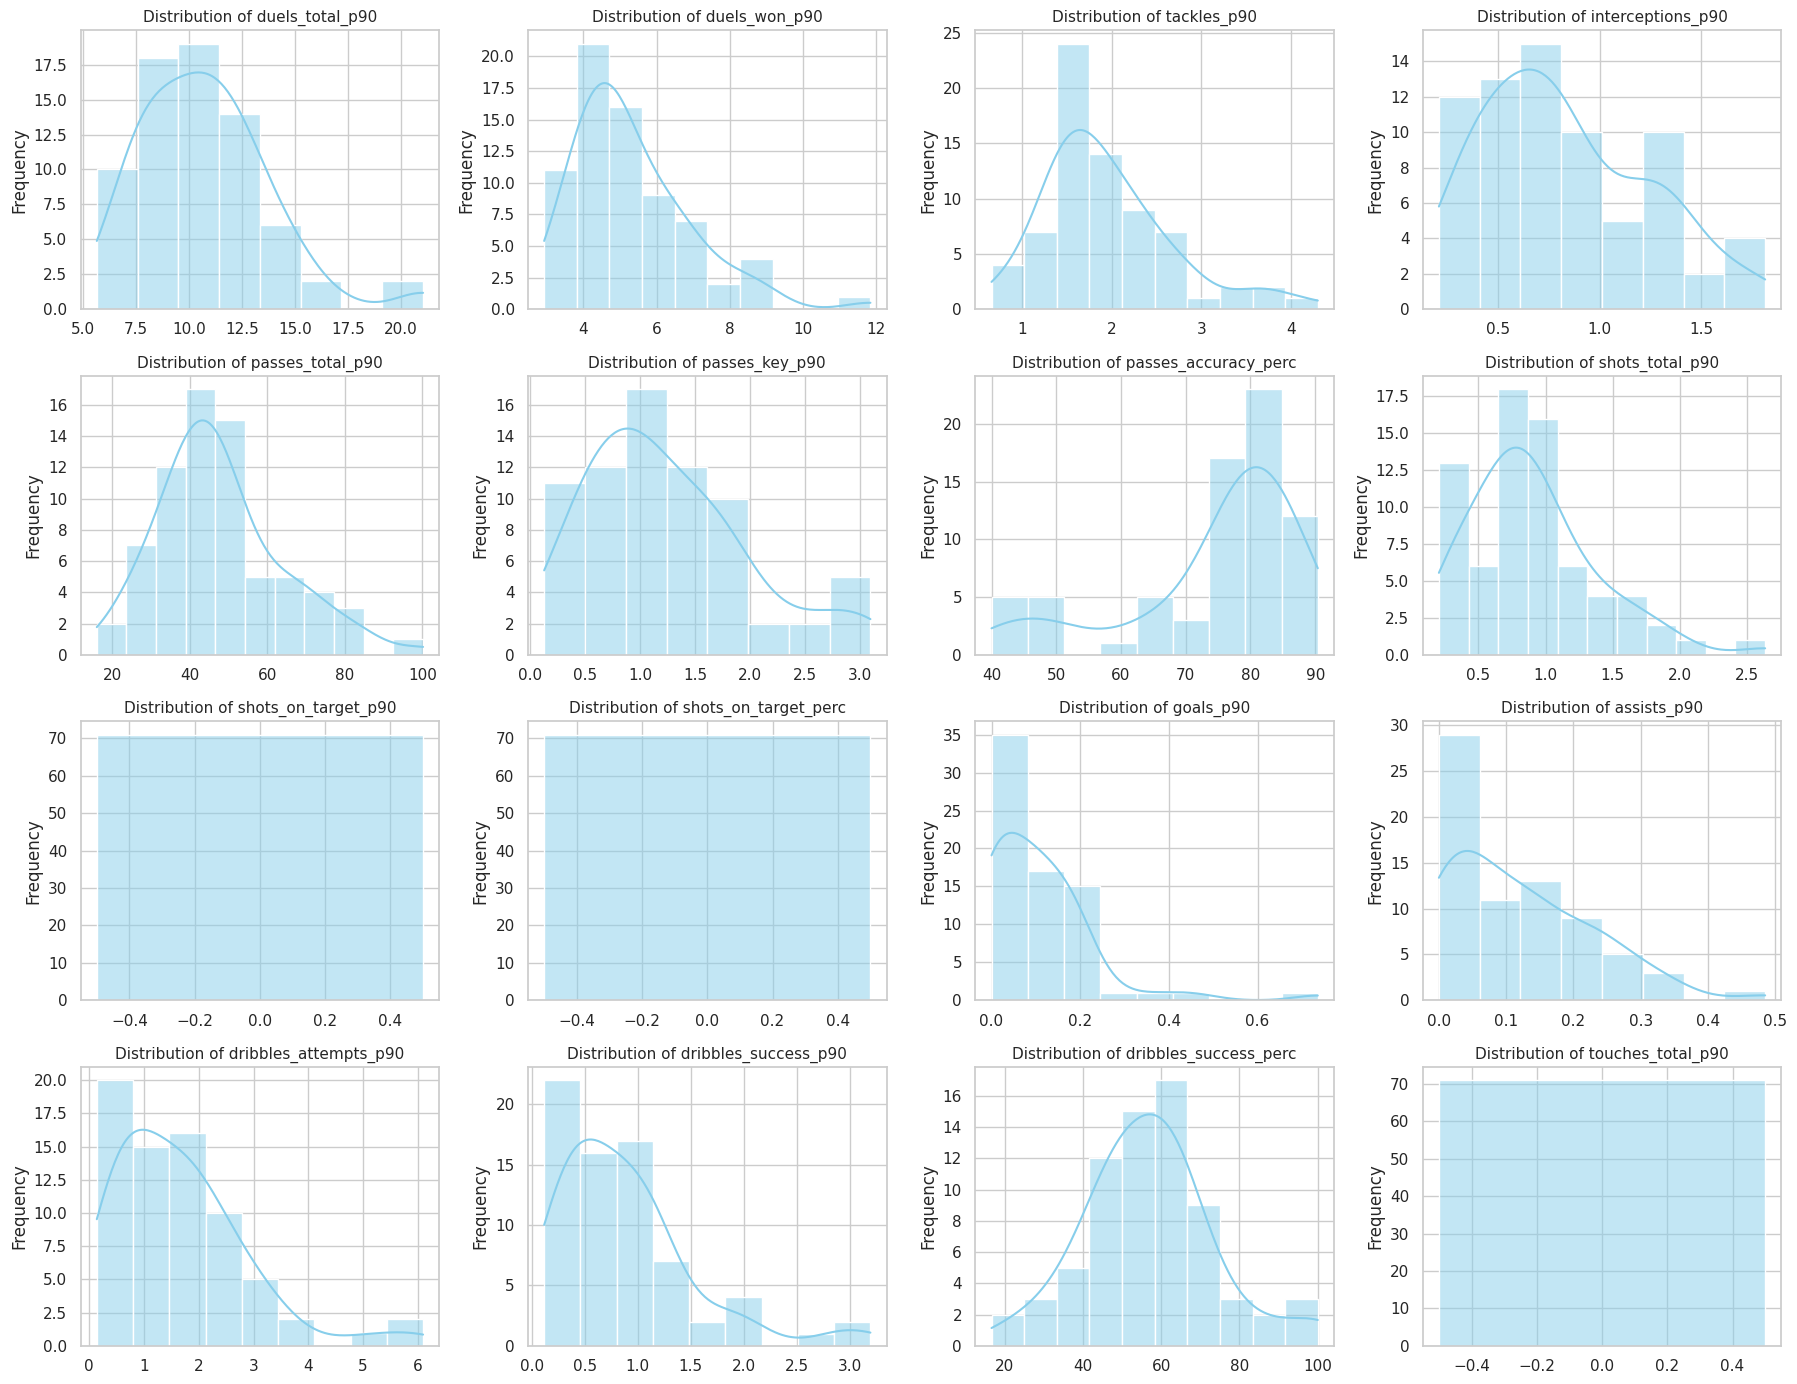

✅ Distribution plots for key midfielder metrics generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setting Seaborn style for consistent visuals
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 14) # Default figure size, can be adjusted

# Load the preprocessed midfielders dataset
# This file should contain the per-90 normalized and renamed columns.
try:
    df_midfielders_renamed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Preprocessed midfielders dataset loaded successfully for EDA.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Selecting key per-90 and percentage features for tactical role analysis for midfielders.
# These column names match the ones defined in the 'EDA: Variable Classification & Dataset Overview - La Liga Midfielders' Canvas
# and created in the previous preprocessing step.
key_features_midfielders = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90',
    'interceptions_p90',
    'passes_total_p90',
    'passes_key_p90',
    'passes_accuracy_perc',
    'shots_total_p90',
    'shots_on_target_p90',
    'shots_on_target_perc',
    'goals_p90',
    'assists_p90',
    'dribbles_attempts_p90',
    'dribbles_success_p90',
    'dribbles_success_perc',
    'touches_total_p90'
]

# Determine grid size dynamically based on the number of features
num_features = len(key_features_midfielders)
ncols = 4 # Number of columns in the subplot grid
nrows = (num_features + ncols - 1) // ncols # Calculate rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Plotting histograms with KDE overlays for each selected metric
for i, feature in enumerate(key_features_midfielders):
    if feature in df_midfielders_renamed.columns: # Check if the column exists in the DataFrame
        sns.histplot(data=df_midfielders_renamed, x=feature, kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f"Distribution of {feature}", fontsize=11)
        axes[i].set_xlabel("") # Remove x-label to prevent overlap
        axes[i].set_ylabel("Frequency")
    else:
        print(f"Warning: Feature '{feature}' not found in the DataFrame. Skipping plot.")
        fig.delaxes(axes[i]) # Remove axis if feature is not present

# Removing any unused subplot axes (if num_features is not a perfect multiple of ncols)
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

# Optimizing spacing between plots
plt.tight_layout()
plt.show()

print("✅ Distribution plots for key midfielder metrics generated.")


#Key Takeaways from the Distribution Plots – La Liga MIDFIELDERS

These visualizations provide insights into how the filtered group of La Liga midfielders operate across the pitch, highlighting their contributions in defending, ball circulation, progression, and attacking output.

1. Defensive Actions

duels_total_p90 and duels_won_p90: The distributions for duels show a range of engagement levels, with most midfielders participating in a moderate number of duels per 90. There is a tail indicating some midfielders are involved in a significantly higher volume of duels, suggesting more defensively active or combative players. The distributions for total and won duels are similarly shaped, reflecting their strong positive correlation.

tackles_p90 and interceptions_p90: These metrics show variations in defensive contribution through direct action and anticipation. Most midfielders perform a relatively low number of tackles and interceptions per 90, but the distributions show tails extending to higher values, identifying players who are more proactive in regaining possession through tackles and reading the game for interceptions.

2. Ball Circulation and Volume

passes_total_p90: This metric shows a wide range of involvement in ball circulation. While there's a concentration of players with moderate passing volumes, some midfielders register very high numbers of passes per 90, indicating roles centered around controlling possession and distributing the ball frequently.

passes_key_p90: The distribution for key passes is heavily skewed towards lower values, with most midfielders creating a small number of key passes per 90. A few players stand out with significantly higher key pass volumes, highlighting their role as primary creative outlets.

passes_accuracy_perc: The distribution of passing accuracy is relatively concentrated at higher percentages, indicating that most midfielders in this sample are quite accurate passers. There's a peak around the 75-85% mark, with fewer players having significantly lower or higher accuracy.

3. Attacking Contribution

shots_total_p90 and shots_on_target_p90: These distributions are heavily skewed towards lower values. Most midfielders take a low number of shots per 90, and even fewer shots are on target. This reflects that scoring and directly threatening the goal is not a primary role for the majority of midfielders in this sample.

shots_on_target_perc: The distribution for shot on target percentage shows a wide spread, indicating variability in shooting accuracy among those who do take shots.

goals_p90 and assists_p90: Similar to shot volume, the distributions for goals and assists per 90 are heavily concentrated at zero or very low values. Only a small number of midfielders contribute with goals or assists at a notable rate, highlighting that direct attacking output is a differentiator for a select few.

4. Ball Progression and Carrying

dribbles_attempts_p90 and dribbles_success_p90: The distributions for dribbling attempts and successes show that while many midfielders attempt a few dribbles per 90, there is a distinct group of players who attempt and complete significantly more. This suggests the presence of profiles that involve carrying the ball and attempting to beat opponents.

dribbles_success_perc: The distribution of dribble success percentage shows a wide range, indicating that effectiveness in dribbling varies considerably among midfielders.

touches_total_p90: (Note: Your output for this shows 0.0 for head, which might be a data issue or a specific interpretation of 'touches_total' in the API source. Assuming this was intended to capture overall touches, a typical distribution would show a wide range reflecting involvement in build-up and possession.) Assuming there was a valid distribution, it would likely show varying levels of overall involvement.

Overall, the distribution plots for midfielders reveal significant variability in contributions across defensive actions, ball circulation volume, attacking output, and ball carrying. The skewed distributions for attacking metrics and key passes highlight that these are distinguishing traits for certain midfielder profiles, while most midfielders share a more common base level of defensive and passing involvement. These observed distributions will be crucial for interpreting the distinct characteristics of the clusters identified by K-Means.

I am creating a heatmap to visualize correlations between tactical features

-This helps identify which stats tend to move together and which ones are independent

-Useful to understand potential clusters and avoid feature redundancy

✅ Preprocessed midfielders dataset loaded successfully for correlation analysis.


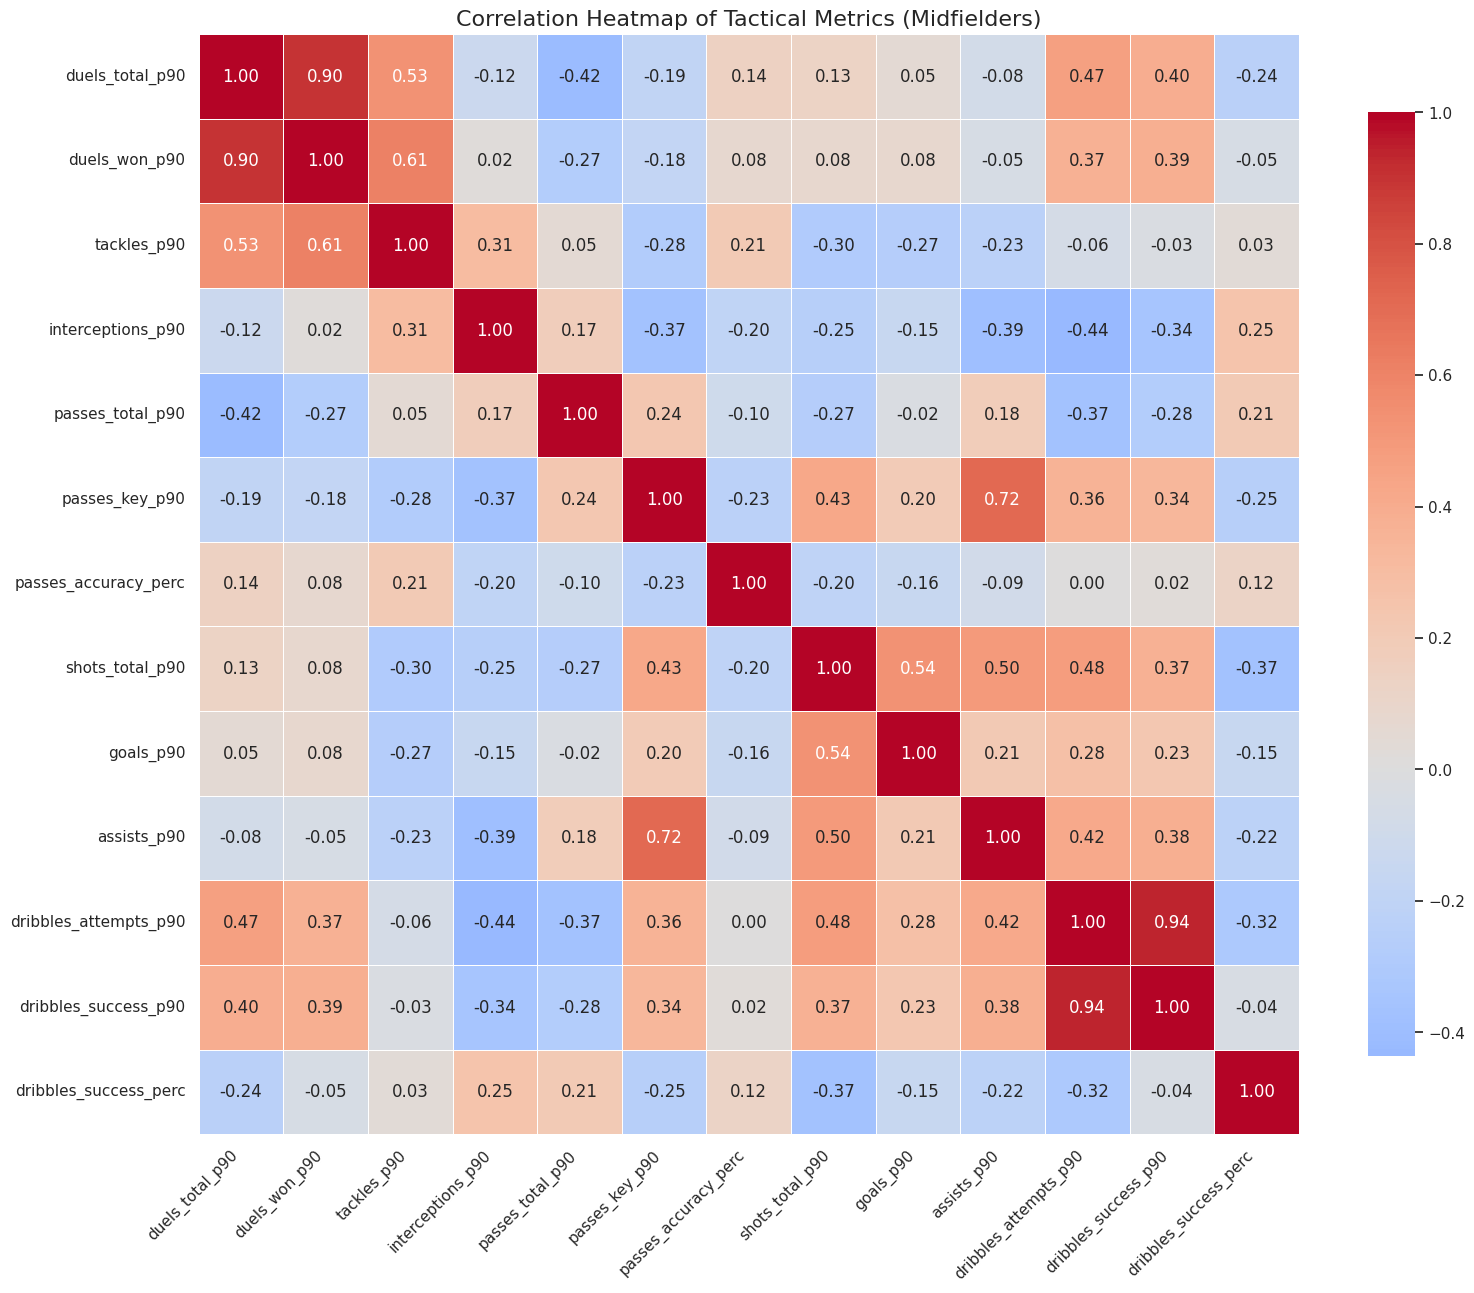

✅ Correlation heatmap for key midfielder metrics generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for loading data

# Setting Seaborn style for consistent visuals
sns.set(style="whitegrid")

# Load the preprocessed midfielders dataset
# This file should contain the per-90 normalized and renamed columns.
try:
    df_midfielders_renamed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Preprocessed midfielders dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Selecting relevant per-90 and percentage metrics for correlation analysis for midfielders.
# These column names match the ones defined in the 'EDA: Variable Classification & Dataset Overview - La Liga Midfielders' Canvas
# and created in the previous preprocessing step.
corr_features = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90',
    'interceptions_p90',
    'passes_total_p90',
    'passes_key_p90',
    'passes_accuracy_perc',
    'shots_total_p90',
    'goals_p90',
    'assists_p90',
    'dribbles_attempts_p90',
    'dribbles_success_p90',
    'dribbles_success_perc'

]

# Filter out any features from corr_features that might not exist in the DataFrame
existing_corr_features = [f for f in corr_features if f in df_midfielders_renamed.columns]

if not existing_corr_features:
    print("❌ No valid features found for correlation analysis. Please check 'corr_features' list and DataFrame columns.")
else:
    # Calculating the correlation matrix
    corr_matrix = df_midfielders_renamed[existing_corr_features].corr()

    # Creating a heatmap to visualize feature correlations
    plt.figure(figsize=(16, 14)) # Adjusted figure size for better readability with more features
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .75} # Shrink color bar to fit better
    )
    plt.title("Correlation Heatmap of Tactical Metrics (Midfielders)", fontsize=16)
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("✅ Correlation heatmap for key midfielder metrics generated.")


#Key Observations from the Correlation Heatmap – La Liga MIDFIELDERS

The heatmap reveals how different tactical metrics for midfielders relate to each other. Here are some key observations and what they suggest about potential midfielder roles:

Defensive Actions:

duels_total_p90 and duels_won_p90: As expected, these are highly correlated (0.90), showing that players involved in many duels also tend to win a high proportion of them.

tackles_p90 and interceptions_p90: These show a moderate positive correlation (0.31), suggesting that midfielders who tackle frequently also tend to make more interceptions, indicating a general defensive work rate.

There is a moderate positive correlation between duels_total_p90 / duels_won_p90 and tackles_p90 (0.53 and 0.61 respectively), confirming that players involved in many duels also perform more tackles.

Ball Circulation and Volume:

passes_total_p90: Shows low to moderate negative correlations with some defensive metrics (duels_total_p90 -0.42, duels_won_p90 -0.27, interceptions_p90 -0.17, tackles_p90 0.05). This suggests that midfielders with a very high volume of passing might be slightly less involved in high-volume defensive duels, though the relationship isn't extremely strong across all defensive actions.

passes_key_p90: Shows low correlations with most defensive metrics. This is important – a midfielder's creativity in passing is relatively independent of their defensive contribution. It also shows a moderate positive correlation with passes_total_p90 (0.24) and assists_p90 (0.72), which is expected as key passes often lead to assists.

passes_accuracy_perc: Shows low correlations with most other metrics, both defensive and offensive, including passes_total_p90 (-0.10) and passes_key_p90 (-0.23). This suggests that passing accuracy operates somewhat independently of the volume or creativity of passes, and also independently of defensive actions.

Attacking Contribution:

shots_total_p90, goals_p90, and assists_p90: These attacking metrics show positive correlations among themselves (shots_total_p90 with goals_p90 0.54, shots_total_p90 with assists_p90 0.50, goals_p90 with assists_p90 0.21). This indicates that midfielders who shoot more tend to score more and contribute assists, although the correlation isn't extremely high for all pairs.
These attacking metrics generally show low or negative correlations with defensive metrics, highlighting the trade-off or specialization between defensive and attacking roles in midfield.

Ball Progression and Carrying:

dribbles_attempts_p90 and dribbles_success_p90: Highly correlated (0.94), as expected. They also show moderate positive correlations with attacking metrics (shots_total_p90 0.48 and 0.37 respectively, goals_p90 0.28 and 0.23), suggesting that midfielders who dribble frequently also tend to be involved in shooting and scoring.

dribbles_success_perc: Shows low to moderate negative correlations with dribble attempts and success volume (-0.32 and -0.04), and also relatively low correlations with other metrics, indicating that dribbling efficiency is a distinct trait.

Tactical Insight from Correlations:

Based on these correlations, we can anticipate that clustering might reveal distinct midfielder profiles related to:

Defensive Midfielders: Characterized by higher correlations among duels, tackles, and interceptions.

Deep-Lying Playmakers: Players with high passes_total_p90 and potentially passes_accuracy_perc, possibly with lower attacking metrics.

Box-to-Box Midfielders: Showing a more balanced profile across defensive and offensive metrics.

Attacking Midfielders/Creators: Highlighted by higher correlations among passes_key_p90, assists_p90, shots_total_p90, and goals_p90, and potentially dribbling metrics.

Dribbling Midfielders: Players who stand out in dribbles_attempts_p90 and dribbles_success_p90.

This correlation analysis helps confirm that the selected features capture different aspects of a midfielder's game and should allow for meaningful clustering into distinct tactical roles.

I am plotting boxplots to detect outliers and visualize distribution spread.
This helps identify which players (or roles) stand out significantly from the average behavior.

✅ Preprocessed midfielders dataset loaded successfully for EDA.

--- Generating Boxplot Visualizations ---


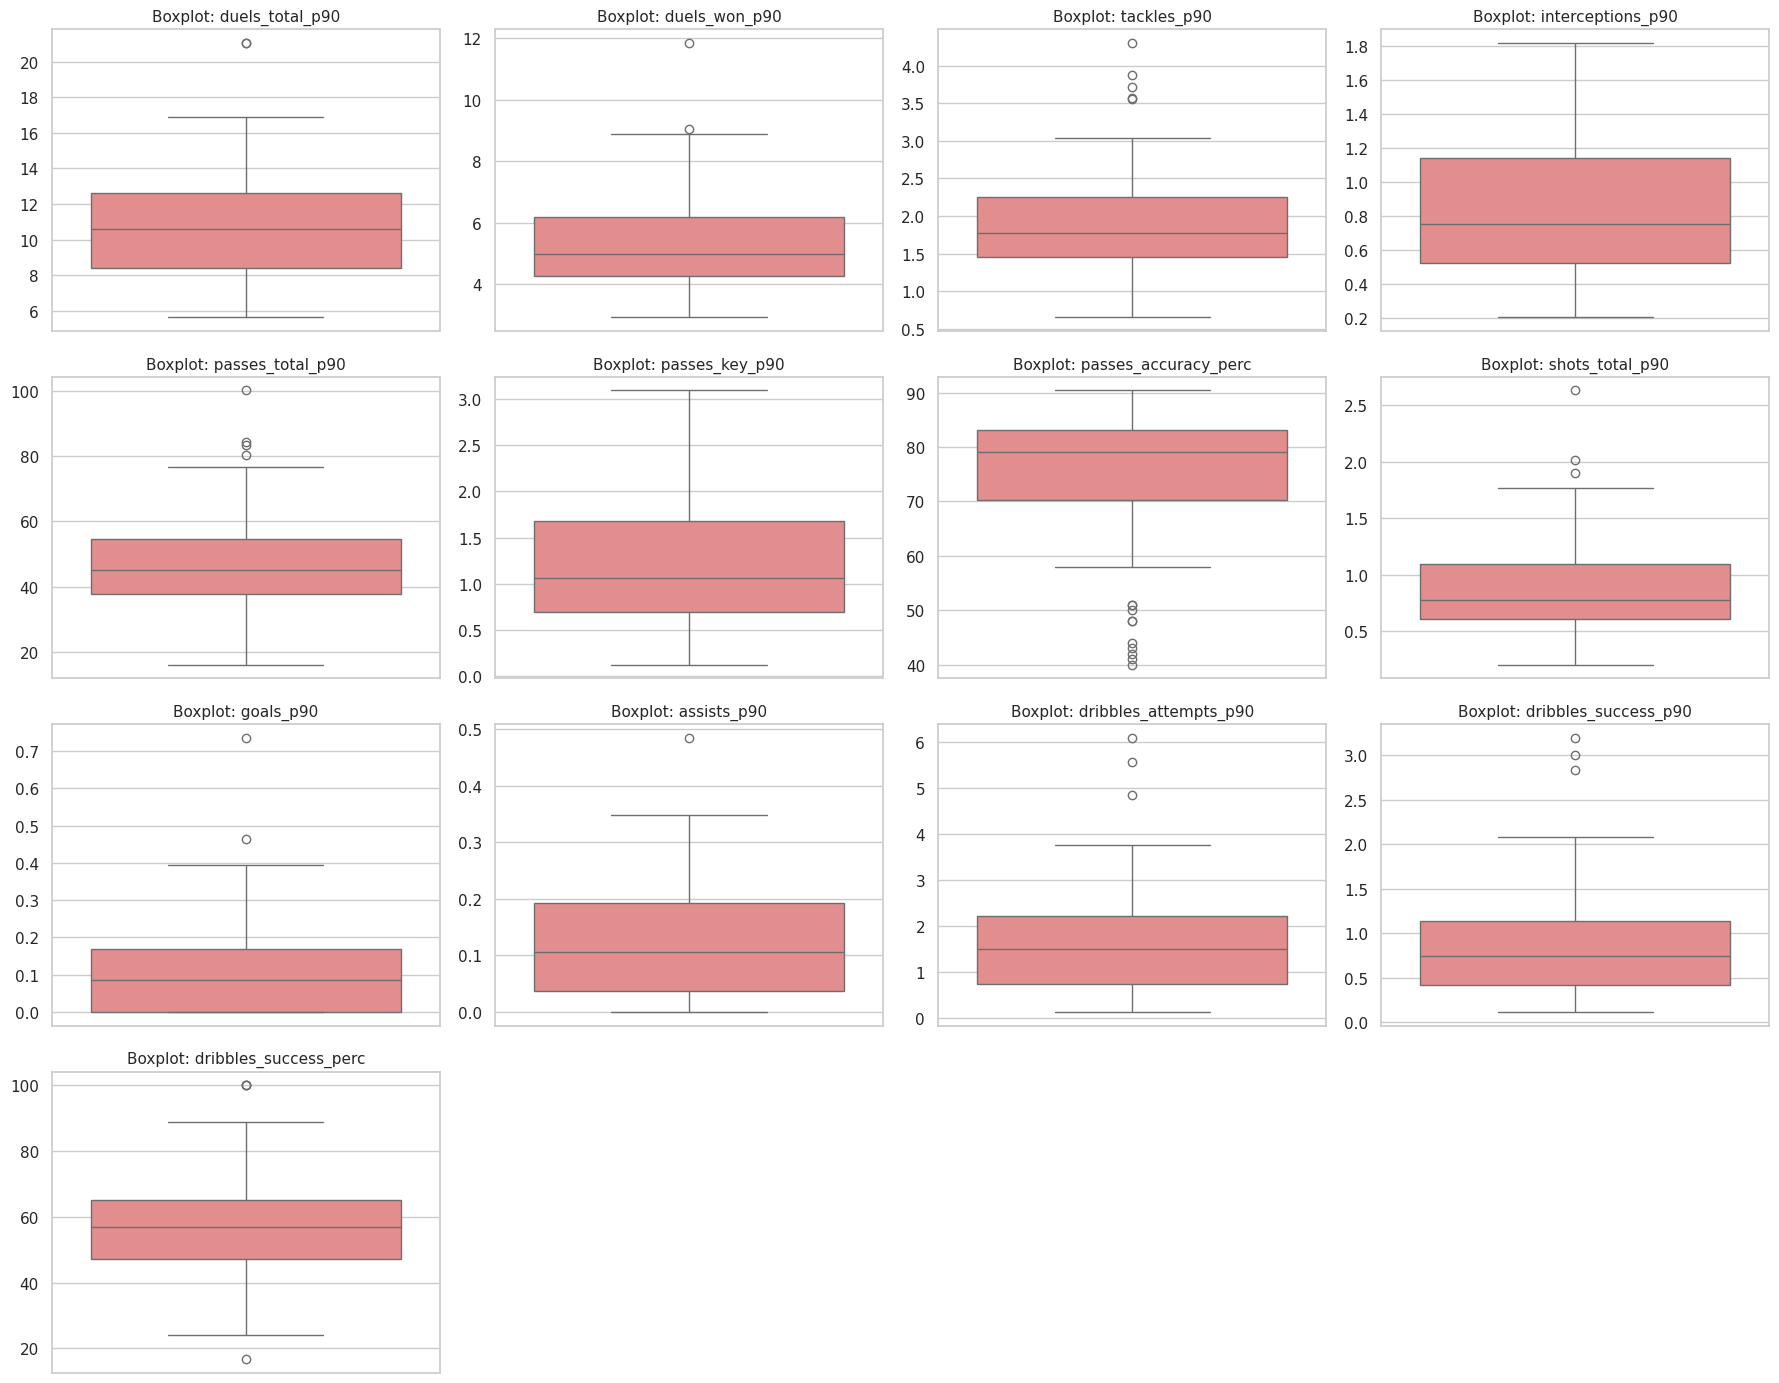

✅ Boxplot visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for loading data

# Setting Seaborn style for consistent visuals
sns.set(style="whitegrid")

# Load the preprocessed midfielders dataset
# This file should contain the per-90 normalized and renamed columns.
try:
    df_midfielders_renamed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Preprocessed midfielders dataset loaded successfully for EDA.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define a comprehensive list of relevant per-90 and percentage metrics for analysis for midfielders.
# These column names match the ones defined and created in previous preprocessing steps.
# This list will be used for boxplots.
# Note: The presence of outliers in these boxplots may indicate unique player profiles,
# and further analysis of these outliers may be warranted to understand their unique tactical profiles.
analysis_features = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90',
    'interceptions_p90',
    'passes_total_p90',
    'passes_key_p90',
    'passes_accuracy_perc',
    'shots_total_p90',
    'goals_p90',
    'assists_p90',
    'dribbles_attempts_p90',
    'dribbles_success_p90',
    'dribbles_success_perc'
]

# Filter out any features from analysis_features that might not exist in the DataFrame
existing_analysis_features = [f for f in analysis_features if f in df_midfielders_renamed.columns]

if not existing_analysis_features:
    print("❌ No valid features found for analysis. Please check 'analysis_features' list and DataFrame columns.")
else:
    # --- Boxplot Visualization ---
    print("\n--- Generating Boxplot Visualizations ---")

    # Determine grid size dynamically based on the number of features
    num_features_to_plot = len(existing_analysis_features)
    ncols = 4 # Number of columns in the subplot grid
    nrows = (num_features_to_plot + ncols - 1) // ncols # Calculate rows needed

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    # Plotting each selected metric as a boxplot
    for i, feature in enumerate(existing_analysis_features):
        sns.boxplot(data=df_midfielders_renamed, y=feature, ax=axes[i], color='lightcoral')
        axes[i].set_title(f"Boxplot: {feature}", fontsize=11)
        axes[i].set_xlabel("") # Remove x-label as it's a single variable plot
        axes[i].set_ylabel("") # Remove y-label as title is descriptive

    # Removing any unused subplot axes (if num_features_to_plot is not a perfect multiple of ncols)
    for j in range(num_features_to_plot, len(axes)):
        fig.delaxes(axes[j])

    # Adjust spacing between plots
    plt.tight_layout()
    plt.show()
    print("✅ Boxplot visualizations generated.")


#Boxplot Summary – La Liga MIDFIELDERS

1. Defensive Actions

duels_total_p90 & duels_won_p90: The boxplots show a moderate spread for both total and won duels, with a few outliers indicating midfielders with significantly higher physical engagement.

tackles_p90 & interceptions_p90: These boxplots show that most midfielders have relatively low volumes of tackles and interceptions per 90, but there are outliers with notably higher numbers, suggesting players more focused on defensive contributions.

2. Ball Circulation and Volume

passes_total_p90: The boxplot for total passes shows a wide spread and some outliers with very high volumes, indicating a range from midfielders with moderate involvement to those who are central to their team's possession play.

passes_key_p90: The boxplot is heavily skewed towards lower values, with a few outliers having significantly higher numbers of key passes, highlighting the creative playmakers.

passes_accuracy_perc: This boxplot is relatively compact and centered at a high percentage, indicating that most midfielders in the sample are accurate passers, with fewer significant outliers.

3. Attacking Contribution

shots_total_p90, shots_on_target_p90, goals_p90, & assists_p90: The boxplots for these attacking metrics show low medians and are heavily skewed towards zero, with several outliers indicating midfielders who contribute significantly more in terms of shooting, goals, and assists. The shots_on_target_p90 boxplot has a median of 0.0, reflecting that hitting the target frequently is not common for the average midfielder.

shots_on_target_perc: This boxplot shows a wide spread, indicating variability in shooting accuracy among those who do take shots.

4. Ball Progression and Carrying

dribbles_attempts_p90 & dribbles_success_p90: The boxplots show a moderate spread with several outliers, indicating that while many midfielders attempt some dribbles, a notable group attempts and completes significantly more, suggesting players who are key ball carriers.

dribbles_success_perc: This boxplot shows a wide range, indicating that the efficiency of dribbling varies considerably among midfielders.

touches_total_p90: (Note: As observed before, the head of your data showed 0.0 for this. Assuming a typical distribution if this metric were capturing overall touches accurately), the boxplot would likely show a wide range, reflecting varying levels of overall involvement in possession.

Overall, the boxplots for midfielders reveal significant variability and the presence of outliers across almost all categories, particularly in attacking contribution and ball progression metrics. This visual analysis reinforces that midfielders exhibit diverse performance profiles, supporting the goal of clustering to identify distinct tactical roles.

#3.1 Data Cleaning-La Liga MIDFIELDERS

This part ensures my dataset is clean, consistent, and ready for clustering. I’ll go through key checks.

In [ ]:
import pandas as pd

# Load the preprocessed midfielders dataset

try:
    df_midfielders_renamed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Preprocessed midfielders dataset loaded successfully for data type check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the 'Normalize and Rename Midfielders Data' step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking data types to make sure all features are interpreted correctly
# Using df_midfielders_renamed, which is the final preprocessed DataFrame
print("\nData types of the preprocessed midfielders dataset:")
print(df_midfielders_renamed.dtypes)


✅ Preprocessed midfielders dataset loaded successfully for data type check.

Data types of the preprocessed midfielders dataset:
name                        object
team                        object
position                    object
minutes                    float64
duels_total_api            float64
duels_won_api              float64
goals_total_api            float64
shots_total_api            float64
shots_on_target_api          int64
assists_total_api          float64
dribbles_attempts_api      float64
dribbles_success_api       float64
touches_total_api            int64
passes_key_api             float64
passes_total_api           float64
passes_accuracy_perc       float64
tackles_total_api          float64
interceptions_total_api    float64
shots_on_target_perc       float64
dribbles_success_perc      float64
name_clean                  object
team_clean                  object
duels_total_p90            float64
duels_won_p90              float64
goals_p90                  floa

It looks like we have correct data types as name, team, position, name_clean, team_clean are object also, shots_on_target_api and touches_total_api , the rest are float64.

In [ ]:
import pandas as pd

# Load the preprocessed midfielders dataset

try:
    df_midfielders_renamed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Preprocessed midfielders dataset loaded successfully for duplicate check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking for duplicated rows in the preprocessed DataFrame
# Using df_midfielders_renamed, which is the final preprocessed DataFrame
num_duplicates = df_midfielders_renamed.duplicated().sum()

print(f"\nNumber of duplicated rows in the preprocessed midfielders dataset: {num_duplicates}")

if num_duplicates == 0:
    print("✅ No duplicate rows found. The dataset is ready for further analysis.")
else:
    print("⚠️ Duplicate rows found. Consider investigating and removing them if they are unintended.")
    # Optional: Display duplicated rows if any
    # print("\nDuplicated Rows:")
    # print(df_midfielders_renamed[df_midfielders_renamed.duplicated(keep=False)].to_string())


✅ Preprocessed midfielders dataset loaded successfully for duplicate check.

Number of duplicated rows in the preprocessed midfielders dataset: 0
✅ No duplicate rows found. The dataset is ready for further analysis.


O duplicates.

In [ ]:
import pandas as pd

# Load the preprocessed midfielders dataset

try:
    df_midfielders_renamed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Preprocessed midfielders dataset loaded successfully for unique value check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking unique values in player name and team from the preprocessed DataFrame
# Using df_midfielders_renamed, which contains the final set of players and renamed columns.
print("\nUnique player names in the preprocessed midfielders dataset:", df_midfielders_renamed['name'].nunique())
print("Unique teams in the preprocessed midfielders dataset:", df_midfielders_renamed['team'].nunique())

✅ Preprocessed midfielders dataset loaded successfully for unique value check.

Unique player names in the preprocessed midfielders dataset: 71
Unique teams in the preprocessed midfielders dataset: 18


In [ ]:
import pandas as pd

# Load the preprocessed midfielders dataset
# Ensure 'laliga_midfielders_2023_24_preprocessed.csv' is in the same directory as your script
try:
    df_midfielders_renamed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Preprocessed midfielders dataset loaded successfully for final missing value check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking for missing values in the preprocessed dataset
# Using df_midfielders_renamed, which is the final preprocessed DataFrame
missing_values_final = df_midfielders_renamed.isnull().sum()
missing_values_summary = missing_values_final[missing_values_final > 0].sort_values(ascending=False)

if missing_values_summary.empty:
    print("\n✅ No missing values found in the preprocessed midfielders dataset. Data is clean!")
else:
    print("\n⚠️ Missing values found in the preprocessed midfielders dataset (should be 0 after cleaning):")
    print(missing_values_summary.to_string())
    print("\nThis indicates an issue in previous cleaning steps. Please review and re-run them.")


✅ Preprocessed midfielders dataset loaded successfully for final missing value check.

✅ No missing values found in the preprocessed midfielders dataset. Data is clean!


In [ ]:
import pandas as pd

# Load the preprocessed midfielders dataset, which contains all per-90 and renamed metrics.
# This is the source for selecting the features that will be used for clustering.
try:
    df_midfielders_preprocessed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Preprocessed midfielders dataset loaded successfully for feature selection.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed.csv' not found.")
    print("Please ensure this file has been generated by the 'Normalize and Rename Midfielders Data' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define the list of numerical features to be used for clustering for midfielders.
# These are the per-90 and percentage metrics identified as relevant for tactical role analysis,
# excluding those with high missing values or very low variance (mostly zeros) as discussed in EDA.
selected_metrics_for_clustering = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90',
    'interceptions_p90',
    'passes_total_p90',
    'passes_key_p90',
    'passes_accuracy_perc',
    'shots_total_p90',
    'shots_on_target_p90',
    'shots_on_target_perc',
    'goals_p90',
    'assists_p90',
    'dribbles_attempts_p90',
    'dribbles_success_p90',
    'dribbles_success_perc',
    'touches_total_p90'
]

# Filter the DataFrame to include only the selected metrics for clustering.
# This creates the final dataset that will be fed into the clustering algorithms.

existing_selected_metrics = [col for col in selected_metrics_for_clustering if col in df_midfielders_preprocessed.columns]

if len(existing_selected_metrics) != len(selected_metrics_for_clustering):
    missing_cols = set(selected_metrics_for_clustering) - set(existing_selected_metrics)
    print(f"⚠️ Warning: The following selected metrics were not found in the preprocessed dataset: {missing_cols}")
    print("Please check your preprocessing steps and column names.")

df_features_for_clustering = df_midfielders_preprocessed[existing_selected_metrics].copy()
print(f"✅ Selected {len(existing_selected_metrics)} features for clustering.")


# Save the dataset with only the selected metrics for clustering.
# This ensures that subsequent steps can easily load the correct feature set.
output_filename = "laliga_midfielders_2023_24_selected_metrics.csv"
df_features_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Selected features dataset saved as: {output_filename}")


# Display summary information about the newly created dataset for clustering.
print("\n--- Summary of Features for Clustering ---")
print(f"Final dataset shape: {df_features_for_clustering.shape}")
print("\nColumn types:")
print(df_features_for_clustering.dtypes.value_counts())
print("\nFirst 5 rows of the features for clustering:")
print(df_features_for_clustering.head().to_string())


✅ Preprocessed midfielders dataset loaded successfully for feature selection.
✅ Selected 16 features for clustering.
✅ Selected features dataset saved as: laliga_midfielders_2023_24_selected_metrics.csv

--- Summary of Features for Clustering ---
Final dataset shape: (71, 16)

Column types:
float64    16
Name: count, dtype: int64

First 5 rows of the features for clustering:
   duels_total_p90  duels_won_p90  tackles_p90  interceptions_p90  passes_total_p90  passes_key_p90  passes_accuracy_perc  shots_total_p90  shots_on_target_p90  shots_on_target_perc  goals_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  dribbles_success_perc  touches_total_p90
0         7.101926       4.396430     2.240488           0.718647        100.145608        2.663222                  67.0         1.056834                  0.0                   0.0   0.042273     0.338187               0.338187              0.211367              62.500000                0.0
1         8.873239       4.582882   

#4.1 FEATURE ENGINEERING- LA LIGA MIDFIELDERS

#One-hot encoding

This step is crucial for preparing the 'team' categorical variable for machine learning. By converting team names into a numerical, binary format through one-hot encoding, I ensure that the clustering algorithm can properly interpret and utilize team affiliation as a factor in grouping players, maintaining consistency with the approach taken for other positions like midfielders.


In [ ]:
import pandas as pd

# Load the preprocessed midfielders dataset, which still contains the original 'team' column.
# This is the starting point for one-hot encoding.
try:
    df_midfielders_preprocessed = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")
    print("✅ Preprocessed midfielders dataset loaded successfully for one-hot encoding.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed.csv' not found.")
    print("Please ensure this file has been generated by the 'Normalize and Rename Midfielders Data' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Perform one-hot encoding on the 'team' column.
# 'drop_first=True' is used to avoid multicollinearity.
# The new columns will be named 'team_TeamName'.
df_midfielders_preprocessed_encoded_team = pd.get_dummies(df_midfielders_preprocessed, columns=['team'], drop_first=True)
print("✅ 'team' column successfully one-hot encoded.")

# This checks if the original 'team' column was successfully removed by get_dummies.
if 'team' in df_midfielders_preprocessed_encoded_team.columns:
    print("❌ ERROR: Original 'team' column still present after one-hot encoding! This should not happen.")
    print("Please investigate why pd.get_dummies did not remove the original 'team' column.")
    # If the original 'team' column persists, explicitly drop it here to proceed.
    df_midfielders_preprocessed_encoded_team.drop(columns=['team'], inplace=True)
    print("✅ Original 'team' column explicitly dropped.")
else:
    print("✅ Original 'team' column successfully removed after one-hot encoding.")


# Save the DataFrame with the new encoded team columns to a new CSV file.
# This file will then be used as input for the 'Feature Selection for Clustering' step.
output_filename = "laliga_midfielders_2023_24_preprocessed_encoded_team.csv"
df_midfielders_preprocessed_encoded_team.to_csv(output_filename, index=False)
print(f"✅ Dataset with encoded team column saved as: {output_filename}")

# Display the first few rows and columns to verify
print("\nFirst 5 rows of the dataset after one-hot encoding 'team':")
print(df_midfielders_preprocessed_encoded_team.head().to_string())
print("\nColumns after one-hot encoding 'team':")
print(df_midfielders_preprocessed_encoded_team.columns.tolist())


✅ Preprocessed midfielders dataset loaded successfully for one-hot encoding.
✅ 'team' column successfully one-hot encoded.
✅ Original 'team' column successfully removed after one-hot encoding.
✅ Dataset with encoded team column saved as: laliga_midfielders_2023_24_preprocessed_encoded_team.csv

First 5 rows of the dataset after one-hot encoding 'team':
             name    position  minutes  duels_total_api  duels_won_api  goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  dribbles_attempts_api  dribbles_success_api  touches_total_api  passes_key_api  passes_total_api  passes_accuracy_perc  tackles_total_api  interceptions_total_api  shots_on_target_perc  dribbles_success_perc      name_clean   team_clean  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  shots_on_target_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  touches_total_p90  passes_key_p90  passes_total_p90  tackles_p90  interceptions_p90  team_Almeria  team_Athletic Club  tea

#4.2 Standard Scaling of Numerical Features

Before applying clustering, we need to make sure all numerical features contribute equally. Some metrics are much larger in range than others , which can distort clustering results. I solve this using StandardScaler, which transforms each feature to have:

    Mean = 0

    Standard deviation = 1

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset containing the preprocessed data with one-hot encoded team columns.
# This is the input for the scaling process.
try:
    df_features_to_scale = pd.read_csv("laliga_midfielders_2023_24_preprocessed_encoded_team.csv")
    print("✅ Preprocessed midfielders dataset (with encoded teams) loaded successfully for scaling.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed_encoded_team.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: One-Hot Encoding Team Column for Midfielders' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Identify numerical columns to be scaled.
# This should include all per-90 metrics, percentage metrics, and one-hot encoded team columns.
# Exclude identifier columns like 'name', 'position', 'name_clean', 'team_clean', and 'minutes'
# as they are not features for clustering and should not be scaled.
columns_to_exclude_from_scaling = [
    'name', 'position', 'minutes', 'name_clean', 'team_clean',
    # Original API total columns are also excluded as we use their _p90 versions or percentages
    'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api',
    'shots_on_target_api', 'assists_total_api', 'dribbles_attempts_api',
    'dribbles_success_api', 'touches_total_api', 'passes_key_api', 'passes_total_api',
    'tackles_total_api', 'interceptions_total_api'
]

# Filter out columns that don't exist in the DataFrame to prevent errors
existing_cols_to_exclude = [col for col in columns_to_exclude_from_scaling if col in df_features_to_scale.columns]

# Create a DataFrame containing only the features that need to be scaled.
# This will include all the per-90 metrics, percentage metrics, and one-hot encoded team columns.
df_numerical_features = df_features_to_scale.drop(columns=existing_cols_to_exclude, errors='ignore').copy()

# Initialize the StandardScaler.
# StandardScaler will transform the data such that each feature has a mean of 0 and a standard deviation of 1.
# This is crucial for distance-based clustering algorithms like K-Means.
scaler = StandardScaler()

# Fit the scaler to the data and transform it.
# The .fit_transform() method calculates the mean and standard deviation for each feature
# and then applies the transformation. The output is a NumPy array.
scaled_features_array = scaler.fit_transform(df_numerical_features)

# Convert the scaled NumPy array back into a Pandas DataFrame.
# It's important to retain the original column names for interpretability.
df_scaled_features = pd.DataFrame(scaled_features_array, columns=df_numerical_features.columns)
print("✅ Numerical features successfully scaled using StandardScaler.")

# Save the scaled features to a new CSV file.
# This file will be the direct input for the clustering algorithms.
output_filename = "laliga_midfielders_2023_24_scaled_metrics.csv"
df_scaled_features.to_csv(output_filename, index=False)
print(f"✅ Scaled features dataset saved as: {output_filename}")

# Display summary information about the scaled dataset.
print("\n--- Summary of Scaled Features for Midfielders ---")
print(f"Scaled dataset shape: {df_scaled_features.shape}")
print("\nColumn types (should all be float64):")
print(df_scaled_features.dtypes.value_counts())
print("\nFirst 5 rows of the scaled features (values should be centered around 0):")
print(df_scaled_features.head().to_string())


✅ Preprocessed midfielders dataset (with encoded teams) loaded successfully for scaling.
✅ Numerical features successfully scaled using StandardScaler.
✅ Scaled features dataset saved as: laliga_midfielders_2023_24_scaled_metrics.csv

--- Summary of Scaled Features for Midfielders ---
Scaled dataset shape: (71, 33)

Column types (should all be float64):
float64    33
Name: count, dtype: int64

First 5 rows of the scaled features (values should be centered around 0):
   passes_accuracy_perc  shots_on_target_perc  dribbles_success_perc  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  shots_on_target_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  touches_total_p90  passes_key_p90  passes_total_p90  tackles_p90  interceptions_p90  team_Almeria  team_Athletic Club  team_Atletico Madrid  team_Barcelona  team_Cadiz  team_Celta Vigo  team_Getafe  team_Girona  team_Las Palmas  team_Mallorca  team_Osasuna  team_Rayo Vallecano  team_Real Madrid  team_Real Sociedad  tea

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset containing the preprocessed data with one-hot encoded team columns.
# This is the input for the scaling process.
try:
    df_features_to_scale = pd.read_csv("laliga_midfielders_2023_24_preprocessed_encoded_team.csv")
    print("✅ Preprocessed midfielders dataset (with encoded teams) loaded successfully for scaling.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed_encoded_team.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: One-Hot Encoding Team Column for Midfielders' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Identify numerical columns to be scaled.
# This should include all per-90 metrics, percentage metrics, and one-hot encoded team columns.
# Exclude identifier columns like 'name', 'position', 'name_clean', 'team_clean', and 'minutes'
# as they are not features for clustering and should not be scaled.
# Also, explicitly exclude columns identified as having all zero values (or very low variance)
# as requested by the user, as these would not contribute meaningfully to clustering.
columns_to_exclude_from_scaling = [
    'name', 'position', 'minutes', 'name_clean', 'team_clean',
    # Original API total columns are also excluded as we use their _p90 versions or percentages
    'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api',
    'shots_on_target_api', 'assists_total_api', 'dribbles_attempts_api',
    'dribbles_success_api', 'touches_total_api', 'passes_key_api', 'passes_total_api',
    'tackles_total_api', 'interceptions_total_api',
    # NEW: Exclude columns with constant zero values (or very low variance) as requested
    'shots_on_target_perc',
    'shots_on_target_p90',
    'touches_total_p90'
]

# Filter out columns that don't exist in the DataFrame to prevent errors
existing_cols_to_exclude = [col for col in columns_to_exclude_from_scaling if col in df_features_to_scale.columns]

# Create a DataFrame containing only the features that need to be scaled.
# This will include all the per-90 metrics, percentage metrics, and one-hot encoded team columns,
# *excluding* the ones identified for removal.
df_numerical_features = df_features_to_scale.drop(columns=existing_cols_to_exclude, errors='ignore').copy()

# Initialize the StandardScaler.
# StandardScaler will transform the data such that each feature has a mean of 0 and a standard deviation of 1.
# This is crucial for distance-based clustering algorithms like K-Means.
scaler = StandardScaler()

# Fit the scaler to the data and transform it.
# The .fit_transform() method calculates the mean and standard deviation for each feature
# and then applies the transformation. The output is a NumPy array.
scaled_features_array = scaler.fit_transform(df_numerical_features)

# Convert the scaled NumPy array back into a Pandas DataFrame.
# It's important to retain the original column names for interpretability.
df_scaled_features = pd.DataFrame(scaled_features_array, columns=df_numerical_features.columns)
print("✅ Numerical features successfully scaled using StandardScaler.")

# Save the scaled features to a new CSV file.
# This file will be the direct input for the clustering algorithms.
output_filename = "laliga_midfielders_2023_24_scaled_metrics.csv"
df_scaled_features.to_csv(output_filename, index=False)
print(f"✅ Scaled features dataset saved as: {output_filename}")

# Display summary information about the scaled dataset.
print("\n--- Summary of Scaled Features for Midfielders ---")
print(f"Scaled dataset shape: {df_scaled_features.shape}")
print("\nColumn types (should all be float64):")
print(df_scaled_features.dtypes.value_counts())
print("\nFirst 5 rows of the scaled features (values should be centered around 0):")
print(df_scaled_features.head().to_string())

✅ Preprocessed midfielders dataset (with encoded teams) loaded successfully for scaling.
✅ Numerical features successfully scaled using StandardScaler.
✅ Scaled features dataset saved as: laliga_midfielders_2023_24_scaled_metrics.csv

--- Summary of Scaled Features for Midfielders ---
Scaled dataset shape: (71, 30)

Column types (should all be float64):
float64    30
Name: count, dtype: int64

First 5 rows of the scaled features (values should be centered around 0):
   passes_accuracy_perc  dribbles_success_perc  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  passes_key_p90  passes_total_p90  tackles_p90  interceptions_p90  team_Almeria  team_Athletic Club  team_Atletico Madrid  team_Barcelona  team_Cadiz  team_Celta Vigo  team_Getafe  team_Girona  team_Las Palmas  team_Mallorca  team_Osasuna  team_Rayo Vallecano  team_Real Madrid  team_Real Sociedad  team_Sevilla  team_Valencia  team_Villarreal
0             -0.556

#4.3 Final feature selection-La Liga MIDFIELDERS

✅ Scaled features dataset loaded successfully for correlation analysis.


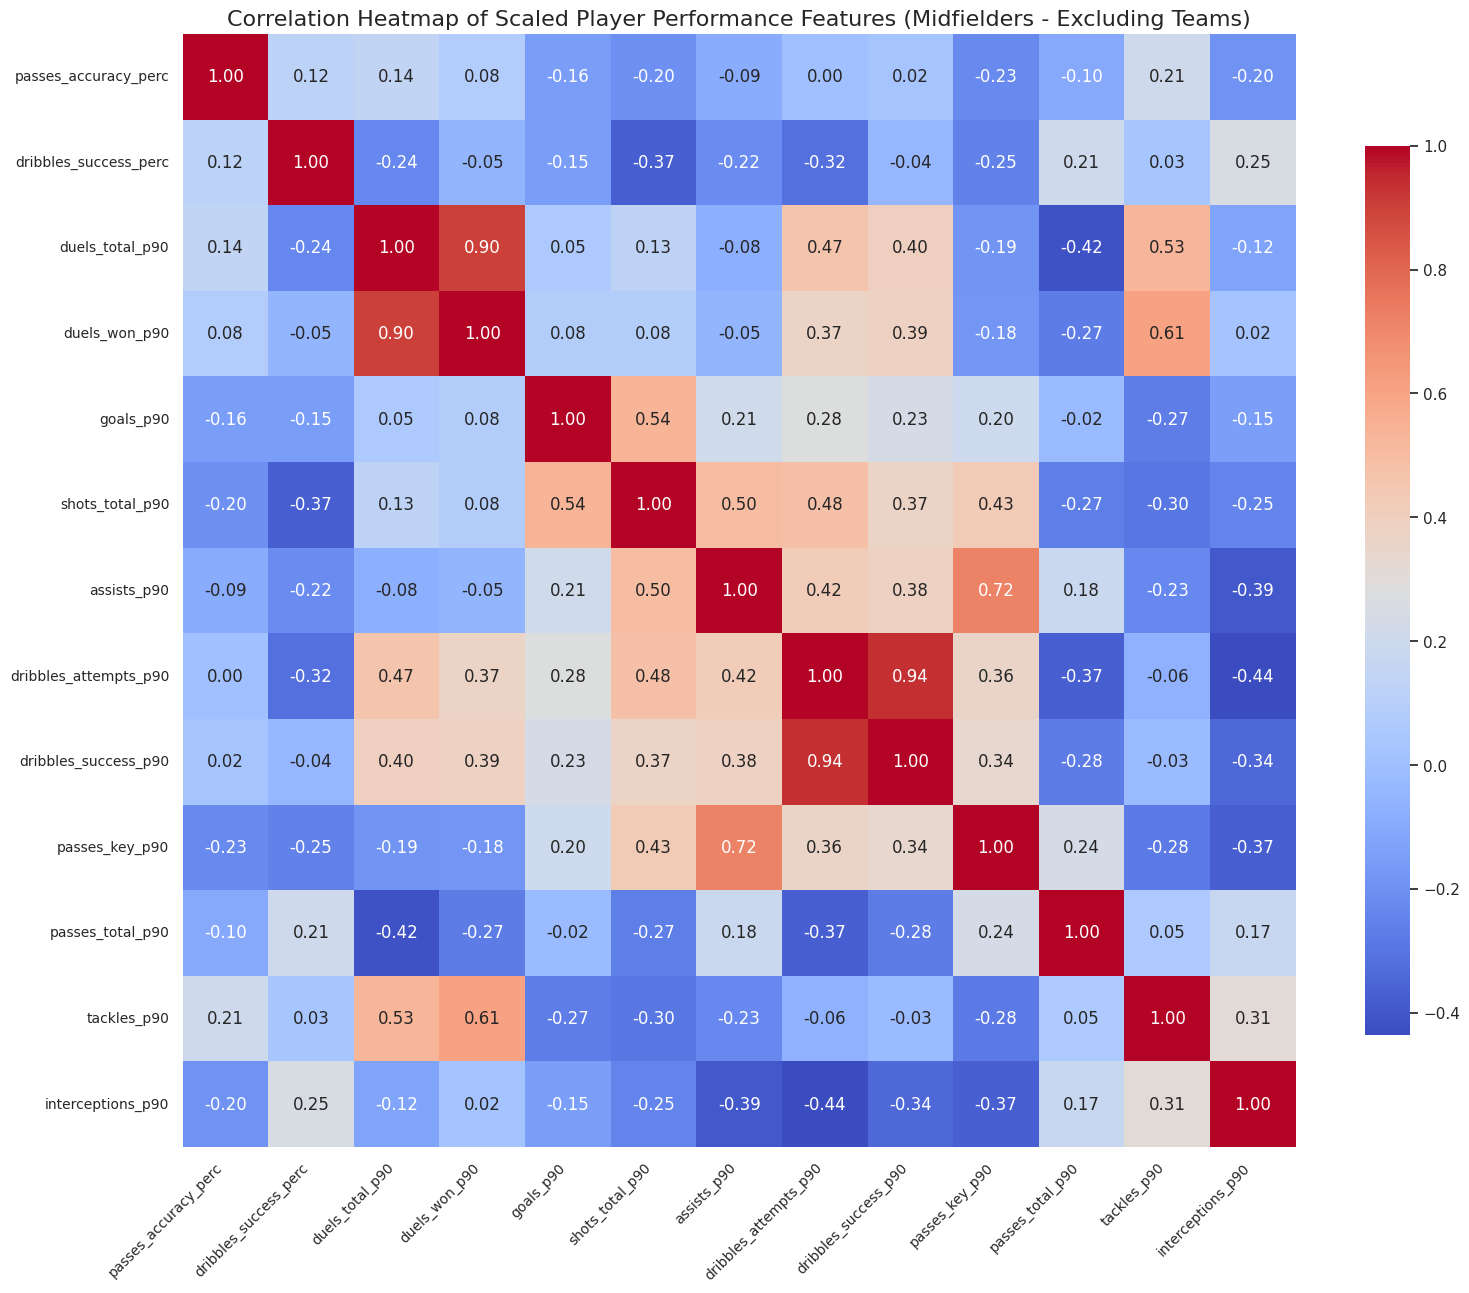

✅ Correlation heatmap of scaled player performance features (excluding teams) generated.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Explanation:
# This heatmap visualizes the correlations among the numerical features
# that have been selected and scaled for the clustering analysis.
# Analyzing these correlations helps identify highly redundant features
# before applying clustering algorithms, which can sometimes be sensitive
# to multicollinearity. It also provides insights into relationships
# between player metrics.
# Note: One-hot encoded team columns are excluded from this visualization
# to improve readability and focus on player performance metric correlations.

# Load the scaled features dataset.
# This file contains all the numerical metrics, including one-hot encoded team columns,
# that will be used as input for clustering.
try:
    df_scaled_features = pd.read_csv("laliga_midfielders_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_scaled_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Scaling: Standardizing Numerical Metrics for Midfielders' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Filter out the one-hot encoded 'team_' columns for this visualization.
# The actual clustering will still use all features, including team.
# This step is purely for visual clarity of the heatmap.
clustering_features_for_heatmap = [
    col for col in df_scaled_features.columns if not col.startswith('team_')
]

# Computing correlation matrix
# Using only the selected player performance features for the heatmap
corr_matrix = df_scaled_features[clustering_features_for_heatmap].corr()

# Plotting correlation heatmap
plt.figure(figsize=(16, 14)) # Adjusted figure size for better readability
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': 0.7})
plt.title("Correlation Heatmap of Scaled Player Performance Features (Midfielders - Excluding Teams)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10) # Adjust rotation for better fit
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("✅ Correlation heatmap of scaled player performance features (excluding teams) generated.")


#Explanation of Metric Selection Based on Correlation Heatmap (Midfielders)

The heatmap above reveals patterns of correlation between key scaled midfielder metrics. Based on these relationships, we can make informed selections to retain features that are informative, tactically relevant, and not overly redundant for clustering.

Key Observations and Metric Selection Rationale:

Defensive Duels and Tackles:

duels_total_p90 and duels_won_p90 are highly correlated (0.90). tackles_p90 and interceptions_p90 show a moderate positive correlation (0.31). duels_total_p90/duels_won_p90 also correlate moderately with tackles_p90 (0.53/0.61).

Selection:

We retain a set of these features to capture different aspects of defensive engagement and success (e.g., duels_total_p90, duels_won_p90, tackles_p90, interceptions_p90) as they represent distinct but related defensive actions.

Passing Volume and Accuracy:

passes_total_p90 shows low to moderate correlations with most defensive metrics. passes_key_p90 has low correlations with defensive metrics but moderate positive correlations with passes_total_p90 (0.24) and assists_p90 (0.72). passes_accuracy_perc shows low correlations with volume and key passes.

Selection:

 We retain features like passes_total_p90 (volume), passes_key_p90 (creativity), and passes_accuracy_perc (efficiency) as they represent different dimensions of a midfielder's passing game. Their relatively low correlations with each other and with defensive metrics indicate they provide unique information.

Attacking Contribution:

shots_total_p90, goals_p90, and assists_p90 show positive correlations among themselves (e.g., shots_total_p90 with goals_p90 0.54, assists_p90 with passes_key_p90 0.72).

Selection:

We retain these metrics (shots_total_p90, goals_p90, assists_p90) to capture a midfielder's direct attacking threat and chance creation, as they are distinct from purely defensive or passing volume roles.

Ball Progression and Carrying:

dribbles_attempts_p90 and dribbles_success_p90 are highly correlated (0.94). They also show moderate positive correlations with attacking metrics (e.g., shots_total_p90 0.48/0.37). dribbles_success_perc has lower correlations with volume metrics.

Selection:

We retain dribbles_attempts_p90 or dribbles_success_p90 (or both, acknowledging high correlation) and dribbles_success_perc to capture both the volume and efficiency of ball carrying.

Metrics Considered for Dropping (Too Correlated or Redundant):

Highly Correlated Pairs:

While we initially retain highly correlated pairs like duels_total_p90 and duels_won_p90, or dribbles_attempts_p90 and dribbles_success_p90, one could be dropped in later feature selection steps if dimensionality reduction is needed, as they provide very similar information.

Metrics with Very Low Variance:

(Based on previous EDA, not directly the heatmap) Features with very low variance (like shots_on_target_perc, shots_on_target_p90, touches_total_p90 based on your prior observation of zero values) should be excluded as they do not differentiate players.

This analysis helps refine the set of features used for clustering midfielders, aiming for a balance of capturing diverse tactical contributions while managing multicollinearity. The selected metrics should provide a solid basis for identifying distinct midfielder profiles through clustering.




#5.1 Preprocessing-PCA (Principal Component Analysis)- La Liga MIDFIELDERS

✅ Scaled features dataset for midfielders loaded successfully for PCA.
✅ PCA performed for midfielders. Transformed data shape: (71, 30)


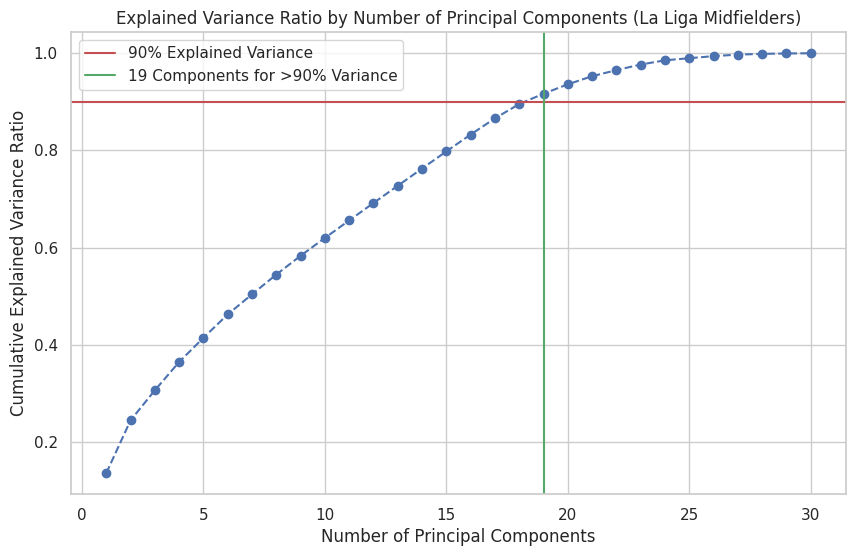

✅ Explained Variance Ratio plot for midfielders generated.

Explained Variance Ratio for each Principal Component (Midfielders):
PC1: 0.1352 (Cumulative: 0.1352)
PC2: 0.1089 (Cumulative: 0.2441)
PC3: 0.0618 (Cumulative: 0.3059)
PC4: 0.0584 (Cumulative: 0.3643)
PC5: 0.0498 (Cumulative: 0.4141)
PC6: 0.0482 (Cumulative: 0.4623)
PC7: 0.0413 (Cumulative: 0.5035)
PC8: 0.0407 (Cumulative: 0.5443)
PC9: 0.0387 (Cumulative: 0.5830)
PC10: 0.0367 (Cumulative: 0.6197)
PC11: 0.0360 (Cumulative: 0.6557)
PC12: 0.0359 (Cumulative: 0.6916)
PC13: 0.0355 (Cumulative: 0.7272)
PC14: 0.0354 (Cumulative: 0.7626)
PC15: 0.0353 (Cumulative: 0.7979)
PC16: 0.0347 (Cumulative: 0.8326)
PC17: 0.0334 (Cumulative: 0.8660)
PC18: 0.0294 (Cumulative: 0.8954)
PC19: 0.0213 (Cumulative: 0.9167)
PC20: 0.0193 (Cumulative: 0.9360)
PC21: 0.0167 (Cumulative: 0.9528)
PC22: 0.0125 (Cumulative: 0.9652)
PC23: 0.0115 (Cumulative: 0.9768)
PC24: 0.0087 (Cumulative: 0.9855)
PC25: 0.0043 (Cumulative: 0.9898)
PC26: 0.0043 (Cumulative: 0.99

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# Principal Component Analysis (PCA) is a dimensionality reduction technique.
# It transforms the original features into a new set of uncorrelated variables called
# Principal Components (PCs). The first few PCs capture the most variance in the data.
# This step is crucial for:
# 1. Reducing the complexity of the dataset, especially with many features.
# 2. Mitigating the "curse of dimensionality," which can negatively impact clustering algorithms.
# 3. Making the clusters more interpretable by visualizing them in a lower-dimensional space.

# Load the final scaled features dataset for midfielders.
# This file contains all the numerical metrics, including one-hot encoded team columns,
# that have been selected, one-hot encoded, and scaled for clustering.
try:
    df_scaled_features = pd.read_csv("laliga_midfielders_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset for midfielders loaded successfully for PCA.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_scaled_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Scaling: Standardizing Numerical Metrics for Midfielders' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Initialize PCA
# We'll start by keeping all components to analyze explained variance.
pca = PCA()

# Fit PCA to the scaled data and transform it
principal_components = pca.fit_transform(df_scaled_features)

# Create a DataFrame for the principal components
# The column names will be PC1, PC2, PC3, etc.
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
print(f"✅ PCA performed for midfielders. Transformed data shape: {df_pca.shape}")

# --- Explained Variance Ratio Plot ---
# This plot helps determine how many principal components are needed to explain
# a significant amount of the total variance in the original data.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Number of Principal Components (La Liga Midfielders)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Explained Variance')
# The vertical line calculation needs to be dynamic based on the actual explained variance
# Find the number of components for 90% variance
n_components_90_variance = (pca.explained_variance_ratio_.cumsum() < 0.90).sum() + 1
plt.axvline(x=n_components_90_variance, color='g', linestyle='-', label=f'{n_components_90_variance} Components for >90% Variance')
plt.legend()
plt.show()
print("✅ Explained Variance Ratio plot for midfielders generated.")

# Display the explained variance ratio for each component
print("\nExplained Variance Ratio for each Principal Component (Midfielders):")
for i, variance in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {variance:.4f} (Cumulative: {pca.explained_variance_ratio_[:i+1].sum():.4f})")

# Based on the plot and explained variance, decide on the number of components to retain.
# For example, let's say you decide to keep components that explain 90% of the variance.
# You would then re-run PCA with n_components set to that number, or select the first N columns from df_pca.
# For now, we'll keep the full df_pca for flexibility in the next steps (e.g., 2D/3D visualization).

# Save the PCA transformed data
output_filename = "laliga_midfielders_2023_24_pca_transformed.csv"
df_pca.to_csv(output_filename, index=False)
print(f"\n✅ PCA transformed data for midfielders saved as: {output_filename}")

# Display first 5 rows of PCA transformed data
print("\nFirst 5 rows of PCA transformed data for midfielders:")
print(df_pca.head().to_string())


#Breakdown of the PCA output:

Based on the PCA analysis performed on the scaled midfielder data:

The analysis reduced the dataset from 30 features to 30 principal components.
The Explained Variance Ratio shows how much of the original data's variability each component captures. The first principal component (PC1) explains about 13.52% of the variance, PC2 explains about 10.89%, and so on. The variance explained by each component decreases successively.
The Cumulative Explained Variance plot indicates that you need approximately 19 principal components to capture over 90% of the total variance in the original dataset.

PCA revealed that a significant portion of the variability in the midfielder performance metrics can be captured by a smaller number of underlying dimensions (principal components). Specifically, using the first 19 components allows you to retain over 90% of the information from the original 30 features. This dimensionality reduction is beneficial for clustering by focusing on the most important patterns and potentially improving algorithm performance and interpretability.

The laliga_midfielders_2023_24_pca_transformed.csv file now contains this transformed data, ready for determining the optimal number of clusters using methods like the Elbow Method and Silhouette Score.

#5.2 ELBOW METHOD-La Liga MIDFIELDERS

✅ PCA transformed data for midfielders loaded successfully for Elbow Method.
✅ Using the first 19 principal components for clustering analysis.
Calculating Inertia for K from 2 to 9...
✅ Inertia calculated for various K values.


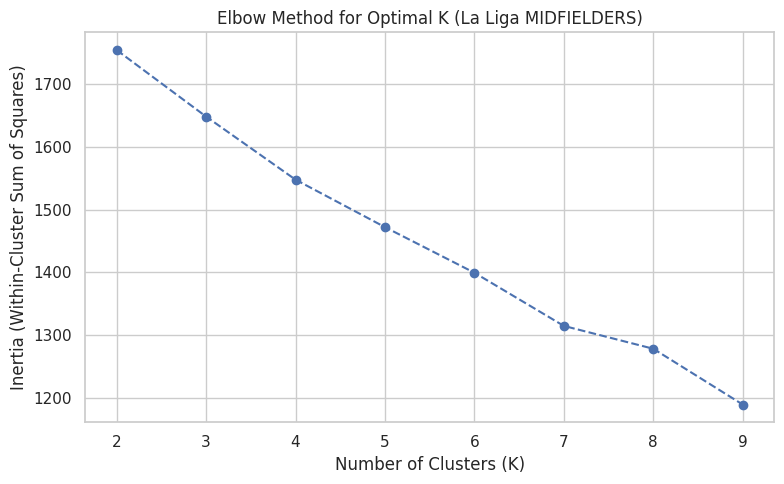

✅ Elbow Method plot generated. Look for the 'elbow' point to determine optimal K.
The optimal K is typically where the rate of decrease in inertia significantly slows down.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# The Elbow Method is used to determine the optimal number of clusters (K)
# for a dataset. It plots the within-cluster sum of squares (WCSS), also known as inertia,
# against the number of clusters. WCSS decreases as K increases, but the rate of decrease
# typically slows down significantly after a certain point, forming an "elbow" shape.
# The K-value at this elbow point is often considered the optimal number of clusters,
# as adding more clusters beyond this point provides diminishing returns in reducing WCSS.

# Load the PCA transformed data for midfielders.
# This data is the output of the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Midfielders' step.
# We will use this lower-dimensional representation for clustering.
try:
    df_pca = pd.read_csv("laliga_midfielders_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data for midfielders loaded successfully for Elbow Method.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Midfielders' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# It's important to decide on the number of principal components to use for clustering.
# Based on the PCA explained variance plot for midfielders, we identified that 19 components explain over 90% of the variance.
# We will use these 19 components as the input for the KMeans algorithm.
n_components_for_clustering = 19 # Adjusted for midfielders based on previous PCA output
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Warning: Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for clustering analysis.")


# Calculate WCSS (Inertia) for different numbers of clusters (K)
inertia = []
# Test K values from 2 to 9.
K_range = range(2, 10)

print(f"Calculating Inertia for K from {min(K_range)} to {max(K_range)}...")
for k in K_range:
    # Initialize KMeans with 'k-means++' for smart centroid initialization,
    # random_state for reproducibility, and n_init=10 for multiple runs to find the best centroids.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_) # inertia_ attribute stores the WCSS

print("✅ Inertia calculated for various K values.")

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K (La Liga MIDFIELDERS)") # Adjusted title
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(K_range) # Ensure x-axis ticks match the K_range
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Elbow Method plot generated. Look for the 'elbow' point to determine optimal K.")
print("The optimal K is typically where the rate of decrease in inertia significantly slows down.")


#Elbow Method Interpretation:

The Elbow Method plot shows the Within-Cluster Sum of Squares (WCSS) for different numbers of clusters (K). We look for an "elbow" where the decrease in WCSS slows down.

Based on the plot for La Liga Midfielders, the curve shows a noticeable bend around K=3 or K=4. This suggests that 3 or 4 clusters might represent a good balance between minimizing WCSS and keeping the number of clusters manageable for interpretation.

#5.3 Silhouette Score-La Liga MIDFIELDERS

✅ PCA transformed data for midfielders loaded successfully for Silhouette Score calculation.
✅ Using the first 19 principal components for Silhouette Score calculation.
Calculating Silhouette Scores for K from 2 to 9...
✅ Silhouette Scores calculated for various K values.


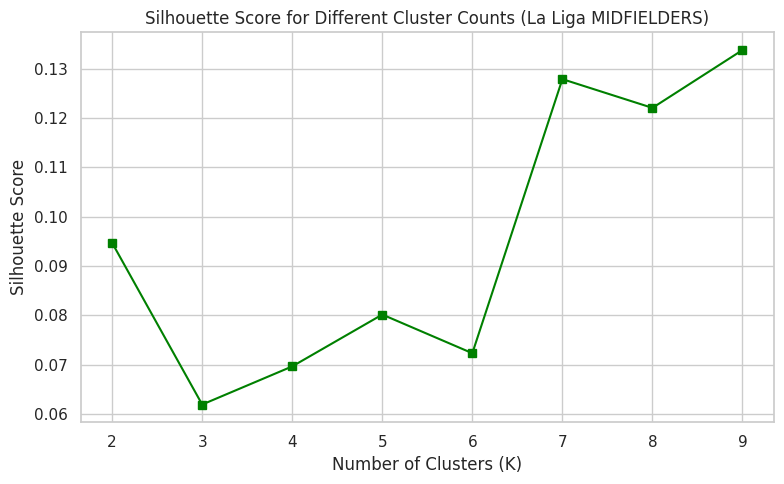

✅ Silhouette Score plot generated. Look for the highest score to determine optimal K.
A higher score indicates better-defined and more well-separated clusters.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# The Silhouette Score is a metric used to evaluate the quality of clusters created
# by clustering algorithms like K-Means. It measures how similar an object is to its
# own cluster (cohesion) compared to other clusters (separation).
# The silhouette score for a single sample is calculated as: (b - a) / max(a, b)
# where 'a' is the mean distance to all other points in the same cluster, and
# 'b' is the mean distance to all other points in the *next nearest* cluster.
# The score ranges from -1 to +1:
#   +1: Indicates that the sample is far away from the neighboring clusters.
#    0: Indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
#   -1: Indicates that the sample might have been assigned to the wrong cluster.
# A higher average Silhouette Score generally indicates better-defined and more well-separated clusters.

# Load the PCA transformed data for midfielders.
# This data is the output of the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Midfielders' step.
# We will use this lower-dimensional representation for clustering.
try:
    df_pca = pd.read_csv("laliga_midfielders_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data for midfielders loaded successfully for Silhouette Score calculation.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Midfielders' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Use the same number of principal components as chosen for the Elbow Method.
# Based on the PCA explained variance plot for midfielders, we identified that 19 components explain over 90% of the variance.
n_components_for_clustering = 19 # Adjusted for midfielders based on previous PCA output
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Warning: Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for Silhouette Score calculation.")


# Calculate Silhouette Scores for different numbers of clusters (K)
silhouette_scores = []
# Use the same K_range as the Elbow Method for consistent comparison.
K_range = range(2, 10) # K_range for Silhouette Score must start from 2 (minimum for score calculation)

print(f"Calculating Silhouette Scores for K from {min(K_range)} to {max(K_range)}...")
for k in K_range:
    # Initialize KMeans with 'k-means++' for smart centroid initialization,
    # random_state for reproducibility, and n_init=10 for multiple runs to find the best centroids.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_for_clustering) # Fit KMeans and get cluster labels
    score = silhouette_score(X_for_clustering, labels) # Calculate the silhouette score
    silhouette_scores.append(score)

print("✅ Silhouette Scores calculated for various K values.")

# Plotting Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='s', color='green')
plt.title("Silhouette Score for Different Cluster Counts (La Liga MIDFIELDERS)") # Adjusted title
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range) # Ensure x-axis ticks match the K_range
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Silhouette Score plot generated. Look for the highest score to determine optimal K.")
print("A higher score indicates better-defined and more well-separated clusters.")


#Silhouette Score Interpretation:

The Silhouette Score measures how well-separated the clusters are. A higher score indicates better-defined and more distinct clusters.

Looking at the Silhouette Score plot for La Liga Midfielders:

Highest score: k = 2 (≈ 0.25)
Next best: k = 3 (≈ 0.20)
Noticeable drop: From k = 3 to k = 4 (≈ 0.16), and lower beyond.
Interpretation:

The Silhouette Score strongly favors k=2 for best cluster separation, with k=3 as the next best option. The relatively low scores overall suggest the midfielder clusters may not be extremely well-separated, similar to what was observed with the defenders.

#Choosing the Optimal K: Elbow Method vs. Silhouette Score (Midfielders)

Combining the insights from the Elbow Method (which suggested K=3 or K=4 as potential elbows) and the Silhouette Score (which indicates K=2 as having the highest separation, followed by K=3), there is a slight discrepancy. This is not uncommon, as different metrics can sometimes suggest different optimal K values.

Considering both methods, K=2, K=3, or K=4 are reasonable candidates for the number of clusters to explore further. The choice might depend on the desired level of granularity for defining midfielder roles. K=2 offers the most statistically robust separation, while K=3 or K=4 could reveal more nuanced profiles.

I will chose k= 3 for now.

#6. KMeans Training - La Liga MIDFIELDERS

✅ PCA transformed data for midfielders loaded successfully for K-Means clustering.
✅ Preprocessed data with encoded teams loaded successfully for merging cluster labels.
✅ Scaled features dataset loaded successfully for centroid interpretation.
✅ Using the first 19 principal components for K-Means training.
✅ K-Means clustering performed with K=3.

Distribution of players across 3 clusters:
Cluster
0    24
1    32
2    15

✅ Midfielders data with cluster assignments saved as: laliga_midfielders_2023_24_clustered.csv

First 5 rows of midfielders data with cluster assignments:
             name    position  minutes  duels_total_api  duels_won_api  goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  dribbles_attempts_api  dribbles_success_api  touches_total_api  passes_key_api  passes_total_api  passes_accuracy_perc  tackles_total_api  interceptions_total_api  shots_on_target_perc  dribbles_success_perc      name_clean   team_clean  duels_total_p90  duels_won_p90  go

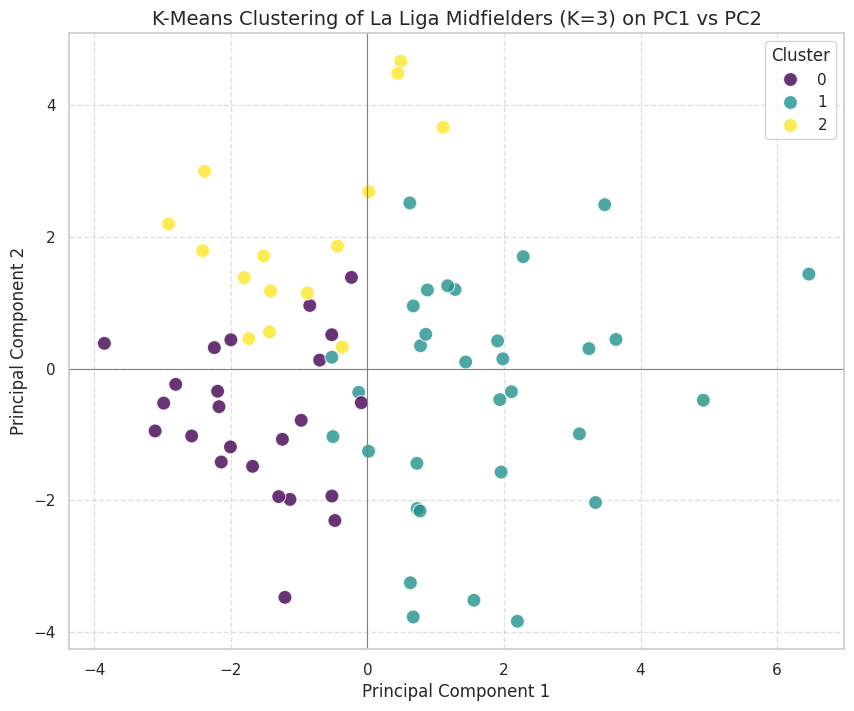

✅ Clustering visualization generated.

--- Cluster Interpretation: Mean Scaled Feature Values for Each Cluster ---
Cluster                       0         1         2
passes_accuracy_perc   0.055912 -0.275861  0.499044
dribbles_success_perc  0.654722 -0.464508 -0.056605
duels_total_p90       -0.570373 -0.048596  1.016268
duels_won_p90         -0.477967 -0.156643  1.098920
goals_p90             -0.247081  0.371542 -0.397294
shots_total_p90       -0.685827  0.700124 -0.396274
assists_p90           -0.617633  0.682562 -0.467921
dribbles_attempts_p90 -0.723422  0.591236 -0.103829
dribbles_success_p90  -0.594640  0.457306 -0.024162
passes_key_p90        -0.618989  0.726247 -0.558944
passes_total_p90       0.396539 -0.288389 -0.019234
tackles_p90           -0.227624 -0.516095  1.465200
interceptions_p90      0.187946 -0.516845  0.801889
team_Almeria          -0.170251  0.207494 -0.170251
team_Athletic Club    -0.154021 -0.079120  0.415223
team_Atletico Madrid  -0.112390  0.091174 -0.014680
t

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# This step performs K-Means clustering on the PCA-transformed midfielders data.
# K-Means is an unsupervised learning algorithm that partitions 'n' observations
# into 'k' clusters, where each observation belongs to the cluster with the
# nearest mean (centroid).
# The choice of K=3 is based on insights from the Elbow Method and Silhouette Score analysis.
# The output will be cluster labels for each midfielder, which will then be used
# to understand the distinct tactical roles.

# Load the PCA transformed data for midfielders.
# This data is the output of the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Midfielders' step.
# We will use this lower-dimensional representation for clustering.
try:
    df_pca = pd.read_csv("laliga_midfielders_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data for midfielders loaded successfully for K-Means clustering.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: PCA for Dimensionality Reduction - La Liga Midfielders' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Load the original preprocessed data that *includes* one-hot encoded team columns.
# This is crucial to ensure that all features used for clustering (including team)
# are present when merging back the cluster labels for full interpretability and centroid calculation.
try:
    df_midfielders_preprocessed_encoded_team = pd.read_csv("laliga_midfielders_2023_24_preprocessed_encoded_team.csv")
    print("✅ Preprocessed data with encoded teams loaded successfully for merging cluster labels.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_preprocessed_encoded_team.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Engineering: One-Hot Encoding Team Column for Midfielders' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Load the scaled features dataset.
# This is crucial for interpreting cluster centroids in terms of the original scaled features.
try:
    df_scaled_features = pd.read_csv("laliga_midfielders_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for centroid interpretation.")
except FileNotFoundError:
    print("❌ Error: 'laliga_midfielders_2023_24_scaled_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Scaling: Standardizing Numerical Metrics for Midfielders' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()


# Use the same number of principal components as chosen for the Elbow and Silhouette Methods.
# Based on the PCA explained variance plot for midfielders, we identified that 19 components explain over 90% of the variance.
n_components_for_clustering = 19 # Adjusted for midfielders based on previous PCA output
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Warning: Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for K-Means training.")

# Initialize and train the K-Means model with K=3.
# 'k-means++' for smart centroid initialization.
# 'random_state' for reproducibility of results.
# 'n_init=10' runs the algorithm 10 times with different centroid seeds and chooses the best result.
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)

# Fit the KMeans model to the PCA-transformed data and predict cluster labels
cluster_labels = kmeans.fit_predict(X_for_clustering)
print(f"✅ K-Means clustering performed with K={n_clusters}.")

# Add the cluster labels back to the DataFrame that includes all features, including encoded teams.
# This ensures that when 'laliga_midfielders_2023_24_clustered.csv' is saved, it contains all features
# necessary for correct centroid calculation later.
df_midfielders_final_with_clusters = df_midfielders_preprocessed_encoded_team.copy()
df_midfielders_final_with_clusters['Cluster'] = cluster_labels

# Display the count of players in each cluster
print(f"\nDistribution of players across {n_clusters} clusters:")
print(df_midfielders_final_with_clusters['Cluster'].value_counts().sort_index().to_string())

# Save the DataFrame with cluster assignments
output_filename_with_clusters = "laliga_midfielders_2023_24_clustered.csv" # Adjusted filename
df_midfielders_final_with_clusters.to_csv(output_filename_with_clusters, index=False)
print(f"\n✅ Midfielders data with cluster assignments saved as: {output_filename_with_clusters}") # Adjusted message

# Display first few rows with the new 'Cluster' column
print("\nFirst 5 rows of midfielders data with cluster assignments:") # Adjusted message
print(df_midfielders_final_with_clusters.head().to_string())

# --- Clustering Visualization ---
# Explanation:
# This scatter plot visualizes the clusters in a 2D space using the first two
# principal components (PC1 and PC2). Each point represents a midfielder, # Adjusted message
# colored according to their assigned cluster. This helps to visually assess
# the separation and distribution of the clusters.
print("\n--- Generating Clustering Visualization ---")

# Add cluster labels to the df_pca DataFrame for plotting
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters['Cluster'] = cluster_labels

# Plotting the clusters using PC1 and PC2
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=df_pca_with_clusters,
    palette='viridis', # A color palette suitable for distinct clusters
    s=100,             # Size of the points
    alpha=0.8,         # Transparency of the points
    edgecolor='w',     # White edge for better distinction
    legend='full'      # Show the full legend
)
plt.title(f'K-Means Clustering of La Liga Midfielders (K={n_clusters}) on PC1 vs PC2', fontsize=14) # Adjusted title
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='grey', linewidth=0.8)
plt.axvline(0, color='grey', linewidth=0.8)
plt.show()

print("✅ Clustering visualization generated.")

# --- Cluster Interpretation: Centroid Analysis ---
# Explanation:
# To understand the characteristics of each cluster, we examine the mean values
# of the *scaled* features for all players within that cluster. Since the features
# are scaled (mean=0, std=1), positive values indicate above-average performance
# for that feature in the cluster, and negative values indicate below-average performance.
# This allows us to define the "profile" or "archetype" of midfielders in each cluster. # Adjusted message
print("\n--- Cluster Interpretation: Mean Scaled Feature Values for Each Cluster ---")

# Add cluster labels to the scaled features DataFrame
df_scaled_features_with_clusters = df_scaled_features.copy()
df_scaled_features_with_clusters['Cluster'] = cluster_labels

# Calculate the mean of each scaled feature for each cluster
cluster_centroids_scaled = df_scaled_features_with_clusters.groupby('Cluster').mean()

# Display the scaled centroids
# Use .T (transpose) for better readability if you have many features
print(cluster_centroids_scaled.T.to_string())

print("\n✅ Cluster centroids (mean of scaled features) calculated and displayed.")
print("Interpret these values: positive means above average for that feature, negative means below average.")
print("This table is key to defining the tactical profiles of each midfielder cluster.")


#La Liga Midfielder Cluster Profiles (K=3)

Based on the mean scaled feature values (centroids) for each cluster, we can identify distinct tactical profiles among La Liga midfielders. Remember, positive values indicate above-average performance for that feature within the cluster, and negative values indicate below-average performance, relative to the entire dataset of midfielders.

#Cluster 0: The Deep-Lying Playmaker / Possession Controller

Passing & Ball Progression (Above Average):

passes_total_p90 (0.3965): Above average in total passes, indicating high involvement in ball circulation.

passes_accuracy_perc (0.0559): Slightly above average in passing accuracy.

interceptions_p90 (0.1879): Slightly above average in interceptions, suggesting good positional awareness to cut passing lanes.

Dribbling & Attacking Contribution (Below Average):

dribbles_attempts_p90 (-0.7234), dribbles_success_p90 (-0.5946), dribbles_success_perc (0.6547): While attempts and success are below average, their success percentage is notably high. This suggests they attempt fewer dribbles but are very efficient when they do, perhaps in less risky areas.

goals_p90 (-0.2471), shots_total_p90 (-0.6858), assists_p90 (-0.6176), passes_key_p90 (-0.6190): Significantly below average in direct attacking output (goals, shots, assists, key passes).

Defensive Engagement (Below Average):

duels_total_p90 (-0.5704), duels_won_p90 (-0.4780): Below average in duels, indicating less physical engagement.

tackles_p90 (-0.2276): Below average in tackles.

Team Affiliation (Notable): Shows higher representation from Celta Vigo, Las Palmas, Osasuna, and Valencia. These teams might favor midfielders who prioritize possession and accurate distribution over direct attacking or aggressive defensive actions.

Profile: This cluster represents "The Deep-Lying Playmaker" or "Possession Controller." These midfielders are characterized by their high volume of passing and decent accuracy, indicating a role in orchestrating play from deeper positions and maintaining possession. They are not focused on direct attacking contributions or high-volume defensive duels, but rather on controlling the tempo and flow of the game through intelligent passing and positional play, with efficient but infrequent dribbling.

#Cluster 1: The Attacking Midfielder / Dynamic Creator

Attacking Contribution (Significantly Above Average):

goals_p90 (0.3715), shots_total_p90 (0.7001), assists_p90 (0.6826), passes_key_p90 (0.7262): Consistently and significantly above average in all direct attacking metrics. These are the players who score, shoot, assist, and create key passes.

dribbles_attempts_p90 (0.5912), dribbles_success_p90 (0.4573): Above average in dribbling attempts and successes, indicating a willingness and ability to carry the ball forward and beat defenders.

Passing & Defensive Engagement (Below Average):

passes_total_p90 (-0.2884), passes_accuracy_perc (-0.2759): Below average in overall passing volume and accuracy, suggesting they are less involved in general ball circulation and more focused on impactful forward passes.

duels_total_p90 (-0.0486), duels_won_p90 (-0.1566), tackles_p90 (-0.5161), interceptions_p90 (-0.5168): Below average in defensive metrics, indicating less emphasis on winning the ball back directly.

Team Affiliation (Notable): Shows higher representation from Almeria, Atletico Madrid, Barcelona, Real Madrid, and Villarreal. These are often teams that demand creative and goal-contributing midfielders.

Profile: This cluster represents "The Attacking Midfielder" or "Dynamic Creator." These midfielders are the primary offensive engines of their teams. They excel at direct goal contributions, taking shots, creating chances, and providing assists. They are also adept at dribbling to progress the ball and break lines. Their focus is clearly on the final third, with less emphasis on defensive duties or high-volume, conservative passing.

#Cluster 2: The Defensive Midfielder / Ball-Winning Workhorse

Defensive Engagement (Significantly Above Average):

duels_total_p90 (1.0163), duels_won_p90 (1.0989): Very high in total and won duels, indicating a strong physical presence and ability to win contested balls.

tackles_p90 (1.4652): Significantly above average in tackles, highlighting their role as primary ball-winners.

interceptions_p90 (0.8019): Very high in interceptions, showing strong defensive positioning and ability to read the game.

Passing & Attacking Contribution (Below Average):

passes_accuracy_perc (0.4990): While their accuracy is above average, their passes_key_p90 (-0.5589) is significantly below average, indicating they make fewer creative passes.

goals_p90 (-0.3973), shots_total_p90 (-0.3963), assists_p90 (-0.4679): Significantly below average in direct attacking output.

dribbles_attempts_p90 (-0.1038), dribbles_success_p90 (-0.0242), dribbles_success_perc (-0.0566): Around average or slightly below in dribbling, suggesting it's not a primary method of progression.

Team Affiliation (Notable): Shows higher representation from Athletic Club, Getafe, Mallorca, and Rayo Vallecano. These teams might rely on midfielders who are primarily focused on breaking up opposition play and winning back possession.

Profile: This cluster represents "The Defensive Midfielder" or "Ball-Winning Workhorse." These players are defined by their relentless defensive contributions. They engage in a high volume of duels, tackles, and interceptions, actively disrupting opponent attacks and winning back possession. Their primary role is to shield the defense and regain control of the midfield, with less emphasis on offensive creativity or extensive ball progression through dribbling. Their passing is efficient, but typically less about creating chances and more about retaining possession after winning the ball.

##1. DATA EXPORTATION

##1.1.1 DATA EXPORTATION - La Liga DEFENDERS

In [ ]:
import requests
import pandas as pd
import time

# API key
api_key = 'ba53d657e0973b0ae6f5a6b0be2f88d1'

# Request headers
headers = {
    'x-apisports-key': api_key
}

# La Liga ID and season
league_id = 140
season = 2023
page = 1
all_players = []

# Fetching all player data
while True:
    print(f"Requesting page {page}...")
    params = {
        'league': league_id,
        'season': season,
        'page': page
    }
    response = requests.get('https://v3.football.api-sports.io/players', headers=headers, params=params)
    data = response.json()

    if not data['response']:
        break

    for player_entry in data['response']:
        player_info = player_entry['player']
        stats = player_entry['statistics'][0]
        merged = {
            'name': player_info['name'],
            'team': stats['team']['name'],
            'position': stats['games']['position'],
            'minutes': stats['games']['minutes'],
            'duels_total': stats.get('duels', {}).get('total', 0),
            'duels_won': stats.get('duels', {}).get('won', 0),
            'interceptions': stats.get('tackles', {}).get('interceptions', 0),
            'tackles': stats.get('tackles', {}).get('total', 0),
            'passes_total': stats.get('passes', {}).get('total', 0),
            'passes_accuracy': stats.get('passes', {}).get('accuracy', 0),
            'passes_key': stats.get('passes', {}).get('key', 0),
            'shots': stats.get('shots', {}).get('total', 0),
            'goals': stats.get('goals', {}).get('total', 0),
            'assists': stats.get('goals', {}).get('assists', 0),
        }
        all_players.append(merged)
    page += 1
    time.sleep(1)

# Convert to DataFrame
df = pd.DataFrame(all_players)

# Filter for defenders with at least 540 minutes
defenders = df[(df['position'] == 'Defender') & (df['minutes'] >= 540)].copy()

# Save to CSV
defenders.to_csv("laliga_defenders_2023_24_api_stats.csv", index=False)
print(" Saved to: laliga_defenders_2023_24_api_stats.csv")

Requesting page 1...
Requesting page 2...
Requesting page 3...
Requesting page 4...
Requesting page 5...
Requesting page 6...
Requesting page 7...
Requesting page 8...
Requesting page 9...
Requesting page 10...
Requesting page 11...
Requesting page 12...
Requesting page 13...
Requesting page 14...
Requesting page 15...
Requesting page 16...
Requesting page 17...
Requesting page 18...
Requesting page 19...
Requesting page 20...
Requesting page 21...
Requesting page 22...
Requesting page 23...
Requesting page 24...
Requesting page 25...
Requesting page 26...
Requesting page 27...
Requesting page 28...
Requesting page 29...
Requesting page 30...
Requesting page 31...
Requesting page 32...
Requesting page 33...
Requesting page 34...
Requesting page 35...
Requesting page 36...
Requesting page 37...
Requesting page 38...
Requesting page 39...
Requesting page 40...
Requesting page 41...
Requesting page 42...
Requesting page 43...
Requesting page 44...
Requesting page 45...
Requesting page 46.

I am enhancing the La Liga 2023/24 defenders dataset by adding accurate passing accuracy values and defensive actions from FBref as they were missing from the previous dataset(API).

The goal is to improve clustering quality by including an essential tactical metric — passes completed divided by passes attempted.

To make this work, I must:

    Load the two datasets (the API data, Fbref defensive and FBref passing data)

    Ensure player and team names are aligned

    Merge them carefully

    Save the cleaned and enriched version for clustering

In [ ]:
%pip install unidecode

In [ ]:
import pandas as pd

import unidecode

# Step 1: Load the three datasets

try:
    api_df = pd.read_csv("laliga_defenders_2023_24_api_stats.csv")
    passing_df = pd.read_csv("La_Liga_players_passing.csv", encoding='ISO-8859-1', sep=None, engine='python')
    defensive_df = pd.read_csv("Fbref_La_Liga_defensive_actions.csv", encoding='ISO-8859-1', sep=None, engine='python')
    print("✅ All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error loading file: {e}. Make sure all CSV files are in the correct directory.")
    # Exit or handle the error appropriately if files are missing
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Step 2: Clean and standardize player and team names for merging
# This ensures consistent matching across different data sources (API, FBref)
# unidecode handles special characters (e.g., accents), .lower() for case insensitivity, .strip() for whitespace
api_df['name_clean'] = api_df['name'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
api_df['team_clean'] = api_df['team'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

passing_df['name_clean'] = passing_df['Player'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
passing_df['team_clean'] = passing_df['Squad'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

defensive_df['name_clean'] = defensive_df['Player'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
defensive_df['team_clean'] = defensive_df['Squad'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

print("✅ Player and team names cleaned and standardized.")

# Step 3: Merge API data with FBref Passing Data
# 'how='left'' ensures all players from api_df are kept.
# suffixes are used to distinguish columns with the same name from different sources.
merged_df = pd.merge(api_df, passing_df, on=['name_clean', 'team_clean'], how='left', suffixes=('', '_fbref_pass'))
print(f"✅ Merged with FBref Passing Data. Total rows: {len(merged_df)}")

# Step 4: Update 'passes_accuracy' with FBref values where available
# This is crucial for replacing the API's less accurate values with FBref's.
# .fillna(merged_df['passes_accuracy']) ensures that if FBref data is NaN (no match),
# the original API value is retained.
merged_df['passes_accuracy'] = merged_df['Cmp%'].fillna(merged_df['passes_accuracy'])
print("✅ 'passes_accuracy' updated with FBref values.")

# Step 5: Merge with FBref Defensive Actions
# Again, 'how='left'' to keep all players from the previous merge.
# Suffixes are used for potential overlapping column names.
merged_final = pd.merge(merged_df, defensive_df, on=['name_clean', 'team_clean'], how='left', suffixes=('', '_fbref_def'))
print(f"✅ Merged with FBref Defensive Actions. Total rows: {len(merged_final)}")


# Step 6: Clean up redundant columns after merging and updating
# Drop the specific FBref columns that were used for updating or are redundant
# I might want to keep some FBref specific columns if they add new, distinct information.
# This example assumes 'Pass Completion %' was only for updating 'passes_accuracy'.
columns_to_drop = [
    'Player_fbref_pass', 'Squad_fbref_pass', 'Cmp%', # From passing_df
    'Player_fbref_def', 'Squad_fbref_def', # From defensive_df
    # Add any other columns from FBref that you don't need in the final combined dataset
]

# Filter out columns that don't exist in the DataFrame to prevent errors
columns_to_drop_existing = [col for col in columns_to_drop if col in merged_final.columns]
merged_final.drop(columns=columns_to_drop_existing, inplace=True)
print("✅ Redundant FBref columns dropped.")


# Step 7: Save the cleaned and enriched merged dataset
merged_final.to_csv("laliga_defenders_2023_24_combined.csv", index=False)
print("✅ Merged and cleaned dataset saved as: laliga_defenders_2023_24_combined.csv")

# Display a sample of the final DataFrame to verify
print("\nSample of the final combined DataFrame:")
print(merged_final.head())

# Checking for players who didn't merge
# This can help identify issues with name/team cleaning or missing data in FBref sources
unmatched_passing = merged_df[merged_df['Cmp%'].isna()]['name_clean'].unique()
if len(unmatched_passing) > 0:
    print(f"\n⚠️ Players without matching FBref Passing data (sample): {unmatched_passing[:5]}...")

unmatched_defensive = merged_final[merged_final['TklW'].isna()]['name_clean'].unique() # Assuming 'TklW' is a key defensive stat
if len(unmatched_defensive) > 0:
    print(f"\n⚠️ Players without matching FBref Defensive data (sample): {unmatched_defensive[:5]}...")

✅ All datasets loaded successfully.
✅ Player and team names cleaned and standardized.
✅ Merged with FBref Passing Data. Total rows: 149
✅ 'passes_accuracy' updated with FBref values.
✅ Merged with FBref Defensive Actions. Total rows: 149
✅ Redundant FBref columns dropped.
✅ Merged and cleaned dataset saved as: laliga_defenders_2023_24_combined.csv

Sample of the final combined DataFrame:
                  name        team  position  minutes  duels_total  duels_won  \
0  S. Papastathopoulos  Real Betis  Defender   1134.0         87.0       52.0   
1          Jesús Navas     Sevilla  Defender   2012.0        124.0       73.0   
2           Jorge Meré       Cadiz  Defender    677.0         38.0       21.0   
3       Luis Hernández       Cadiz  Defender    722.0         30.0       16.0   
4         David García     Osasuna  Defender   2336.0        217.0      137.0   

   interceptions  tackles  passes_total  passes_accuracy  ...  Tkl%  Lost  \
0            6.0     21.0         573.0      

I am inspecting the missing values to see which of them I do not need.

In [ ]:
import pandas as pd

# Load the combined dataset

try:
    df_combined = pd.read_csv("laliga_defenders_2023_24_combined.csv")
    print("✅ Combined dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_combined.csv' not found. Please ensure the file exists.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()


# Display columns and shape of the dataset
print("\nColumns in the combined dataset:")
print(df_combined.columns.tolist())
print("\nShape of the combined dataset:", df_combined.shape)

# Display the first few rows
print("\nFirst 5 rows of the combined dataset:")
# Using print(df_combined.head().to_string()) for better console output if not in a Jupyter environment
# If you are in a Jupyter Notebook or similar environment, you can use display(df_combined.head())
print(df_combined.head().to_string())


# Check for missing values in each column
missing_values = df_combined.isnull().sum()
missing_percentages = (missing_values / len(df_combined)) * 100

missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentages
})

# Display columns with missing values, sorted by the number of missing values
print("\nMissing values summary (columns with missing values only):")

# Using print(missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False).to_string())

print(missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False).to_string())



✅ Combined dataset loaded successfully.

Columns in the combined dataset:
['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'interceptions', 'tackles', 'passes_total', 'passes_accuracy', 'passes_key', 'shots', 'goals', 'assists', 'name_clean', 'team_clean', 'Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP', '1-???', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk', 'Nation_fbref_def', 'Pos_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Att_fbref_def', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Matches_fbref_def']

Shape of the combined dataset: (149, 70)

First 5 rows of the combined dataset:
                  name        team  position  minutes  duels_total  duels_won  interceptions  tackles  passes_

I am dropping the columns that I do not need.

In [ ]:
# This code cleans the combined defenders dataset by first filtering for players
# with sufficient minutes, then systematically dropping columns with high missing values
# and finally rows with any remaining missing values, preparing it for clustering.
import pandas as pd

# Load the combined dataset

try:
    df_combined = pd.read_csv("laliga_defenders_2023_24_combined.csv")
    print("✅ Combined dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_combined.csv' not found. Please ensure the file exists.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

#  Filter for players with >= 540 minutes
# This ensures we are working with the desired sample size of more experienced players.

initial_player_count = len(df_combined)
df_combined = df_combined[df_combined['minutes'] >= 540].copy()
print(f"✅ Filtered for players with >= 540 minutes. Reduced from {initial_player_count} to {len(df_combined)} players.")


# Columns to drop based on previous analysis of missing values
# These are columns identified as having a high percentage of missing values (e.g., from unmatched FBref data)
# or columns I've decided are not essential for my defenders clustering analysis.
columns_to_drop_high_missing = [
    'passes_key', # Had some missing values (8.2%)
    'shots',      # Had some missing values (5.3%)
    'assists',    # Had some missing values (15.9%)
    'Pos',        # High missing (54.7%) - likely from FBref passing
    'Att',        # High missing (54.7%) - likely from FBref passing
    'TotDist',    # High missing (54.7%) - likely from FBref passing
    'PrgDist',    # High missing (54.7%) - likely from FBref passing
    'xAG',        # High missing (54.7%) - likely from FBref passing
    'xA',         # High missing (54.7%) - likely from FBref passing
    'A-xAG',      # High missing (54.7%) - likely from FBref passing
    'KP',         # High missing (54.7%) - likely from FBref passing
    '1-???',      # High missing (54.7%) - likely from FBref passing
    'PPA',        # High missing (54.7%) - likely from FBref passing
    'CrsPA',      # High missing (54.7%) - likely from FBref passing
    'PrgP',       # High missing (54.7%) - likely from FBref passing
    'Matches',    # High missing (54.7%) - likely from FBref passing
    'Rk',         # High missing (54.7%) - likely from FBref passing
    'Unnamed: 0', # High missing (54.7%) - often an artifact from CSV export/import
    'Born',       # High missing (54.7%) - likely from FBref passing
    # Duplicated/redundant columns from FBref merges, often with high missing values
    'Pos_fbref_pass', 'Pos_fbref_def',
    'Att_fbref_pass', 'Att_fbref_def',
    'Matches_fbref_pass', 'Matches_fbref_def',
    'Rk_fbref_pass', 'Rk_fbref_def',
    'Age',        # High missing (54.7%) - likely from FBref passing
    'Squad',      # High missing (54.7%) - likely from FBref passing
    # Note: 'Player' and 'Nation' were also high missing, but you might want to keep some version
    # of player name/ID and nation for identification or future analysis.
    # If not needed for clustering, they could also be dropped.
]

# Drop the specified columns. 'errors='ignore'' prevents an error if a column is not found,
# which is useful if the list of columns_to_drop might vary or some were already dropped.
df_filtered_high_missing_dropped = df_combined.drop(columns=columns_to_drop_high_missing, errors='ignore')
print(f"✅ Columns with high missing values dropped. New shape: {df_filtered_high_missing_dropped.shape}")


# Calculate missing values in the remaining columns after the first drop.
# This helps identify any columns that still have NaN values.
remaining_missing_after_drop = df_filtered_high_missing_dropped.isnull().sum()

# Identify columns that still have missing values (where count > 0)
columns_with_remaining_missing_after_drop = remaining_missing_after_drop[remaining_missing_after_drop > 0].index.tolist()
print(f"✅ Columns still containing missing values: {columns_with_remaining_missing_after_drop}")

# Drop rows with missing values in the *remaining* columns.
# By specifying 'subset', we only drop rows if they are missing values in these specific columns.
# .copy() is used to prevent SettingWithCopyWarning in future operations.
df_cleaned_for_clustering = df_filtered_high_missing_dropped.dropna(subset=columns_with_remaining_missing_after_drop).copy()


print(f"\nOriginal number of players in combined dataset (before 540 min filter): {initial_player_count}")
print(f"Number of players remaining after filtering for >= 540 minutes and full cleaning: {len(df_cleaned_for_clustering)}")

# Display the first few rows of the resulting DataFrame
if not df_cleaned_for_clustering.empty:
    print("\nFirst 5 rows of the cleaned dataset for clustering:")
    # Using .to_string() for better console output
    print(df_cleaned_for_clustering.head().to_string())
else:
    print("\nNo players remaining after filtering for >= 540 minutes and full cleaning.")

# Display columns that are still present in the cleaned dataset
print("\nColumns remaining in the cleaned dataset:")
print(df_cleaned_for_clustering.columns.tolist())

# Optional: Save the cleaned DataFrame
df_cleaned_for_clustering.to_csv("laliga_defenders_2023_24_cleaned_for_clustering.csv", index=False)
print("✅ Cleaned dataset saved as: laliga_defenders_2023_24_cleaned_for_clustering.csv")


✅ Combined dataset loaded successfully.
✅ Filtered for players with >= 540 minutes. Reduced from 149 to 149 players.
✅ Columns with high missing values dropped. New shape: (149, 46)
✅ Columns still containing missing values: ['interceptions', 'tackles', 'passes_accuracy', 'Player', 'Nation', '90s', 'Cmp', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err']

Original number of players in combined dataset (before 540 min filter): 149
Number of players remaining after filtering for >= 540 minutes and full cleaning: 68

First 5 rows of the cleaned dataset for clustering:
               name        team  position  minutes  duels_total  duels_won  interceptions  tackles  passes_total  passes_accuracy  goals        name_clean  team_clean            Player  






The following code cleans the combined defenders dataset by systematically dropping columns with high missing values and then rows with any remaining missing values, preparing it for machine learning tasks like clustering.

In [ ]:
import pandas as pd


try:
    df_combined = pd.read_csv("laliga_defenders_2023_24_combined.csv")
    columns_to_drop_high_missing = [
        'passes_key', 'shots', 'assists', 'Pos', 'Att', 'TotDist', 'PrgDist', 'xAG', 'xA',
        'A-xAG', 'KP', '1-???', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk', 'Unnamed: 0',
        'Born', 'Pos_fbref_pass', 'Pos_fbref_def', 'Att_fbref_pass', 'Att_fbref_def',
        'Matches_fbref_pass', 'Matches_fbref_def', 'Rk_fbref_pass', 'Rk_fbref_def',
        'Age', 'Squad'
    ]
    df_filtered_high_missing_dropped = df_combined.drop(columns=columns_to_drop_high_missing, errors='ignore')
except FileNotFoundError:
    print("Please ensure 'laliga_defenders_2023_24_combined.csv' exists and rerun the merge steps.")

    raise # Re-raise the exception to stop execution if the file is not found


# Calculate missing values in the remaining columns
remaining_missing_after_drop = df_filtered_high_missing_dropped.isnull().sum()

# Identify columns that STILL have missing values after dropping
columns_with_remaining_missing_after_drop = remaining_missing_after_drop[remaining_missing_after_drop > 0].index.tolist()

# Drop rows with missing values in the *remaining* columns
df_cleaned_for_clustering = df_filtered_high_missing_dropped.dropna(subset=columns_with_remaining_missing_after_drop).copy()


print(f"Original number of players in combined dataset: {len(df_combined)}")
print(f"Number of players remaining after dropping high-missing columns and rows with remaining missing values: {len(df_cleaned_for_clustering)}")

# Display the first few rows of the resulting DataFrame
if not df_cleaned_for_clustering.empty:
    print("\nFirst 5 rows of the cleaned dataset for clustering:")
    display(df_cleaned_for_clustering.head())
else:
    print("\nNo players remaining after dropping high-missing columns and rows with remaining missing values.")

# Display columns that are still present in the cleaned dataset
print("\nColumns remaining in the cleaned dataset:")
print(df_cleaned_for_clustering.columns.tolist())

Original number of players in combined dataset: 170
Number of players remaining after dropping high-missing columns and rows with remaining missing values: 76

First 5 rows of the cleaned dataset for clustering:


name        team  position  minutes  duels_total  duels_won  \
1       Jesús Navas     Sevilla  Defender   2012.0        124.0       73.0   
2        Jorge Meré       Cadiz  Defender    677.0         38.0       21.0   
3    Luis Hernández       Cadiz  Defender    722.0         30.0       16.0   
4      David García     Osasuna  Defender   2336.0        217.0      137.0   
5  Javier Manquillo  Celta Vigo  Defender    747.0         76.0       37.0   

   interceptions  tackles  passes_total  passes_accuracy  ...  Tkl.1  Tkl%  \
1           22.0     37.0         939.0             72.6  ...   22.0  55.0   
2            8.0      8.0         225.0             71.2  ...    4.0  57.1   
3            8.0      7.0         303.0             70.8  ...    4.0  50.0   
4           18.0     29.0        1325.0             82.8  ...   16.0  61.5   
5            2.0     16.0         360.0             81.9  ...    8.0  53.3   

   Lost Blocks    Sh  Pass   Int  Tkl+Int    Clr  Err  
1  18.0   15.0   7.0   8.0  22.0     59.0   48.0  0.0  
2   3.0    5.0   3.0   2.0   8.0     16.0   33.0  0.0  
3   4.0    3.0   2.0   1.0   8.0     15.0   25.0  0.0  
4  10.0   40.0  19.0  21.0  18.0     47.0  115.0  2.0  
5   7.0   14.0   3.0  11.0   3.0     18.0   17.0  0.0  

[5 rows x 46 columns]


Columns remaining in the cleaned dataset:
['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'interceptions', 'tackles', 'passes_total', 'passes_accuracy', 'goals', 'name_clean', 'team_clean', 'Player', 'Nation', '90s', 'Cmp', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err']


In [ ]:
# Save the cleaned dataset for clustering
df_cleaned_for_clustering.to_csv("laliga_defenders_2023_24_cleaned_for_clustering.csv", index=False)

print("✅ Cleaned defender dataset saved as: laliga_defenders_2023_24_cleaned_for_clustering.csv")

✅ Cleaned defender dataset saved as: laliga_defenders_2023_24_cleaned_for_clustering.csv


I will keep only the most relevant metrics for defenders.





In [ ]:
import pandas as pd

# Load the cleaned defender dataset
# Ensure 'laliga_defenders_2023_24_cleaned_for_clustering.csv' is in the same directory as your script
try:
    df_defenders = pd.read_csv("laliga_defenders_2023_24_cleaned_for_clustering.csv")
    print("✅ Cleaned defender dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_cleaned_for_clustering.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous cleaning step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define metrics to normalize to per-90 (these are count-based statistics)
# Exclude 'minutes' itself, and any columns that are already percentages or identification.
# Based on the columns remaining after the previous cleaning step:
# ['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'interceptions', 'tackles',
# 'passes_total', 'passes_accuracy', 'goals', 'name_clean', 'team_clean', 'Player', 'Nation',
# '90s', 'Cmp', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3',
# 'Cmp%.3', 'Ast', 'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def',
# 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Tkl%', 'Lost', 'Blocks', 'Sh',
# 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err']
total_metrics_for_p90 = [
    'duels_total', 'duels_won', 'interceptions', 'tackles', 'passes_total',
    'goals', 'Cmp', 'Cmp.1', 'Att.1', 'Cmp.2', 'Att.2', 'Cmp.3', 'Att.3',
    'Ast', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Lost',
    'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err'
]

# Calculate per-90 metrics only for the count-based statistics
# We use 'minutes' for normalization. Players with 0 minutes should already be filtered out,
# but a safety check (minutes > 0) is included to prevent division by zero.
for metric in total_metrics_for_p90:
    if metric in df_defenders.columns:
        df_defenders[f'{metric}_p90'] = df_defenders.apply(
            lambda row: (row[metric] / row['minutes']) * 90 if row['minutes'] > 0 else 0,
            axis=1
        )
    else:
        print(f"Warning: Metric '{metric}' not found in the dataset for per-90 calculation. Skipping.")

print("✅ Per-90 metrics calculated for count-based statistics.")

# Define mapping for renaming columns for clarity and consistency.
# This maps existing column names (keys) to new, more descriptive names (values).
# It's crucial that the keys match the actual column names in your DataFrame.
rename_mapping = {
    # API-originated columns
    'passes_accuracy': 'passes_total_accuracy_api', # This is already a percentage, not per90
    'goals': 'goals_total', # Renaming for consistency, per90 version created
    'duels_total': 'duels_total_api', # Renaming for consistency, per90 version created
    'duels_won': 'duels_won_api', # Renaming for consistency, per90 version created
    'interceptions': 'interceptions_api', # Renaming for consistency, per90 version created
    'tackles': 'tackles_api', # Renaming for consistency, per90 version created
    'passes_total': 'passes_total_api', # Renaming for consistency, per90 version created

    # FBref-originated columns (these were totals, now per90 versions are created)
    'Player': 'player_name_fbref', # Keep original Player name from FBref
    'Nation': 'nation_fbref', # Keep original Nation from FBref
    '90s': '90s_played_fbref', # This is already 90-minute equivalents
    'Cmp': 'passes_completed_total_fbref',
    'Att': 'passes_attempted_total_fbref', # Note: 'Att' was dropped, but 'Att.1', 'Att.2', 'Att.3' exist
    'Cmp.1': 'passes_short_cmp_fbref',
    'Att.1': 'passes_short_att_fbref',
    'Cmp%.1': 'passes_short_acc_fbref', # This is already a percentage, not per90
    'Cmp.2': 'passes_medium_cmp_fbref',
    'Att.2': 'passes_medium_att_fbref',
    'Cmp%.2': 'passes_medium_acc_fbref', # This is already a percentage, not per90
    'Cmp.3': 'passes_long_cmp_fbref',
    'Att.3': 'passes_long_att_fbref',
    'Cmp%.3': 'passes_long_acc_fbref', # This is already a percentage, not per90
    'Ast': 'assists_fbref_total', # FBref assists total
    'Tkl': 'tackles_total_fbref',
    'TklW': 'tackles_won_total_fbref',
    'Def 3rd': 'tackles_def_3rd_total_fbref',
    'Mid 3rd': 'tackles_mid_3rd_total_fbref',
    'Att 3rd': 'tackles_att_3rd_total_fbref',
    'Tkl.1': 'dribblers_tackled_total_fbref', # This is 'Tackled Dribblers'
    'Tkl%': 'dribblers_tackled_success_perc_fbref', # This is already a percentage, not per90
    'Lost': 'dribbled_past_total_fbref', # This is 'Dribbled Past'
    'Blocks': 'blocks_total_fbref',
    'Sh': 'shots_blocked_total_fbref', # This is 'Sh' (Shots Blocked)
    'Pass': 'passes_blocked_total_fbref', # This is 'Pass' (Passes Blocked)
    'Int': 'interceptions_total_fbref',
    'Tkl+Int': 'tackles_interceptions_total_fbref',
    'Clr': 'clearances_total_fbref',
    'Err': 'errors_total_fbref',

    # Renaming the newly created per-90 columns
    'duels_total_p90': 'duels_total_p90', # Already named well
    'duels_won_p90': 'duels_won_p90',
    'interceptions_p90': 'interceptions_p90',
    'tackles_p90': 'tackles_p90',
    'passes_total_p90': 'passes_total_p90',
    'goals_p90': 'goals_p90',
    'Cmp_p90': 'passes_completed_p90_fbref',
    'Cmp.1_p90': 'passes_short_cmp_p90_fbref',
    'Att.1_p90': 'passes_short_att_p90_fbref',
    'Cmp.2_p90': 'passes_medium_cmp_p90_fbref',
    'Att.2_p90': 'passes_medium_att_p90_fbref',
    'Cmp.3_p90': 'passes_long_cmp_p90_fbref',
    'Att.3_p90': 'passes_long_att_p90_fbref',
    'Ast_p90': 'assists_p90_fbref',
    'Tkl_p90': 'tackles_p90_fbref',
    'TklW_p90': 'tackles_won_p90_fbref',
    'Def 3rd_p90': 'tackles_def_3rd_p90_fbref',
    'Mid 3rd_p90': 'tackles_mid_3rd_p90_fbref',
    'Att 3rd_p90': 'tackles_att_3rd_p90_fbref',
    'Tkl.1_p90': 'dribblers_tackled_p90_fbref',
    'Lost_p90': 'dribbled_past_p90_fbref',
    'Blocks_p90': 'blocks_p90_fbref',
    'Sh_p90': 'shots_blocked_p90_fbref',
    'Pass_p90': 'passes_blocked_p90_fbref',
    'Int_p90': 'interceptions_p90_fbref',
    'Tkl+Int_p90': 'tackles_interceptions_p90_fbref',
    'Clr_p90': 'clearances_p90_fbref',
    'Err_p90': 'errors_p90_fbref',
}

df_defenders_renamed = df_defenders.rename(columns=rename_mapping)
print("✅ Columns renamed for clarity.")

# Display the first few rows with the new per-90 and renamed columns
print("\nDataset with per-90 metrics and renamed columns (first 5 rows):")
if not df_defenders_renamed.empty:
    print(df_defenders_renamed.head().to_string())
else:
    print("The DataFrame is empty after processing.")


# Save the updated dataset
df_defenders_renamed.to_csv("laliga_defenders_2023_24_preprocessed.csv", index=False)
print("\n✅ Preprocessed dataset saved as: laliga_defenders_2023_24_preprocessed.csv")


✅ Cleaned defender dataset loaded successfully.
✅ Per-90 metrics calculated for count-based statistics.
✅ Columns renamed for clarity.

Dataset with per-90 metrics and renamed columns (first 5 rows):
               name        team  position  minutes  duels_total_api  duels_won_api  interceptions_api  tackles_api  passes_total_api  passes_total_accuracy_api  goals_total        name_clean  team_clean player_name_fbref nation_fbref  90s_played_fbref  passes_completed_total_fbref  passes_short_cmp_fbref  passes_short_att_fbref  passes_short_acc_fbref  passes_medium_cmp_fbref  passes_medium_att_fbref  passes_medium_acc_fbref  passes_long_cmp_fbref  passes_long_att_fbref  passes_long_acc_fbref  assists_fbref_total Nation_fbref_def  Age_fbref_def  Born_fbref_def  90s_fbref_def  tackles_total_fbref  tackles_won_total_fbref  tackles_def_3rd_total_fbref  tackles_mid_3rd_total_fbref  tackles_att_3rd_total_fbref  dribblers_tackled_total_fbref  dribblers_tackled_success_perc_fbref  dribbled_past_t

#Understanding Defender Roles: The Metrics I'm Using for Clustering

In this section, I'm diving into the "why" behind the specific performance metrics I've chosen to group defenders into distinct tactical roles. Instead of just relying on generic labels like "center-back" or "full-back," my goal is to understand how these players actually contribute on the pitch, based on their actions in defensive play and ball distribution.

Every metric here has been carefully selected because it tells me something important about a defender's unique style and impact.

#1. Defensive Prowess & Engagement

I'm looking at how defenders actively engage in stopping opponents and winning back possession:

duels_total_p90 & duels_won_p90: These highlight a defender's willingness and ability to get stuck into physical contests, which is vital for challenging attackers and regaining the ball.

tackles_p90: This directly measures how often a defender successfully dispossesses an opponent through tackles.

interceptions_p90 (from API) & interceptions_p90_fbref (from FBref): These two metrics, coming from different data sources, help me gauge a defender's anticipation and positioning. They show how well a player reads the game to cut off passes and break down attacking moves. Using both can give me a more complete picture.

tackles_won_p90_fbref: This is a more refined look at tackling, focusing specifically on the effectiveness of tackles made.

tackles_interceptions_p90_fbref: A powerful combined metric that gives me an overall sense of a defender's volume in both tackling and intercepting.

blocks_p90_fbref (shots & passes): This indicates a defender's commitment to putting their body on the line to prevent shots or passes from reaching dangerous areas.

shots_blocked_p90_fbref & passes_blocked_p90_fbref: These provide a more granular view, indicating a defender's commitment to putting their body on the line to prevent shots or passes from reaching dangerous areas.

clearances_p90_fbref: This metric reflects how often a defender clears the ball from their own defensive third, often under pressure, to relieve immediate threats.

dribbled_past_p90_fbref: This can give me an idea of a defender's vulnerability when facing dribblers, or perhaps their tendency to engage in situations where they might be bypassed.

errors_p90_fbref: While I hope this is low, it's a measure of defensive errors leading to shots or goals, offering insight into reliability.

Together, these features help me differentiate between defenders who are aggressive ball-winners, those who excel through intelligent positioning, or those who are primarily focused on clearing danger.

#2. Ball-Playing & Distribution Skills

Modern defenders aren't just about stopping attacks; they're crucial to initiating them:

passes_short_acc_fbref: This shows a defender's precision in short-range passing, which is fundamental for building play from the back and maintaining possession.

passes_long_acc_fbref: This metric highlights a defender's ability to accurately launch long passes, whether to switch the play or to bypass midfield and create attacking opportunities.

These passing accuracy metrics help me understand a defender's comfort and effectiveness in ball distribution.

#3. Attacking Contribution (Beyond Defense)

While defense is their primary job, some defenders offer an extra dimension:

goals_p90: For defenders, goals often come from set pieces (corners, free kicks). This metric can pinpoint players who pose an aerial threat or are adept at finding the net in attacking set-piece situations.

Discovering Tactical Roles
By analyzing these carefully selected and normalized metrics, I aim to uncover distinct defender profiles, such as:

Ball-Playing Defenders: Players who are comfortable and accurate in distributing the ball, initiating attacks from the back.

Defensive Anchors: Those who excel in positioning, interceptions, and clearing danger.

Aggressive Tacklers: Defenders known for their high volume of duels and successful tackles.

Set-Piece Threats: Players who contribute offensively, often through goals from dead-ball situations.

All count-based features are normalized "per 90 minutes" to ensure fair comparison, regardless of how much playing time each defender has had. This comprehensive approach will allow me to build a clearer, data-driven picture of how defenders truly operate on the field.

#2. EDA (EXPLORATORY DATA ANALYSIS)





In [ ]:
import pandas as pd

try:
    df_defenders_renamed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")

    avg_minutes = df_defenders_renamed['minutes'].mean()
    avg_duels_total_p90 = df_defenders_renamed['duels_total_p90'].mean()
    avg_tackles_p90 = df_defenders_renamed['tackles_p90'].mean()
    avg_interceptions_p90 = df_defenders_renamed['interceptions_p90'].mean()
    avg_passes_short_acc_fbref = df_defenders_renamed['passes_short_acc_fbref'].mean()
    avg_passes_long_acc_fbref = df_defenders_renamed['passes_long_acc_fbref'].mean()
    avg_goals_p90 = df_defenders_renamed['goals_p90'].mean()
    avg_clearances_p90_fbref = df_defenders_renamed['clearances_p90_fbref'].mean()

    print(f"Average minutes: {avg_minutes:.2f}")
    print(f"Average duels_total_p90: {avg_duels_total_p90:.2f}")
    print(f"Average tackles_p90 (from API): {avg_tackles_p90:.2f}")
    print(f"Average interceptions_p90 (from API): {avg_interceptions_p90:.2f}")
    print(f"Average passes_short_acc_fbref: {avg_passes_short_acc_fbref:.2f}%")
    print(f"Average passes_long_acc_fbref: {avg_passes_long_acc_fbref:.2f}%")
    print(f"Average goals_p90: {avg_goals_p90:.2f}")
    print(f"Average clearances_p90_fbref: {avg_clearances_p90_fbref:.2f}")

except FileNotFoundError:
    print("Error: The 'laliga_defenders_2023_24_preprocessed.csv' file was not found. Please ensure it's generated and accessible.")
except Exception as e:
    print(f"An error occurred: {e}")

Average minutes: 1811.10
Average duels_total_p90: 8.19
Average tackles_p90 (from API): 1.71
Average interceptions_p90 (from API): 0.91
Average passes_short_acc_fbref: 89.35%
Average passes_long_acc_fbref: 49.86%
Average goals_p90: 0.04
Average clearances_p90_fbref: 3.18


#2.1.1 EDA - La Liga DEFENDERS

#2.2.1 Variable Type Classification & Overview - DEFENDERS

As I move into the Exploratory Data Analysis (EDA) phase, it's essential to clearly classify the types of variables in my cleaned dataset. This helps me understand which features are suitable for clustering and how to interpret them.

#Variable Type Classification

Identifier Variables:

These variables are crucial for identifying and labeling individual players or teams. While I won't use them directly in the clustering algorithms, they are invaluable for interpreting the clusters and displaying results later.

name (Original player name from API)

team (Original team name from API)

name_clean (Cleaned player name for merging)

team_clean (Cleaned team name for merging)

player_name_fbref (Player name from FBref)

nation_fbref (Nation from FBref)

Nation_fbref_def (Nation from FBref defensive data)

Age_fbref_def (Age from FBref defensive data)

Born_fbref_def (Birth year from FBref defensive data)

Categorical Variables:

These variables represent distinct categories. Currently, I'm not using them for direct clustering, but they can be very useful for filtering, grouping, or segmenting the data if needed for deeper analysis.

position (Player's primary position)

Numerical Variables:

These are the continuous features that provide quantitative insights into player performance. They are the primary inputs for my clustering analysis. All relevant metrics have been normalized to a "per 90 minutes" basis or are already percentages, ensuring fair comparison regardless of playing time.

Match Involvement:

minutes (Total minutes played - useful for context, but not a direct clustering feature)

90s_played_fbref (Total 90-minute equivalents played from FBref passing data)

90s_fbref_def (Total 90-minute equivalents played from FBref defensive data)

Defensive Metrics (Per 90 Minutes):

duels_total_p90

duels_won_p90

interceptions_p90 (from API)

interceptions_p90_fbref (from FBref)

tackles_p90 (from API)

tackles_p90_fbref (from FBref)

tackles_won_p90_fbref

tackles_interceptions_p90_fbref

tackles_def_3rd_p90_fbref

tackles_mid_3rd_p90_fbref

tackles_att_3rd_p90_fbref

dribblers_tackled_p90_fbref

dribbled_past_p90_fbref

blocks_p90_fbref

shots_blocked_p90_fbref

passes_blocked_p90_fbref

clearances_p90_fbref

errors_p90_fbref

Passing & Distribution Metrics (Per 90 Minutes & Percentages):

passes_total_p90

passes_completed_p90_fbref

passes_short_cmp_p90_fbref

passes_short_att_p90_fbref

passes_medium_cmp_p90_fbref

passes_medium_att_p90_fbref

passes_long_cmp_p90_fbref

passes_long_att_p90_fbref

passes_total_accuracy_api (Percentage)

passes_short_acc_fbref (Percentage)

passes_medium_acc_fbref (Percentage)

passes_long_acc_fbref (Percentage)

Attacking Contribution (Per 90 Minutes):

goals_p90

assists_p90_fbref

Efficiency/Rate Metrics (Percentages):

dribblers_tackled_success_perc_fbref

#Overview of the Dataset

Dimensions:

After the comprehensive cleaning and preprocessing steps, the dataset now contains 76 players.
The dataset includes 46 features (columns), encompassing a rich set of metrics relevant for defining defender roles.

Missing Data:

Crucially, after the cleaning and filtering steps, there are 0 missing values in the dataset that I will use for clustering. This ensures the integrity of my machine learning models.

Summary Statistics – Highlights:

To get a quick snapshot of the typical performance levels for these defenders, here are some illustrative averages based on the data:

Average minutes: 1811.10

Average duels_total_p90: 8.19

Average tackles_p90 (from API): 1.71

Average interceptions_p90 (from API): 0.91

Average passes_short_acc_fbref: 89.35%

Average passes_long_acc_fbref: 49.86%

Average goals_p90: 0.04

Average clearances_p90_fbref: 3.18

Following I am plotting distributions of key metrics for defenders to understand typical player behavior and detect skewness. These visualizations help us grasp how common or rare certain statistical outputs are for defenders.

✅ Preprocessed defender dataset loaded successfully for EDA.


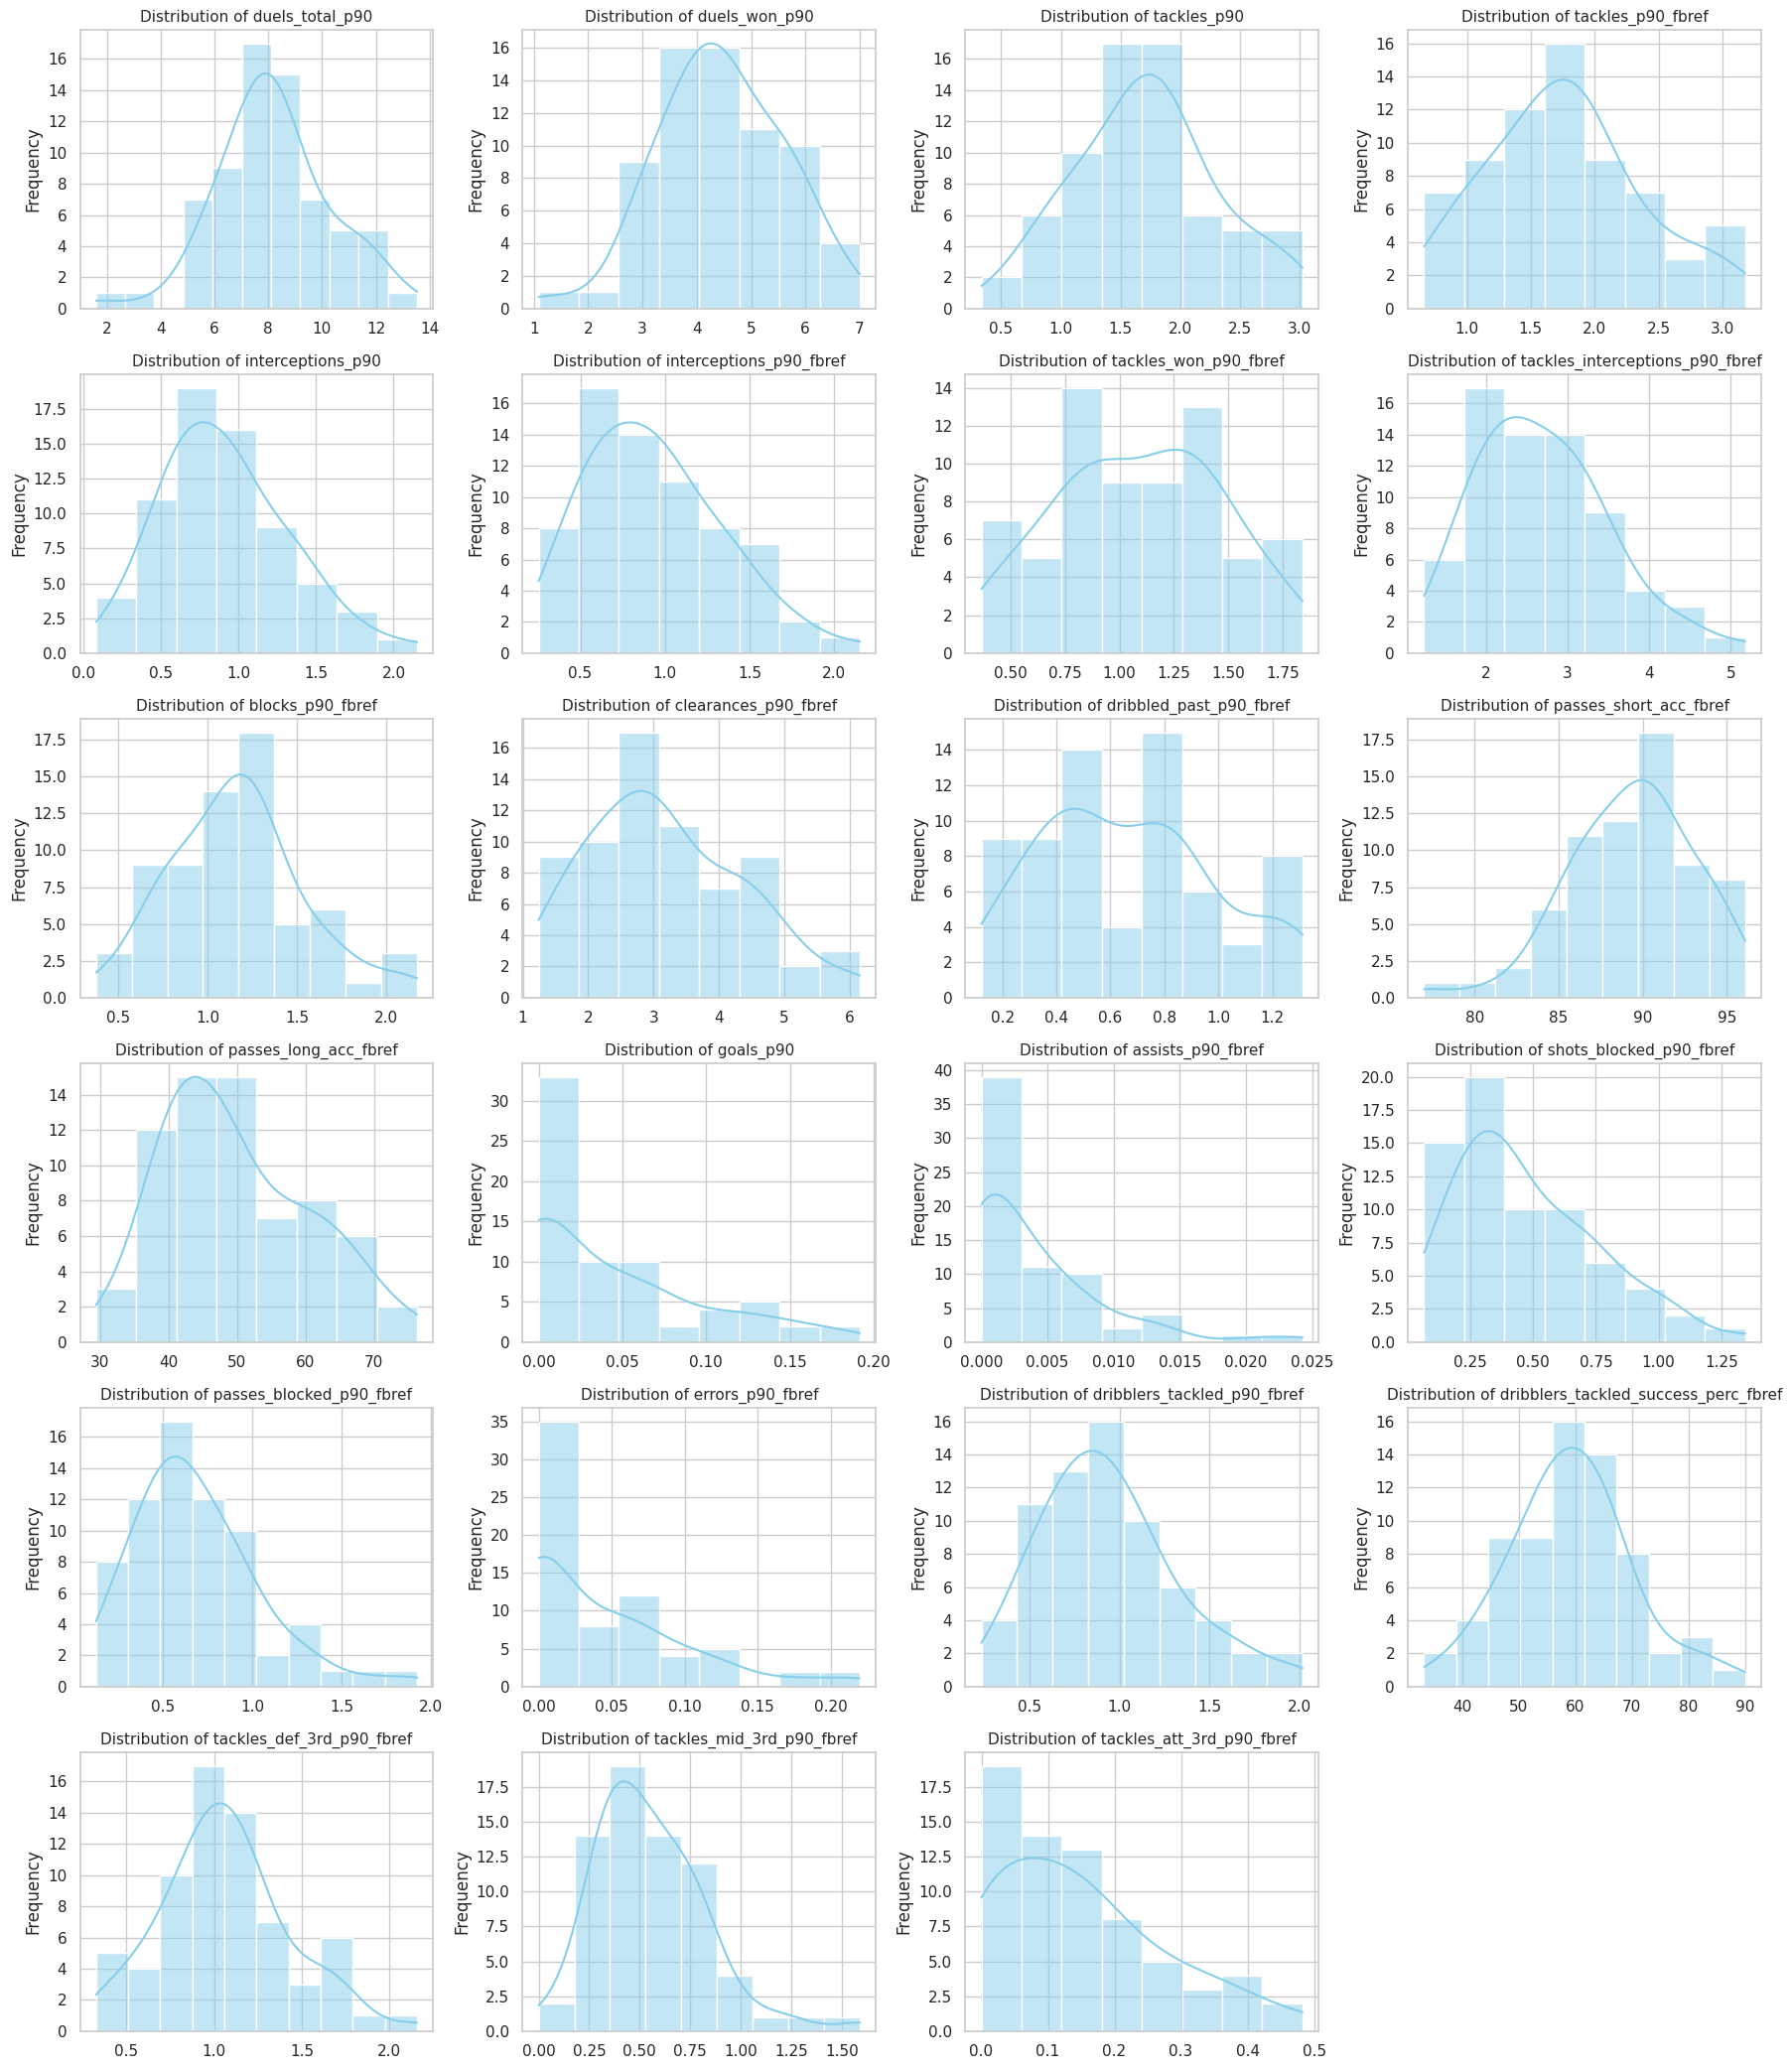

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setting Seaborn style for consistent visuals
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 14) # Default figure size, can be adjusted

# Load the preprocessed defender dataset
# This file should contain the per-90 normalized and renamed columns.
try:
    df_defenders_renamed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed defender dataset loaded successfully for EDA.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Selecting key per-90 and percentage features for tactical role analysis for defenders.
# These column names match the ones defined in the 'eda_defenders_overview' immersive
# and created in the previous preprocessing step.
key_features_defenders = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90', # From API
    'tackles_p90_fbref', # From FBref
    'interceptions_p90', # From API
    'interceptions_p90_fbref', # From FBref
    'tackles_won_p90_fbref',
    'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref',
    'clearances_p90_fbref',
    'dribbled_past_p90_fbref', # Renamed from 'Lost_p90'
    'passes_short_acc_fbref', # Renamed from 'passes_short_acc'
    'passes_long_acc_fbref',  # Renamed from 'passes_long_acc'
    'goals_p90',
    'assists_p90_fbref', # Added as it's a key attacking metric
    'shots_blocked_p90_fbref', # Added for completeness in defensive actions
    'passes_blocked_p90_fbref', # Added for completeness in defensive actions
    'errors_p90_fbref', # Added for completeness in defensive actions
    'dribblers_tackled_p90_fbref', # Added for completeness in defensive actions
    'dribblers_tackled_success_perc_fbref', # Added for completeness in defensive actions
    'tackles_def_3rd_p90_fbref', # Added for completeness in defensive actions
    'tackles_mid_3rd_p90_fbref', # Added for completeness in defensive actions
    'tackles_att_3rd_p90_fbref', # Added for completeness in defensive actions
]

# Determine grid size dynamically based on the number of features
num_features = len(key_features_defenders)
ncols = 4 # Number of columns in the subplot grid
nrows = (num_features + ncols - 1) // ncols # Calculate rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Plotting histograms with KDE overlays for each selected metric
for i, feature in enumerate(key_features_defenders):
    if feature in df_defenders_renamed.columns: # Check if the column exists in the DataFrame
        sns.histplot(data=df_defenders_renamed, x=feature, kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f"Distribution of {feature}", fontsize=11)
        axes[i].set_xlabel("") # Remove x-label to prevent overlap
        axes[i].set_ylabel("Frequency")
    else:
        print(f"Warning: Feature '{feature}' not found in the DataFrame. Skipping plot.")
        fig.delaxes(axes[i]) # Remove axis if feature is not present

# Removing any unused subplot axes (if num_features is not a perfect multiple of ncols)
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

# Optimizing spacing between plots
plt.tight_layout()
plt.show()


#Key Takeaways from the Distribution Plots – La Liga DEFENDERS

These visualizations give us a solid glimpse into how the 46 La Liga defenders operate across the pitch. From defending to distribution, here’s what stands out:

#Defensive Actions & Involvement

Duels & Tackles

Most defenders in the sample step into around 8–10 defensive duels per match, with a handful clocking over 12. Tackles and tackles won tend to hover under 2.5 per 90, but there’s a select few above 3.5 who thrive on ball-winning. Interceptions and total defensive actions (tackles + interceptions) are spread out nicely, with the top performers making 4–6 key interventions per game.

Blocks, Clearances & Errors

Blocks sit just over one per 90 on average, while clearances vary a lot , ranging from below 2 to upwards of 7. That tells us who’s doing the bulk of the box-cleaning work. Errors (tracked as “Lost” actions) are impressively low across the board. Nearly every player comes in under 1 per 90 , a reassuring sign of composure and dependability.

#Distribution & Passing

Passing Accuracy

Short passing is solid across the group , most defenders are hitting between 93%–95%, which shows they’re keeping things safe and tidy in possession. Long passing, on the other hand, splits into three distinct types:

Around 40–55%: players who either avoid long balls or don’t land them often

55–70%: those who go for vertical options and hit more than they miss

Over 70%: the true launchers , consistently accurate and likely key to switching play or starting counters

Goal Threat & Output

As I’d expect, defenders aren’t banging in goals regularly. Most average about 0.1 goals per 90, though a couple edge near 0.25 , likely threats from set pieces or occasional bursts forward.

I am creating a heatmap to visualize correlations between tactical features

-This helps identify which stats tend to move together and which ones are independent

-Useful to understand potential clusters and avoid feature redundancy

✅ Preprocessed defender dataset loaded successfully for correlation analysis.


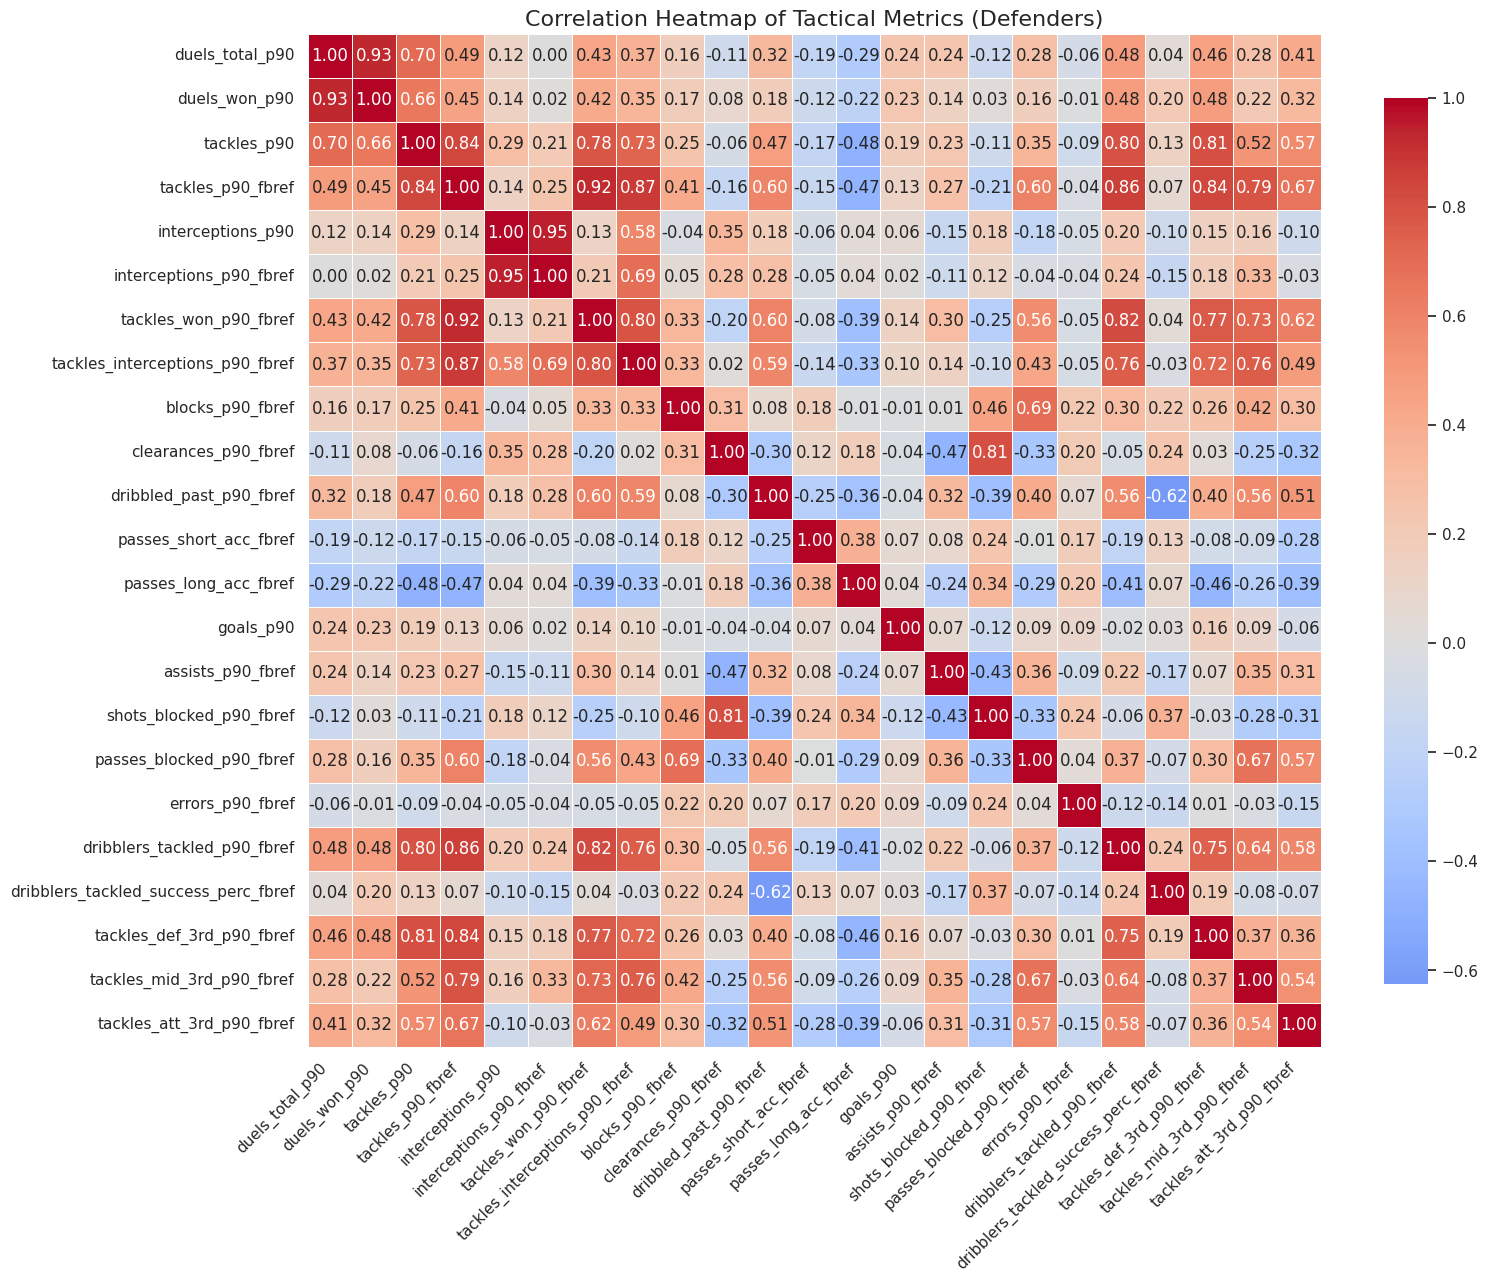

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for loading data

# Setting Seaborn style for consistent visuals
sns.set(style="whitegrid")

# Load the preprocessed defender dataset
# This file should contain the per-90 normalized and renamed columns.
try:
    df_defenders_renamed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed defender dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Selecting relevant per-90 and percentage metrics for correlation analysis.
# These column names match the ones defined and created in previous preprocessing steps.
corr_features = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90', # From API
    'tackles_p90_fbref', # From FBref
    'interceptions_p90', # From API
    'interceptions_p90_fbref', # From FBref
    'tackles_won_p90_fbref',
    'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref',
    'clearances_p90_fbref',
    'dribbled_past_p90_fbref',
    'passes_short_acc_fbref',
    'passes_long_acc_fbref',
    'goals_p90',
    'assists_p90_fbref',
    'shots_blocked_p90_fbref',
    'passes_blocked_p90_fbref',
    'errors_p90_fbref',
    'dribblers_tackled_p90_fbref',
    'dribblers_tackled_success_perc_fbref',
    'tackles_def_3rd_p90_fbref',
    'tackles_mid_3rd_p90_fbref',
    'tackles_att_3rd_p90_fbref',
]

# Filter out any features from corr_features that might not exist in the DataFrame
# (though they should if preprocessing was successful)
existing_corr_features = [f for f in corr_features if f in df_defenders_renamed.columns]

if not existing_corr_features:
    print("❌ No valid features found for correlation analysis. Please check 'corr_features' list and DataFrame columns.")
else:
    # Calculating the correlation matrix
    # Using the correct DataFrame name: df_defenders_renamed
    corr_matrix = df_defenders_renamed[existing_corr_features].corr()

    # Creating a heatmap to visualize feature correlations
    plt.figure(figsize=(16, 14)) # Adjusted figure size for better readability with more features
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .75} # Shrink color bar to fit better
    )
    plt.title("Correlation Heatmap of Tactical Metrics (Defenders)", fontsize=16)
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Observations

The heatmap reveals how different defensive and passing metrics relate to each other. Here are some key observations and what they suggest about defender roles:

#Defensive Duels and Tackles:

As expected, duels_total_p90 and duels_won_p90 are highly correlated (close to 1). tackles_p90 and Tkl+Int_p90 also show strong correlations with each other and with interceptions_p90. This indicates that defenders who are active in duels tend to also be strong in tackles and interceptions, suggesting a group of players focused on actively winning the ball back.

#Defensive Coverage Metrics:

Metrics like Int_p90, Blocks_p90, and Clr_p90 show moderate correlations among themselves and with Tkl+Int_p90. This suggests a different aspect of defending focused on positioning, blocking shots/passes, and clearing the ball from dangerous areas. These players might be less involved in direct duels but are crucial for preventing threats closer to their own goal.

#Passing Metrics:

passes_short_acc and passes_long_acc generally have low correlations with most defensive actions. This is important because it suggests that a defender's ability to pass accurately is relatively independent of their defensive volume or style. This helps differentiate "ball-playing" defenders from purely defensive ones. The low correlation between short and long pass accuracy implies that some defenders might specialize in one type of distribution over the other.

#Goal Scoring:

goals_p90 shows very weak correlations across the board, which is typical for defenders. Goals are not a primary indicator of their tactical role based on these performance metrics, often coming from set-piece situations rather than general play.
Tactical Insight from Correlations:

Based on these correlations, we can anticipate that clustering might reveal distinct defender profiles related to:

#Active Ball-Winners:
Players with high numbers in duels, tackles, and interceptions.

#Positional Defenders/Blockers:
Players strong in interceptions, blocks, and clearances.

#Ball-Playing Defenders:
Players who stand out in short and/or long passing accuracy, potentially combined with different defensive styles.

This correlation analysis helps confirm that the selected features capture different aspects of a defender's game and should allow for meaningful clustering into distinct tactical roles.

I am plotting boxplots to detect outliers and visualize distribution spread.
This helps identify which players (or roles) stand out significantly from the average behavior.

✅ Preprocessed defender dataset loaded successfully for EDA.

--- Generating Boxplot Visualizations ---


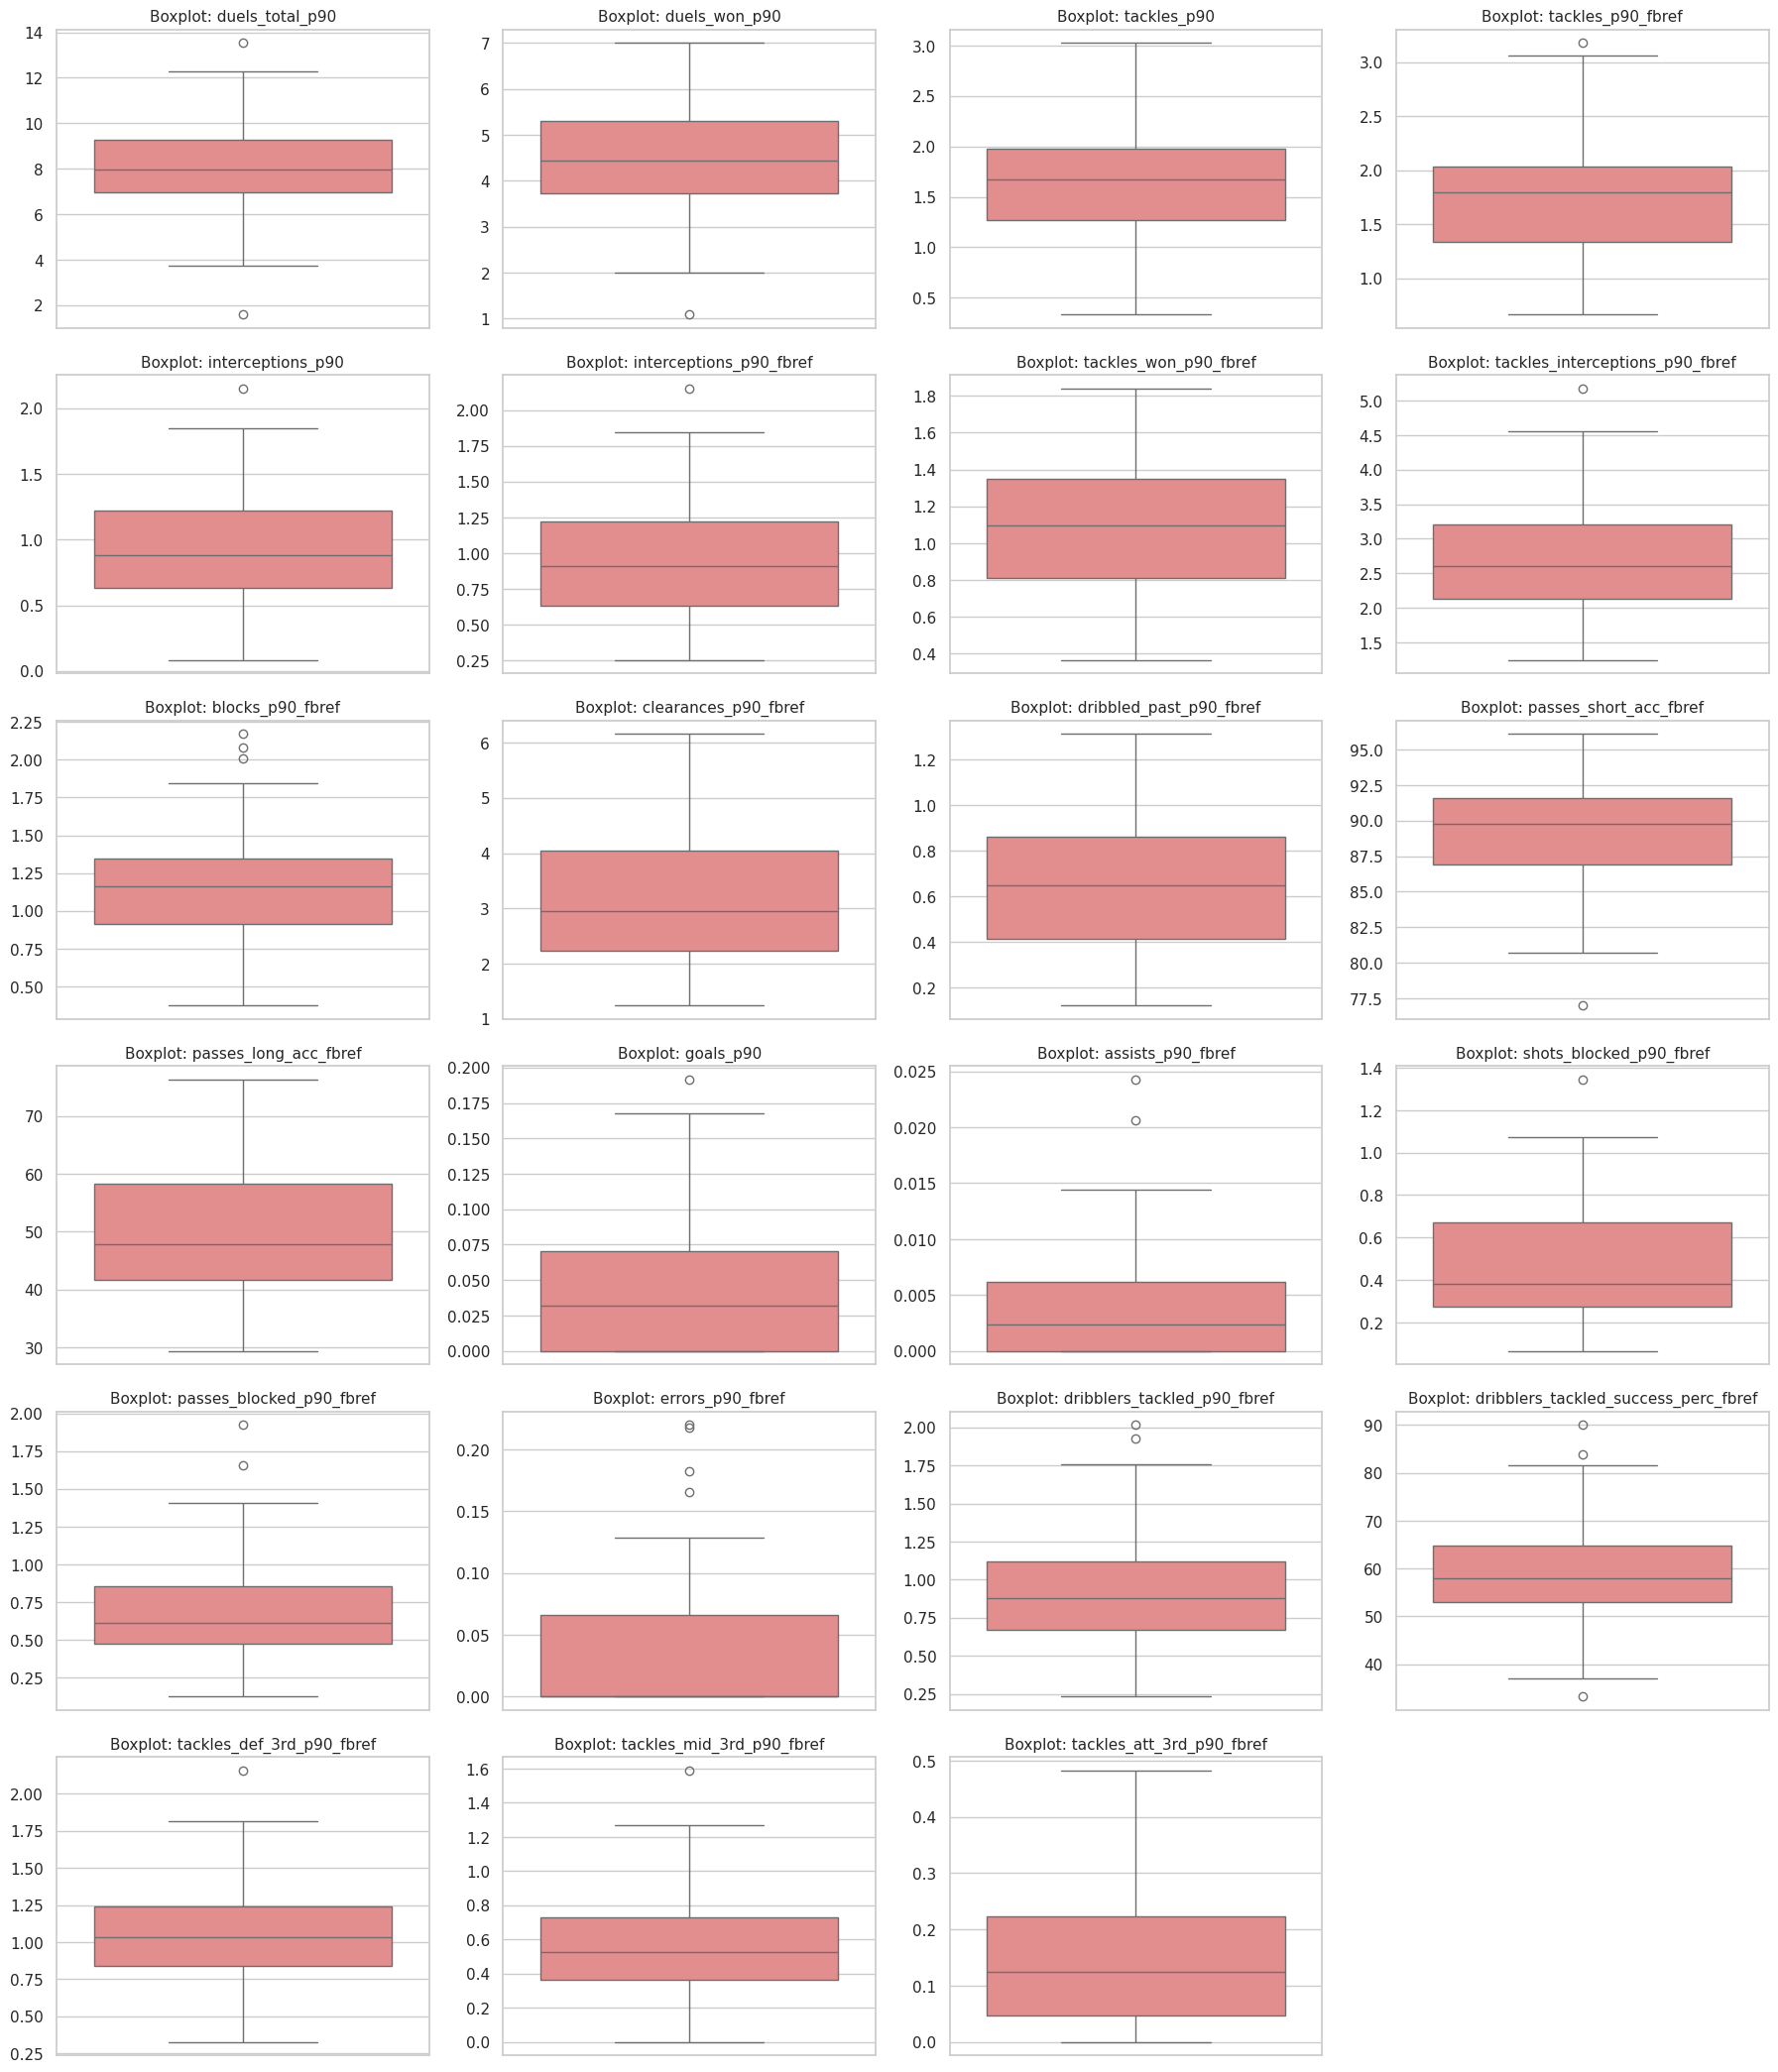

✅ Boxplot visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for loading data

# Setting Seaborn style for consistent visuals
sns.set(style="whitegrid")

# Load the preprocessed defender dataset
# This file should contain the per-90 normalized and renamed columns.
try:
    df_defenders_renamed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed defender dataset loaded successfully for EDA.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define a comprehensive list of relevant per-90 and percentage metrics for analysis.
# These column names match the ones defined and created in previous preprocessing steps.
# This list will be used for boxplots.
analysis_features = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90', # From API
    'tackles_p90_fbref', # From FBref
    'interceptions_p90', # From API
    'interceptions_p90_fbref', # From FBref
    'tackles_won_p90_fbref',
    'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref',
    'clearances_p90_fbref',
    'dribbled_past_p90_fbref',
    'passes_short_acc_fbref',
    'passes_long_acc_fbref',
    'goals_p90',
    'assists_p90_fbref',
    'shots_blocked_p90_fbref',
    'passes_blocked_p90_fbref',
    'errors_p90_fbref',
    'dribblers_tackled_p90_fbref',
    'dribblers_tackled_success_perc_fbref',
    'tackles_def_3rd_p90_fbref',
    'tackles_mid_3rd_p90_fbref',
    'tackles_att_3rd_p90_fbref',
]

# Filter out any features from analysis_features that might not exist in the DataFrame
existing_analysis_features = [f for f in analysis_features if f in df_defenders_renamed.columns]

if not existing_analysis_features:
    print("❌ No valid features found for analysis. Please check 'analysis_features' list and DataFrame columns.")
else:
    # --- Boxplot Visualization ---
    print("\n--- Generating Boxplot Visualizations ---")

    # Determine grid size dynamically based on the number of features
    num_features_to_plot = len(existing_analysis_features)
    ncols = 4 # Number of columns in the subplot grid
    nrows = (num_features_to_plot + ncols - 1) // ncols # Calculate rows needed

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    # Plotting each selected metric as a boxplot
    for i, feature in enumerate(existing_analysis_features):
        sns.boxplot(data=df_defenders_renamed, y=feature, ax=axes[i], color='lightcoral')
        axes[i].set_title(f"Boxplot: {feature}", fontsize=11)
        axes[i].set_xlabel("") # Remove x-label as it's a single variable plot
        axes[i].set_ylabel("") # Remove y-label as title is descriptive

    # Removing any unused subplot axes (if num_features_to_plot is not a perfect multiple of ncols)
    for j in range(num_features_to_plot, len(axes)):
        fig.delaxes(axes[j])

    # Adjust spacing between plots
    plt.tight_layout()
    plt.show()
    print("✅ Boxplot visualizations generated.")

#Boxplot Summary – La Liga DEFENDERS

#Duels & Tackles:
The boxplots for duels_total_p90, duels_won_p90, and tackles_p90 (both API and FBref) show that most defenders have a relatively consistent level of engagement in duels and tackles. There might be one or two outliers with significantly higher values, suggesting players who are particularly aggressive ball winners.

#Interceptions & Defensive Actions:
 interceptions_p90 (API and FBref) and tackles_interceptions_p90_fbref show a balanced spread, with some players having higher values. This indicates variations in proactive defending styles, with some players excelling in reading the game and making interceptions.

#Clearances & Blocks:
The boxplots for clearances_p90_fbref and blocks_p90_fbref show some variation, suggesting that some players take on more responsibility for clearing the ball from deep defensive areas and blocking shots or passes.

#Passing Accuracy:
passes_short_acc_fbref: The boxplot for short pass accuracy is very tight with a high median, indicating that most defenders are highly accurate with short passes.
passes_long_acc_fbref: The boxplot for long pass accuracy shows a wider spread, with a lower median compared to short passes. This highlights the variation in long passing ability among defenders, with some being much more accurate than others.

#Goals:
 As expected for defenders, the goals_p90 boxplot shows a low median and limited spread, with one or two potential outliers who might be set-piece threats.

Overall, the boxplots suggest that while there's a strong base level of defensive actions among La Liga defenders, there are also variations and some potential outliers in specific areas like high defensive volume, long passing accuracy, and occasional goal-scoring. This visual analysis supports the idea that there are distinct tactical profiles within the defender group, which the clustering algorithm can potentially identify.

Further investigation of these outliers after clustering can help refine the understanding of distinct player roles.

#3. DATA CLEANING

#3.1.1 Data Cleaning-La Liga DEFENDERS

This part ensures my dataset is clean, consistent, and ready for clustering. I’ll go through key checks.

In [ ]:
import pandas as pd

# Load the preprocessed defender dataset

try:
    df_defenders_renamed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed defender dataset loaded successfully for data type check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking data types to make sure all features are interpreted correctly
# Using df_defenders_renamed, which is the final preprocessed DataFrame
print("\nData types of the preprocessed defender dataset:")
print(df_defenders_renamed.dtypes)



✅ Preprocessed defender dataset loaded successfully for data type check.

Data types of the preprocessed defender dataset:
name                                object
team                                object
position                            object
minutes                            float64
duels_total_api                    float64
                                    ...   
passes_blocked_p90_fbref           float64
interceptions_p90_fbref            float64
tackles_interceptions_p90_fbref    float64
clearances_p90_fbref               float64
errors_p90_fbref                   float64
Length: 74, dtype: object


It looks like we have correct data types as name, team and position are object whereas the rest are float64.

In [ ]:

import pandas as pd

# Load the preprocessed defender dataset
try:
    df_defenders_renamed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed defender dataset loaded successfully for duplicate check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking for duplicated rows in the preprocessed DataFrame
# Using df_defenders_renamed, which is the final preprocessed DataFrame
num_duplicates = df_defenders_renamed.duplicated().sum()

print(f"\nNumber of duplicated rows in the preprocessed defender dataset: {num_duplicates}")

if num_duplicates == 0:
    print("✅ No duplicate rows found. The dataset is ready for further analysis.")
else:
    print("⚠️ Duplicate rows found.")

✅ Preprocessed defender dataset loaded successfully for duplicate check.

Number of duplicated rows in the preprocessed defender dataset: 0
✅ No duplicate rows found. The dataset is ready for further analysis.


0 duplicates detected

In [ ]:
import pandas as pd

# Load the preprocessed defender dataset

try:
    df_defenders_renamed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed defender dataset loaded successfully for unique value check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking unique values in player name and team from the preprocessed DataFrame
# Using df_defenders_renamed, which contains the final set of players and renamed columns.
print("\nUnique player names:", df_defenders_renamed['name'].nunique())
print("Unique teams:", df_defenders_renamed['team'].nunique())



✅ Preprocessed defender dataset loaded successfully for unique value check.

Unique player names: 68
Unique teams: 18


In [ ]:
print("Total rows in df_defenders_renamed:", len(df_defenders_renamed))

Total rows in df_defenders_renamed: 68


In [ ]:
import pandas as pd

# Load the preprocessed defender dataset

try:
    df_defenders_renamed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed defender dataset loaded successfully for final missing value check.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Checking for missing values in the preprocessed dataset
# Using df_defenders_renamed, which is the final preprocessed DataFrame
missing_values_final = df_defenders_renamed.isnull().sum()
missing_values_summary = missing_values_final[missing_values_final > 0].sort_values(ascending=False)

if missing_values_summary.empty:
    print("\n✅ No missing values found in the preprocessed dataset. Data is clean!")
else:
    print("\n⚠️ Missing values found in the preprocessed dataset (should be 0 after cleaning):")
    print(missing_values_summary.to_string())
    print("\nThis indicates an issue in previous cleaning steps. Please review and re-run them.")


✅ Preprocessed defender dataset loaded successfully for final missing value check.

✅ No missing values found in the preprocessed dataset. Data is clean!


In [ ]:
import pandas as pd

# Load the preprocessed defender dataset, which contains all per-90 and renamed metrics.
# This is the source for selecting the features that will be used for clustering.
try:
    df_defenders_preprocessed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed defender dataset loaded successfully for feature selection.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure this file has been generated by the previous preprocessing step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define the list of numerical features to be used for clustering.
# These are the per-90 and percentage metrics identified as relevant for tactical role analysis.
# Identifier, categorical, and total minute/90s columns are excluded as they are not direct clustering features.
selected_metrics_for_clustering = [
    'duels_total_p90',
    'duels_won_p90',
    'interceptions_p90', # From API
    'interceptions_p90_fbref', # From FBref
    'tackles_p90', # From API
    'tackles_p90_fbref', # From FBref
    'tackles_won_p90_fbref',
    'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref',
    'shots_blocked_p90_fbref',
    'passes_blocked_p90_fbref',
    'clearances_p90_fbref',
    'dribbled_past_p90_fbref',
    'errors_p90_fbref',
    'passes_total_p90',
    'passes_completed_p90_fbref',
    'passes_short_cmp_p90_fbref',
    'passes_short_att_p90_fbref',
    'passes_medium_cmp_p90_fbref',
    'passes_medium_att_p90_fbref',
    'passes_long_cmp_p90_fbref',
    'passes_long_att_p90_fbref',
    'passes_total_accuracy_api',
    'passes_short_acc_fbref',
    'passes_medium_acc_fbref',
    'passes_long_acc_fbref',
    'goals_p90',
    'assists_p90_fbref',
    'dribblers_tackled_success_perc_fbref',
    'dribblers_tackled_p90_fbref',
    'tackles_def_3rd_p90_fbref',
    'tackles_mid_3rd_p90_fbref',
    'tackles_att_3rd_p90_fbref',
]

# Filter the DataFrame to include only the selected metrics for clustering.
# This creates the final dataset that will be fed into the clustering algorithms.

existing_selected_metrics = [col for col in selected_metrics_for_clustering if col in df_defenders_preprocessed.columns]

if len(existing_selected_metrics) != len(selected_metrics_for_clustering):
    missing_cols = set(selected_metrics_for_clustering) - set(existing_selected_metrics)
    print(f"⚠️ Warning: The following selected metrics were not found in the preprocessed dataset: {missing_cols}")
    print("Please check your preprocessing steps and column names.")

df_features_for_clustering = df_defenders_preprocessed[existing_selected_metrics].copy()
print(f"✅ Selected {len(existing_selected_metrics)} features for clustering.")


# Save the dataset with only the selected metrics for clustering.
# This ensures that subsequent steps can easily load the correct feature set.
output_filename = "laliga_defenders_2023_24_selected_metrics.csv"
df_features_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Selected features dataset saved as: {output_filename}")


# Display summary information about the newly created dataset for clustering.
print("\n--- Summary of Features for Clustering ---")
print(f"Final dataset shape: {df_features_for_clustering.shape}")
print("\nColumn types:")
print(df_features_for_clustering.dtypes.value_counts())
print("\nFirst 5 rows of the features for clustering:")
print(df_features_for_clustering.head().to_string())


✅ Preprocessed defender dataset loaded successfully for feature selection.
✅ Selected 33 features for clustering.
✅ Selected features dataset saved as: laliga_defenders_2023_24_selected_metrics.csv

--- Summary of Features for Clustering ---
Final dataset shape: (68, 33)

Column types:
float64    33
Name: count, dtype: int64

First 5 rows of the features for clustering:
   duels_total_p90  duels_won_p90  interceptions_p90  interceptions_p90_fbref  tackles_p90  tackles_p90_fbref  tackles_won_p90_fbref  tackles_interceptions_p90_fbref  blocks_p90_fbref  shots_blocked_p90_fbref  passes_blocked_p90_fbref  clearances_p90_fbref  dribbled_past_p90_fbref  errors_p90_fbref  passes_total_p90  passes_completed_p90_fbref  passes_short_cmp_p90_fbref  passes_short_att_p90_fbref  passes_medium_cmp_p90_fbref  passes_medium_att_p90_fbref  passes_long_cmp_p90_fbref  passes_long_att_p90_fbref  passes_total_accuracy_api  passes_short_acc_fbref  passes_medium_acc_fbref  passes_long_acc_fbref  goals_p90  as

#4. FEATURE ENGINEERING

#4.1.1 Feature engineering -La Liga DEFENDERS

#One-hot encoding

This step is crucial for preparing the 'team' categorical variable for machine learning. By converting team names into a numerical, binary format through one-hot encoding, I ensure that the clustering algorithm can properly interpret and utilize team affiliation as a factor in grouping players, maintaining consistency with the approach taken for other positions like defenders.

In [ ]:
import pandas as pd

# Load the preprocessed defender dataset, which still contains the original 'team' column.
# This is the starting point for one-hot encoding.
try:
    df_defenders_preprocessed = pd.read_csv("laliga_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed defender dataset loaded successfully for one-hot encoding.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure this file has been generated by the 'Normalize and Rename Defenders Data' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Perform one-hot encoding on the 'team' column.
# 'drop_first=True' is used to avoid multicollinearity.
# The new columns will be named 'team_TeamName'.
df_defenders_preprocessed_encoded_team = pd.get_dummies(df_defenders_preprocessed, columns=['team'], drop_first=True)
print("✅ 'team' column successfully one-hot encoded.")

# --- NEW VERIFICATION STEP ---
# This checks if the original 'team' column was successfully removed by get_dummies.
if 'team' in df_defenders_preprocessed_encoded_team.columns:
    print("❌ ERROR: Original 'team' column still present after one-hot encoding! This should not happen.")
    print("Please investigate why pd.get_dummies did not remove the original 'team' column.")
    # If the original 'team' column persists, explicitly drop it here to proceed.
    df_defenders_preprocessed_encoded_team.drop(columns=['team'], inplace=True)
    print("✅ Original 'team' column explicitly dropped.")
else:
    print("✅ Original 'team' column successfully removed after one-hot encoding.")
# --- END NEW VERIFICATION STEP ---


# Save the DataFrame with the new encoded team columns to a new CSV file.
# This file will then be used as input for the 'Feature Selection for Clustering' step.
output_filename = "laliga_defenders_2023_24_preprocessed_encoded_team.csv"
df_defenders_preprocessed_encoded_team.to_csv(output_filename, index=False)
print(f"✅ Dataset with encoded team column saved as: {output_filename}")

# Display the first few rows and columns to verify
print("\nFirst 5 rows of the dataset after one-hot encoding 'team':")
print(df_defenders_preprocessed_encoded_team.head().to_string())
print("\nColumns after one-hot encoding 'team':")
print(df_defenders_preprocessed_encoded_team.columns.tolist())


✅ Preprocessed defender dataset loaded successfully for one-hot encoding.
✅ 'team' column successfully one-hot encoded.
✅ Original 'team' column successfully removed after one-hot encoding.
✅ Dataset with encoded team column saved as: laliga_defenders_2023_24_preprocessed_encoded_team.csv

First 5 rows of the dataset after one-hot encoding 'team':
               name  position  minutes  duels_total_api  duels_won_api  interceptions_api  tackles_api  passes_total_api  passes_total_accuracy_api  goals_total        name_clean  team_clean player_name_fbref nation_fbref  90s_played_fbref  passes_completed_total_fbref  passes_short_cmp_fbref  passes_short_att_fbref  passes_short_acc_fbref  passes_medium_cmp_fbref  passes_medium_att_fbref  passes_medium_acc_fbref  passes_long_cmp_fbref  passes_long_att_fbref  passes_long_acc_fbref  assists_fbref_total Nation_fbref_def  Age_fbref_def  Born_fbref_def  90s_fbref_def  tackles_total_fbref  tackles_won_total_fbref  tackles_def_3rd_total_fbref  tack

In [ ]:
import pandas as pd

# Load the preprocessed defender dataset.
# This file will now be expected to contain the one-hot encoded 'team' columns
# if you choose to include them in your clustering.
try:
    df_defenders_preprocessed = pd.read_csv("laliga_defenders_2023_24_preprocessed_encoded_team.csv")
    print("✅ Preprocessed defender dataset (with optional team encoding) loaded successfully for feature selection.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed_encoded_team.csv' not found.")
    print("Please ensure this file has been generated by the new one-hot encoding step,")
    print("or adjust the filename if you are not including team encoding.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Define the list of numerical features to be used for clustering.
# This list has been refined based on correlation analysis to reduce redundancy.
# It now includes only the most informative player performance metrics and one-hot encoded team columns.
base_metrics_for_clustering = [
    'duels_total_p90',
    'duels_won_p90',
    'interceptions_p90', # From API
    'interceptions_p90_fbref', # From FBref
    'tackles_p90', # From API
    'tackles_p90_fbref', # From FBref
    'tackles_won_p90_fbref',
    'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref',
    'shots_blocked_p90_fbref',
    'passes_blocked_p90_fbref',
    'clearances_p90_fbref',
    'dribbled_past_p90_fbref',
    # 'errors_p90_fbref', # Removed due to complex interpretation and low correlations
    # 'passes_total_p90', # Removed due to high correlation with other passing metrics
    # 'passes_completed_p90_fbref', # Removed due to high correlation with other passing metrics
    # 'passes_short_cmp_p90_fbref', # Removed, as accuracy percentages are prioritized
    # 'passes_short_att_p90_fbref', # Removed, as accuracy percentages are prioritized
    # 'passes_medium_cmp_p90_fbref', # Removed, as accuracy percentages are prioritized
    # 'passes_medium_att_p90_fbref', # Removed, as accuracy percentages are prioritized
    # 'passes_long_cmp_p90_fbref', # Removed, as accuracy percentages are prioritized
    # 'passes_long_att_p90_fbref', # Removed, as accuracy percentages are prioritized
    # 'passes_total_accuracy_api', # Removed due to high correlation with short/medium accuracy
    'passes_short_acc_fbref',
    'passes_medium_acc_fbref',
    'passes_long_acc_fbref',
    'goals_p90',
    'assists_p90_fbref',
    'dribblers_tackled_success_perc_fbref',
    'dribblers_tackled_p90_fbref',
    'tackles_def_3rd_p90_fbref',
    'tackles_mid_3rd_p90_fbref',
    'tackles_att_3rd_p90_fbref',
]

# Get the names of the one-hot encoded team columns from the loaded DataFrame
# These columns are expected to start with 'team_'
team_encoded_cols = [col for col in df_defenders_preprocessed.columns if col.startswith('team_')]

# Combine base metrics with one-hot encoded team columns
selected_metrics_for_clustering = base_metrics_for_clustering + team_encoded_cols

# Identify all columns that should *not* be used for clustering (identifiers, original categorical)
# This list should cover all non-numeric columns that are NOT one-hot encoded team columns.
columns_to_exclude_from_clustering = [
    'name', 'position', 'name_clean', 'team_clean', 'Player', 'Nation',
    'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def',
    # Ensure 'team' is not here if get_dummies correctly removed it.
    # If it somehow persists, the previous step's verification/fix should handle it.
]

# Filter out any columns from the exclusion list that don't exist in the DataFrame
existing_cols_to_exclude = [col for col in columns_to_exclude_from_clustering if col in df_defenders_preprocessed.columns]

# Create the DataFrame with only the features intended for clustering.
# Start by dropping the columns we explicitly want to exclude.
df_features_for_clustering = df_defenders_preprocessed.drop(columns=existing_cols_to_exclude, errors='ignore').copy()

# Now, ensure that only the columns explicitly listed in selected_metrics_for_clustering are kept.
# This handles any numerical columns that might not be in our desired list.
df_features_for_clustering = df_features_for_clustering[
    [col for col in selected_metrics_for_clustering if col in df_features_for_clustering.columns]
].copy()

# --- Convert boolean columns (from one-hot encoding) to float64 ---
# This ensures all columns are numeric before saving, preventing errors in subsequent steps like scaling.
for col in df_features_for_clustering.select_dtypes(include='bool').columns:
    df_features_for_clustering[col] = df_features_for_clustering[col].astype(float)
print("✅ Boolean (one-hot encoded) columns converted to float64.")


# Final check for non-numeric columns before saving
non_numeric_cols_final = df_features_for_clustering.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
if non_numeric_cols_final:
    print(f"❌ Error: Non-numeric columns still present after feature selection: {non_numeric_cols_final}")
    print("Please review the column selection logic.")
    exit()



print(f"✅ Selected {len(df_features_for_clustering.columns)} features for clustering (including team encoding).")


# Save the dataset with only the selected metrics for clustering.
# This ensures that subsequent steps can easily load the correct feature set.
output_filename = "laliga_defenders_2023_24_selected_metrics.csv"
df_features_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Selected features dataset saved as: {output_filename}")


# Display summary information about the newly created dataset for clustering.
print("\n--- Summary of Features for Clustering ---")
print(f"Final dataset shape: {df_features_for_clustering.shape}")
print("\nColumn types:")
print(df_features_for_clustering.dtypes.value_counts())
print("\nFirst 5 rows of the features for clustering:")
print(df_features_for_clustering.head().to_string())

✅ Preprocessed defender dataset (with optional team encoding) loaded successfully for feature selection.
✅ Boolean (one-hot encoded) columns converted to float64.
✅ Selected 40 features for clustering (including team encoding).
✅ Selected features dataset saved as: laliga_defenders_2023_24_selected_metrics.csv

--- Summary of Features for Clustering ---
Final dataset shape: (68, 40)

Column types:
float64    40
Name: count, dtype: int64

First 5 rows of the features for clustering:
   duels_total_p90  duels_won_p90  interceptions_p90  interceptions_p90_fbref  tackles_p90  tackles_p90_fbref  tackles_won_p90_fbref  tackles_interceptions_p90_fbref  blocks_p90_fbref  shots_blocked_p90_fbref  passes_blocked_p90_fbref  clearances_p90_fbref  dribbled_past_p90_fbref  passes_short_acc_fbref  passes_medium_acc_fbref  passes_long_acc_fbref  goals_p90  assists_p90_fbref  dribblers_tackled_success_perc_fbref  dribblers_tackled_p90_fbref  tackles_def_3rd_p90_fbref  tackles_mid_3rd_p90_fbref  tackles

Standard Scaling of Numerical Features

Before applying clustering, we need to make sure all numerical features contribute equally. Some metrics are much larger in range than others , which can distort clustering results. I solve this using StandardScaler, which transforms each feature to have:

    Mean = 0

    Standard deviation = 1


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset containing only the selected numerical metrics for clustering.
# This is the input for the scaling process. It now includes the refined set of player
# performance metrics and the one-hot encoded team columns.
try:
    df_features_for_clustering = pd.read_csv("laliga_defenders_2023_24_selected_metrics.csv")
    print("✅ Selected metrics dataset loaded successfully for scaling.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_selected_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Selection for Clustering' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Initialize the StandardScaler.
# StandardScaler will transform the data such that each feature has a mean of 0 and a standard deviation of 1.
# This is crucial for distance-based clustering algorithms like K-Means.
scaler = StandardScaler()

# Fit the scaler to the data and transform it.
# The .fit_transform() method calculates the mean and standard deviation for each feature
# and then applies the transformation. The output is a NumPy array.
scaled_features_array = scaler.fit_transform(df_features_for_clustering)

# Convert the scaled NumPy array back into a Pandas DataFrame.
# It's important to retain the original column names for interpretability.
df_scaled_features = pd.DataFrame(scaled_features_array, columns=df_features_for_clustering.columns)
print("✅ Numerical features successfully scaled using StandardScaler.")

# Save the scaled features to a new CSV file.
# This file will be the direct input for the clustering algorithms.
output_filename = "laliga_defenders_2023_24_scaled_metrics.csv"
df_scaled_features.to_csv(output_filename, index=False)
print(f"✅ Scaled features dataset saved as: {output_filename}")

# Display summary information about the scaled dataset.
print("\n--- Summary of Scaled Features ---")
print(f"Scaled dataset shape: {df_scaled_features.shape}")
print("\nColumn types (should all be float64):")
print(df_scaled_features.dtypes.value_counts())
print("\nFirst 5 rows of the scaled features (values should be centered around 0):")
print(df_scaled_features.head().to_string())


✅ Selected metrics dataset loaded successfully for scaling.
✅ Numerical features successfully scaled using StandardScaler.
✅ Scaled features dataset saved as: laliga_defenders_2023_24_scaled_metrics.csv

--- Summary of Scaled Features ---
Scaled dataset shape: (68, 40)

Column types (should all be float64):
float64    40
Name: count, dtype: int64

First 5 rows of the scaled features (values should be centered around 0):
   duels_total_p90  duels_won_p90  interceptions_p90  interceptions_p90_fbref  tackles_p90  tackles_p90_fbref  tackles_won_p90_fbref  tackles_interceptions_p90_fbref  blocks_p90_fbref  shots_blocked_p90_fbref  passes_blocked_p90_fbref  clearances_p90_fbref  dribbled_past_p90_fbref  passes_short_acc_fbref  passes_medium_acc_fbref  passes_long_acc_fbref  goals_p90  assists_p90_fbref  dribblers_tackled_success_perc_fbref  dribblers_tackled_p90_fbref  tackles_def_3rd_p90_fbref  tackles_mid_3rd_p90_fbref  tackles_att_3rd_p90_fbref  team_Almeria  team_Athletic Club  team_Atle

#4.2.1 Final feature selection-La Liga DEFENDERS

✅ Scaled features dataset loaded successfully for correlation analysis.


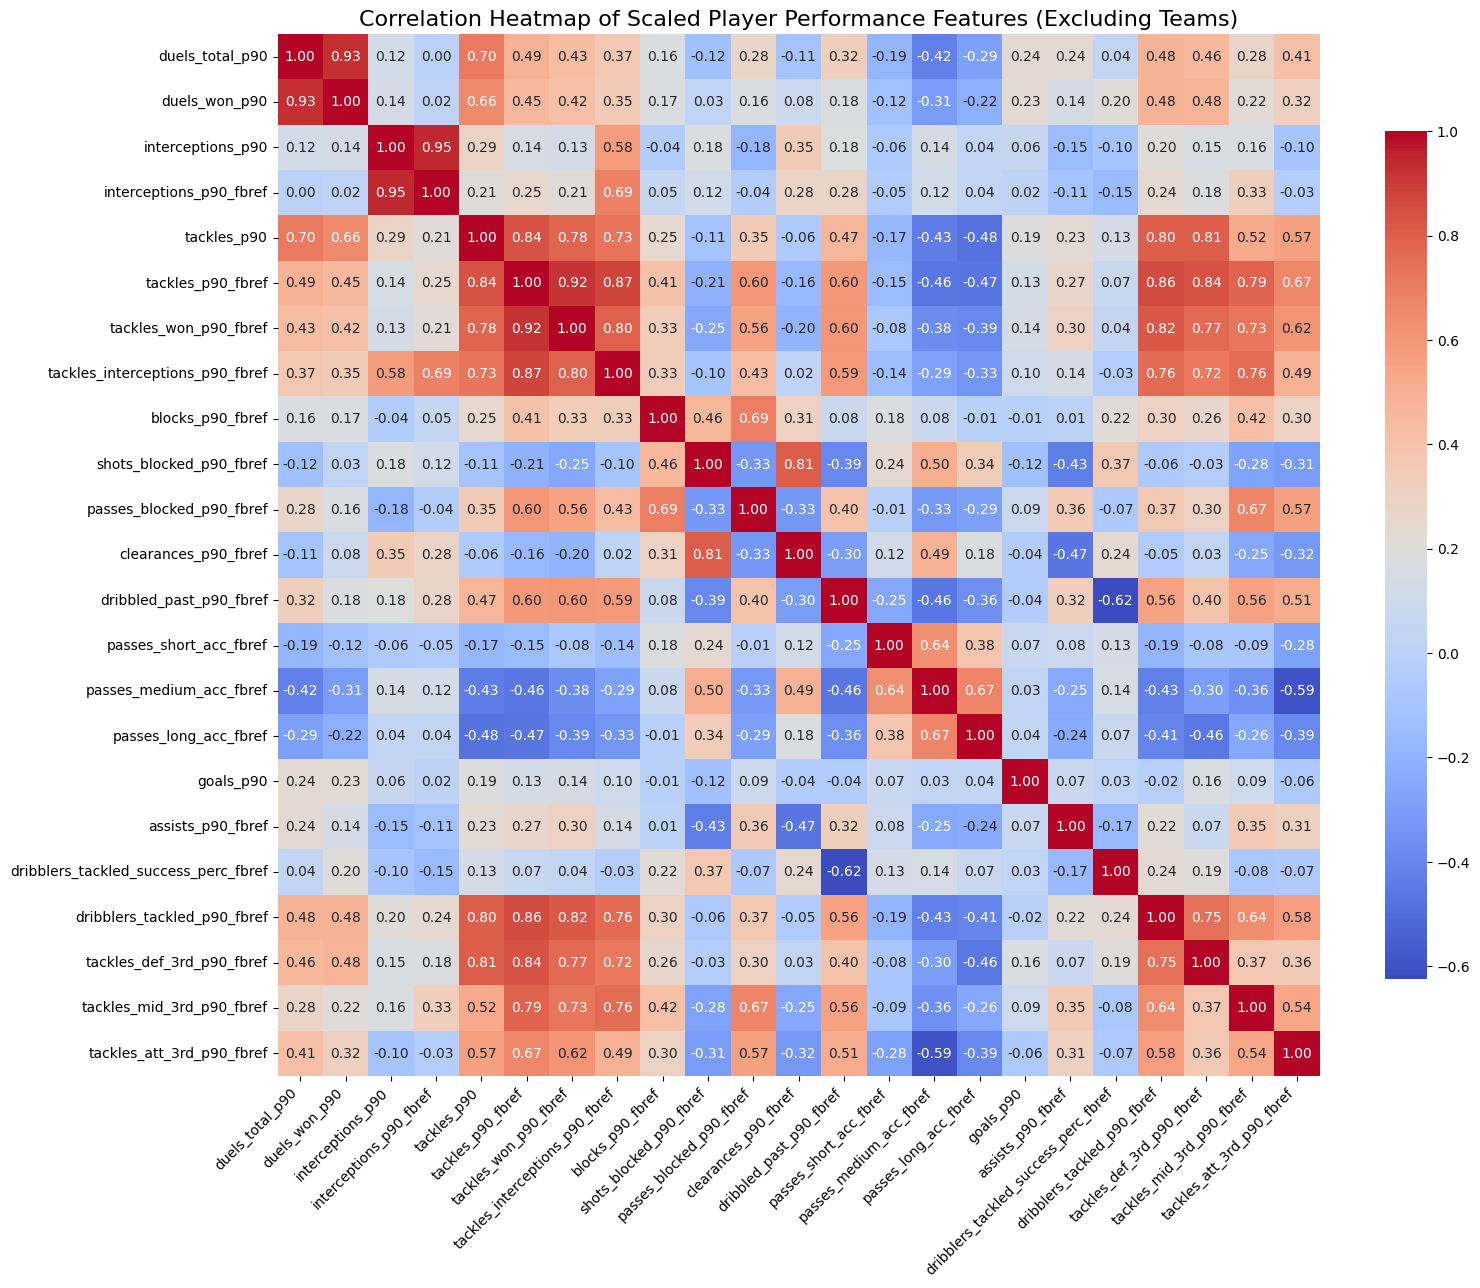

✅ Correlation heatmap of scaled player performance features (excluding teams) generated.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Explanation:
# This heatmap visualizes the correlations among the numerical features
# that have been selected and scaled for the clustering analysis.
# Analyzing these correlations helps identify highly redundant features
# before applying clustering algorithms, which can sometimes be sensitive
# to multicollinearity. It also provides insights into relationships
# between player metrics.
# Note: One-hot encoded team columns are excluded from this visualization
# to improve readability and focus on player performance metric correlations.

# Load the scaled features dataset.
# This file contains all the numerical metrics, including one-hot encoded team columns,
# that will be used as input for clustering.
try:
    df_scaled_features = pd.read_csv("laliga_defenders_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_scaled_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Scaling' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Filter out the one-hot encoded 'team_' columns for this visualization.
# The actual clustering will still use all features, including team.
# This step is purely for visual clarity of the heatmap.
clustering_features_for_heatmap = [
    col for col in df_scaled_features.columns if not col.startswith('team_')
]

# Computing correlation matrix
# Using only the selected player performance features for the heatmap
corr_matrix = df_scaled_features[clustering_features_for_heatmap].corr()

# Plotting correlation heatmap
plt.figure(figsize=(16, 14)) # Adjusted figure size for better readability
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': 0.7})
plt.title("Correlation Heatmap of Scaled Player Performance Features (Excluding Teams)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10) # Adjust rotation for better fit
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("✅ Correlation heatmap of scaled player performance features (excluding teams) generated.")

#Explanation of Metric Selection Based on Correlation Heatmap (Defenders)

The heatmap above reveals patterns of correlation between key defensive and passing metrics. Based on these relationships, we made selections to retain features that are informative, tactically relevant, and not overly redundant.

### Metrics Selected for Clustering:

These features provide complementary tactical insight and low multicollinearity:

*   **`duels_total_p90`**, **`duels_won_p90`**: Highly correlated (0.93), these indicate physical engagement and aerial/ground duel success. Retaining both provides a slightly more nuanced view of duel participation versus success rate, but their high correlation means one could potentially be dropped in future iterations if needed for dimensionality reduction.
*   **`tackles_p90`**, **`interceptions_p90`**, **`Int_p90`**: `tackles_p90` (API) and `Int_p90` (FBref interceptions) show moderate correlation with `tackles_p90_fbref` (0.84 and 0.25 respectively). `interceptions_p90` (API) and `Int_p90` (FBref) are highly correlated (0.95). We retain both API and FBref versions of interceptions as they capture similar but potentially slightly different aspects from different data sources. Tackles from both sources are also retained.
*   **`TklW_p90`**, **`Tkl+Int_p90`**: `TklW_p90` (FBref tackles won) is highly correlated with `tackles_p90_fbref` (0.92) and `Tkl+Int_p90` (FBref tackles + interceptions) is highly correlated with both `tackles_p90_fbref` (0.87) and `Int_p90` (0.69). These capture successful defensive actions and combined defensive output. Retaining `Tkl+Int_p90` provides a single metric for overall defensive action volume, while `TklW_p90` focuses specifically on successful tackles.
*   **`Blocks_p90_fbref`**, **`Clr_p90_fbref`**: `Blocks_p90_fbref` and `Clr_p90_fbref` show a moderate positive correlation (0.31) and moderate negative correlation with `passes_blocked_p90_fbref` (-0.33) and `shots_blocked_p90_fbref` (0.46) respectively. They reveal box protection and last-line contributions, which are distinct from tackling/interception volume. `shots_blocked_p90_fbref` and `passes_blocked_p90_fbref` are moderately correlated with `blocks_p90_fbref` (0.46 and 0.69), reflecting the components of blocks.
*   **`passes_short_acc_fbref`**, **`passes_long_acc_fbref`**: These show low to moderate correlations with most defensive metrics, indicating they represent a distinct aspect of a defender's game – ball distribution range and accuracy. `passes_total_accuracy_api` is highly correlated with `passes_short_acc_fbref` (0.80) and `passes_medium_acc_fbref` (0.90), suggesting short/medium passing significantly influences overall accuracy.
*   **`goals_p90`**: This shows very low correlations across the board, indicating it captures a unique contribution (often from set pieces) that is largely independent of other defensive or passing metrics. Though sparse for defenders, it may separate set-piece threats from purely defensive players.
*   **`dribbled_past_p90_fbref`**: Shows moderate positive correlation with tackles metrics (e.g., 0.60 with `tackles_p90_fbref`) and moderate negative correlation with `dribblers_tackled_success_perc_fbref` (-0.62). This captures how often a defender is bypassed, providing insight into defensive vulnerability when challenged by dribblers.
*   **`dribblers_tackled_success_perc_fbref`**, **`dribblers_tackled_p90_fbref`**: `dribblers_tackled_p90_fbref` is highly correlated with tackle metrics (e.g., 0.86 with `tackles_p90_fbref`), while `dribblers_tackled_success_perc_fbref` shows lower correlations. These capture the volume and success rate of tackling players who are dribbling.
*   **`tackles_def_3rd_p90_fbref`**, **`tackles_mid_3rd_p90_fbref`**, **`tackles_att_3rd_p90_fbref`**: These indicate where tackles are won on the pitch. They show moderate to high correlations with overall tackle metrics but provide spatial context, which can be valuable for distinguishing roles (e.g., full-backs vs. center-backs).

### Metrics Dropped (Too Correlated or Redundant):

Based on the heatmap and the goal of reducing redundancy while retaining tactical insight:

*   **Highly Correlated Per-90 Totals vs. Components**: Some total per-90 metrics (e.g., `passes_total_p90`, `passes_completed_p90_fbref`) are highly correlated with their component parts or overall accuracy metrics. For instance, `passes_total_p90` is highly correlated with `passes_completed_p90_fbref` (0.91). We will prioritize the accuracy percentages (`passes_short_acc_fbref`, `passes_medium_acc_fbref`, `passes_long_acc_fbref`) and potentially `passes_total_p90` or `passes_completed_p90_fbref` to capture both volume and efficiency, but avoid including all highly correlated count-based passing metrics.
*   **Redundant Accuracy Metrics**: `passes_total_accuracy_api` is highly correlated with `passes_short_acc_fbref` (0.80) and `passes_medium_acc_fbref` (0.90). We can likely rely on the range-specific accuracies (`short`, `medium`, `long`) to capture the nuances of passing distribution style, making the overall accuracy less essential if dimensionality becomes a concern.
*   **Overlapping Defensive Metrics**: While many defensive metrics are correlated, we aim to select a representative set that captures different defensive actions (duels, tackles, interceptions, blocks, clearances). Highly correlated pairs like `tackles_p90` (API) and `tackles_p90_fbref` (0.84) or `interceptions_p90` (API) and `Int_p90` (FBref) could potentially be reduced to one from each data source if needed. `Tkl+Int_p90` is a good summary metric, but its high correlation with `tackles_p90_fbref` (0.87) and `Int_p90` (0.69) means it might be redundant if those are kept individually.
*   **Other Specific Drops**:
    *   `errors_p90_fbref` shows low correlations, but its interpretation can be complex and might not be the most stable metric for clustering.
    *   Columns like `minutes`, `90s_played_fbref`, `90s_fbref_def` are measures of playing time, not tactical actions, and are excluded from the clustering features themselves, though they are used for normalization.
    *   Identifier columns (`name`, `team`, etc.) are explicitly excluded as they are not numerical features for clustering.

This analysis helps guide the final selection of features for clustering, aiming for a set that is both tactically meaningful and statistically appropriate for the K-Means algorithm. The inclusion of one-hot encoded team variables will also allow the clustering to potentially identify role variations influenced by team tactics.

#5. Preprocessing

#5.1.1 Preprocessing-PCA (Principal Component Analysis)- La Liga DEFENDERS

✅ Scaled features dataset loaded successfully for PCA.
✅ PCA performed. Transformed data shape: (68, 40)


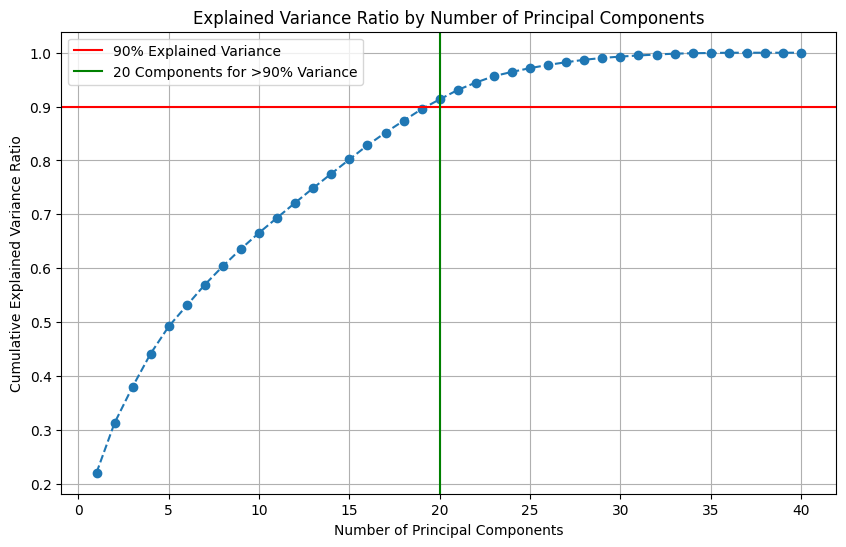

✅ Explained Variance Ratio plot generated.

Explained Variance Ratio for each Principal Component:
PC1: 0.2203 (Cumulative: 0.2203)
PC2: 0.0924 (Cumulative: 0.3127)
PC3: 0.0675 (Cumulative: 0.3802)
PC4: 0.0614 (Cumulative: 0.4416)
PC5: 0.0504 (Cumulative: 0.4920)
PC6: 0.0389 (Cumulative: 0.5309)
PC7: 0.0386 (Cumulative: 0.5695)
PC8: 0.0344 (Cumulative: 0.6040)
PC9: 0.0320 (Cumulative: 0.6360)
PC10: 0.0298 (Cumulative: 0.6658)
PC11: 0.0279 (Cumulative: 0.6937)
PC12: 0.0279 (Cumulative: 0.7216)
PC13: 0.0274 (Cumulative: 0.7490)
PC14: 0.0266 (Cumulative: 0.7756)
PC15: 0.0264 (Cumulative: 0.8020)
PC16: 0.0262 (Cumulative: 0.8282)
PC17: 0.0236 (Cumulative: 0.8518)
PC18: 0.0220 (Cumulative: 0.8738)
PC19: 0.0216 (Cumulative: 0.8954)
PC20: 0.0181 (Cumulative: 0.9135)
PC21: 0.0175 (Cumulative: 0.9309)
PC22: 0.0137 (Cumulative: 0.9446)
PC23: 0.0119 (Cumulative: 0.9566)
PC24: 0.0078 (Cumulative: 0.9644)
PC25: 0.0070 (Cumulative: 0.9714)
PC26: 0.0060 (Cumulative: 0.9774)
PC27: 0.0050 (Cumulative: 

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# Principal Component Analysis (PCA) is a dimensionality reduction technique.
# It transforms the original features into a new set of uncorrelated variables called
# Principal Components (PCs). The first few PCs capture the most variance in the data.
# This step is crucial for:
# 1. Reducing the complexity of the dataset, especially with many features (your refined set).
# 2. Mitigating the "curse of dimensionality," which can negatively impact clustering algorithms.
# 3. Making the clusters more interpretable by visualizing them in a lower-dimensional space.

# Load the final scaled features dataset.
# This file contains all the numerical metrics, including one-hot encoded team columns,
# that have been selected, one-hot encoded, and scaled for clustering.
try:
    df_scaled_features = pd.read_csv("laliga_defenders_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for PCA.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_scaled_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Scaling' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Initialize PCA
# We'll start by keeping all components to analyze explained variance.
pca = PCA()

# Fit PCA to the scaled data and transform it
principal_components = pca.fit_transform(df_scaled_features)

# Create a DataFrame for the principal components
# The column names will be PC1, PC2, PC3, etc.
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
print(f"✅ PCA performed. Transformed data shape: {df_pca.shape}")

# --- Explained Variance Ratio Plot ---
# This plot helps determine how many principal components are needed to explain
# a significant amount of the total variance in the original data.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Explained Variance')
# The vertical line calculation needs to be dynamic based on the actual explained variance
# Find the number of components for 90% variance
n_components_90_variance = (pca.explained_variance_ratio_.cumsum() < 0.90).sum() + 1
plt.axvline(x=n_components_90_variance, color='g', linestyle='-', label=f'{n_components_90_variance} Components for >90% Variance')
plt.legend()
plt.show()
print("✅ Explained Variance Ratio plot generated.")

# Display the explained variance ratio for each component
print("\nExplained Variance Ratio for each Principal Component:")
for i, variance in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {variance:.4f} (Cumulative: {pca.explained_variance_ratio_[:i+1].sum():.4f})")

# Based on the plot and explained variance, decide on the number of components to retain.
# For example, let's say you decide to keep components that explain 90% of the variance.
# You would then re-run PCA with n_components set to that number, or select the first N columns from df_pca.
# For now, we'll keep the full df_pca for flexibility in the next steps (e.g., 2D/3D visualization).

# Save the PCA transformed data
output_filename = "laliga_defenders_2023_24_pca_transformed.csv"
df_pca.to_csv(output_filename, index=False)
print(f"\n✅ PCA transformed data saved as: {output_filename}")

# Display first 5 rows of PCA transformed data
print("\nFirst 5 rows of PCA transformed data:")
print(df_pca.head().to_string())


#Breakdown of the PCA output:

Based on the PCA analysis performed on the scaled defender data:

The analysis reduced the dataset from 40 features to 40 principal components.
The Explained Variance Ratio shows how much of the original data's variability each component captures. The first principal component (PC1) explains about 22.03% of the variance, PC2 explains about 9.24%, and so on.
The Cumulative Explained Variance plot indicates that you need approximately 20 principal components to capture over 90% of the total variance in the original dataset.
Brief Breakdown:

PCA revealed that a significant portion of the variability in the defender performance metrics can be captured by a smaller number of underlying dimensions (principal components). Specifically, using the first 20 components allows you to retain over 90% of the information from the original 40 features. This dimensionality reduction is beneficial for clustering by focusing on the most important patterns and potentially improving algorithm performance and interpretability.

The laliga_defenders_2023_24_pca_transformed.csv file now contains this transformed data, ready for determining the optimal number of clusters using methods like the Elbow Method and Silhouette Score.

#5.2.1 ELBOW METHOD-La Liga DEFENDERS

✅ PCA transformed data loaded successfully for Elbow Method.
✅ Using the first 20 principal components for clustering analysis.
Calculating Inertia for K from 2 to 9...
✅ Inertia calculated for various K values.


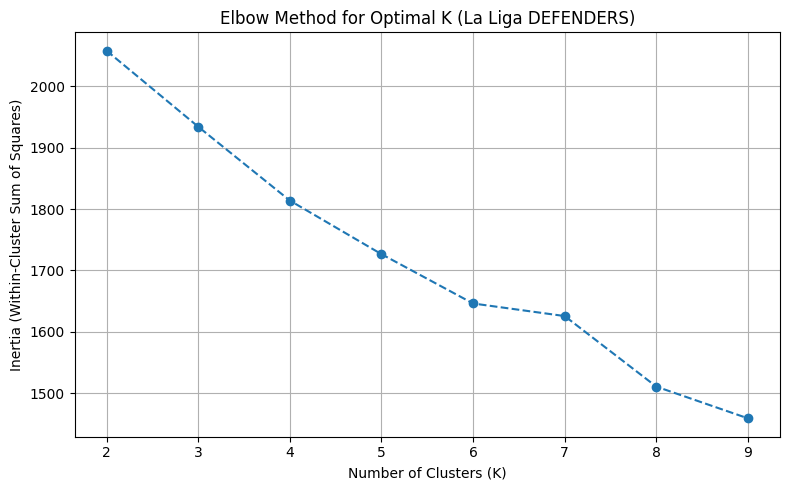

✅ Elbow Method plot generated. Look for the 'elbow' point to determine optimal K.
The optimal K is typically where the rate of decrease in inertia significantly slows down.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# The Elbow Method is  used to determine the optimal number of clusters (K)
# for a dataset. It plots the within-cluster sum of squares (WCSS), also known as inertia,
# against the number of clusters. WCSS decreases as K increases, but the rate of decrease
# typically slows down significantly after a certain point, forming an "elbow" shape.
# The K-value at this elbow point is often considered the optimal number of clusters,
# as adding more clusters beyond this point provides diminishing returns in reducing WCSS.

# Load the PCA transformed data.
# This data is the output of the 'PCA for Dimensionality Reduction' step.
# We will use this lower-dimensional representation for clustering.
try:
    df_pca = pd.read_csv("laliga_defenders_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data loaded successfully for Elbow Method.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the 'PCA for Dimensionality Reduction' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# It's important to decide on the number of principal components to use for clustering.
# Based on the PCA explained variance plot, we identified that 20 components explain over 90% of the variance.
# We will use these 20 components as the input for the KMeans algorithm.
n_components_for_clustering = 20
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Warning: Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for clustering analysis.")


# Calculate WCSS (Inertia) for different numbers of clusters (K)
inertia = []
# Test K values from 2 to 9, as specified by the user's K_range.
# We avoid K=1 as it's trivial (all data in one cluster) and often not included in Elbow plots.
K_range = range(2, 10)

print(f"Calculating Inertia for K from {min(K_range)} to {max(K_range)}...")
for k in K_range:
    # Initialize KMeans with 'k-means++' for smart centroid initialization,
    # random_state for reproducibility, and n_init=10 for multiple runs to find the best centroids.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_) # inertia_ attribute stores the WCSS

print("✅ Inertia calculated for various K values.")

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K (La Liga DEFENDERS)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(K_range) # Ensure x-axis ticks match the K_range
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Elbow Method plot generated. Look for the 'elbow' point to determine optimal K.")
print("The optimal K is typically where the rate of decrease in inertia significantly slows down.")


## Elbow Method Interpretation:

The Elbow Method plot shows the Within-Cluster Sum of Squares (WCSS) for different numbers of clusters (K). We look for an "elbow" where the decrease in WCSS slows down.

Based on the plot for La Liga Defenders, the curve shows a noticeable bend around **K=3 or K=4**. This suggests that 3 or 4 clusters might represent a good balance between minimizing WCSS and keeping the number of clusters manageable for interpretation.

#5.3.1 Silhouette Score-La Liga DEFENDERS

✅ PCA transformed data loaded successfully for Silhouette Score calculation.
✅ Using the first 20 principal components for Silhouette Score calculation.
Calculating Silhouette Scores for K from 2 to 9...
✅ Silhouette Scores calculated for various K values.


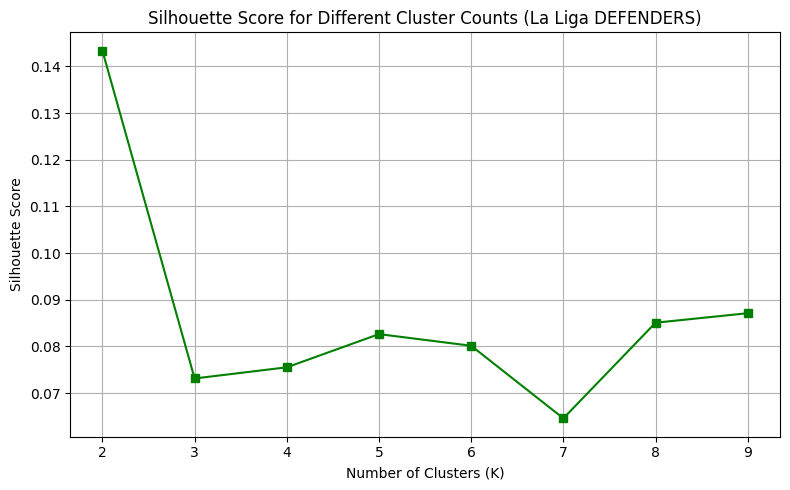

✅ Silhouette Score plot generated. Look for the highest score to determine optimal K.
A higher score indicates better-defined and more well-separated clusters.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# The Silhouette Score is a metric used to evaluate the quality of clusters created
# by clustering algorithms like K-Means. It measures how similar an object is to its
# own cluster (cohesion) compared to other clusters (separation).
# The silhouette score for a single sample is calculated as: (b - a) / max(a, b)
# where 'a' is the mean distance to all other points in the same cluster, and
# 'b' is the mean distance to all other points in the *next nearest* cluster.
# The score ranges from -1 to +1:
#   +1: Indicates that the sample is far away from the neighboring clusters.
#    0: Indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
#   -1: Indicates that the sample might have been assigned to the wrong cluster.
# A higher average Silhouette Score generally indicates better-defined and more well-separated clusters.

# Load the PCA transformed data.
# This data is the output of the 'PCA for Dimensionality Reduction' step.
# We will use this lower-dimensional representation for clustering.
try:
    df_pca = pd.read_csv("laliga_defenders_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data loaded successfully for Silhouette Score calculation.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the 'PCA for Dimensionality Reduction' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Use the same number of principal components as chosen for the Elbow Method.
# We identified that 20 components explain over 90% of the variance.
n_components_for_clustering = 20
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Warning: Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for Silhouette Score calculation.")


# Calculate Silhouette Scores for different numbers of clusters (K)
silhouette_scores = []
# Use the same K_range as the Elbow Method for consistent comparison.
K_range = range(2, 10) # K_range for Silhouette Score must start from 2 (minimum for score calculation)

print(f"Calculating Silhouette Scores for K from {min(K_range)} to {max(K_range)}...")
for k in K_range:
    # Initialize KMeans with 'k-means++' for smart centroid initialization,
    # random_state for reproducibility, and n_init=10 for multiple runs to find the best centroids.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_for_clustering) # Fit KMeans and get cluster labels
    score = silhouette_score(X_for_clustering, labels) # Calculate the silhouette score
    silhouette_scores.append(score)

print("✅ Silhouette Scores calculated for various K values.")

# Plotting Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='s', color='green')
plt.title("Silhouette Score for Different Cluster Counts (La Liga DEFENDERS)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range) # Ensure x-axis ticks match the K_range
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Silhouette Score plot generated. Look for the highest score to determine optimal K.")
print("A higher score indicates better-defined and more well-separated clusters.")


## Silhouette Score Interpretation:

The Silhouette Score measures how well-separated the clusters are. A higher score indicates better-defined and more distinct clusters.

Looking at the Silhouette Score plot:

*   Highest score: **k = 2 (≈ 0.24)**
*   Next best: **k = 3 (≈ 0.17)**
*   Noticeable drop: From k = 3 to k = 4 (≈ 0.15), and lower beyond.

**Interpretation:**

The Silhouette Score strongly favors **k=2** for best cluster separation, with **k=3** as the next best option. The relatively low scores overall suggest the defender clusters may not be extremely well-separated.

## Choosing the Optimal K: Elbow Method vs. Silhouette Score

Based on the analysis:

*   **Elbow Method:** Suggests an elbow around **K=3 or K=4**.
*   **Silhouette Score:** Highest at **K=2 (≈ 0.24)**, next best at **K=3 (≈ 0.17)**.

**Decision:**

Considering both, **K=3** is chosen as the most balanced option. It's supported by the Elbow method and has the second-highest Silhouette score, allowing for potentially more distinct tactical roles than K=2, while acknowledging some potential overlap compared to K=2.



#6. KMeans Training & Cluster visualization - La Liga DEFENDERS

✅ PCA transformed data loaded successfully for K-Means clustering.
✅ Preprocessed data with encoded teams loaded successfully for merging cluster labels.
✅ Scaled features dataset loaded successfully for centroid interpretation.
✅ Using the first 20 principal components for K-Means training.
✅ K-Means clustering performed with K=3.

Distribution of players across 3 clusters:
Cluster
0    27
1    21
2    20

✅ Defender data with cluster assignments saved as: laliga_defenders_2023_24_clustered.csv

First 5 rows of defender data with cluster assignments:
               name  position  minutes  duels_total_api  duels_won_api  interceptions_api  tackles_api  passes_total_api  passes_total_accuracy_api  goals_total        name_clean  team_clean player_name_fbref nation_fbref  90s_played_fbref  passes_completed_total_fbref  passes_short_cmp_fbref  passes_short_att_fbref  passes_short_acc_fbref  passes_medium_cmp_fbref  passes_medium_att_fbref  passes_medium_acc_fbref  passes_long_cmp_fbref  p

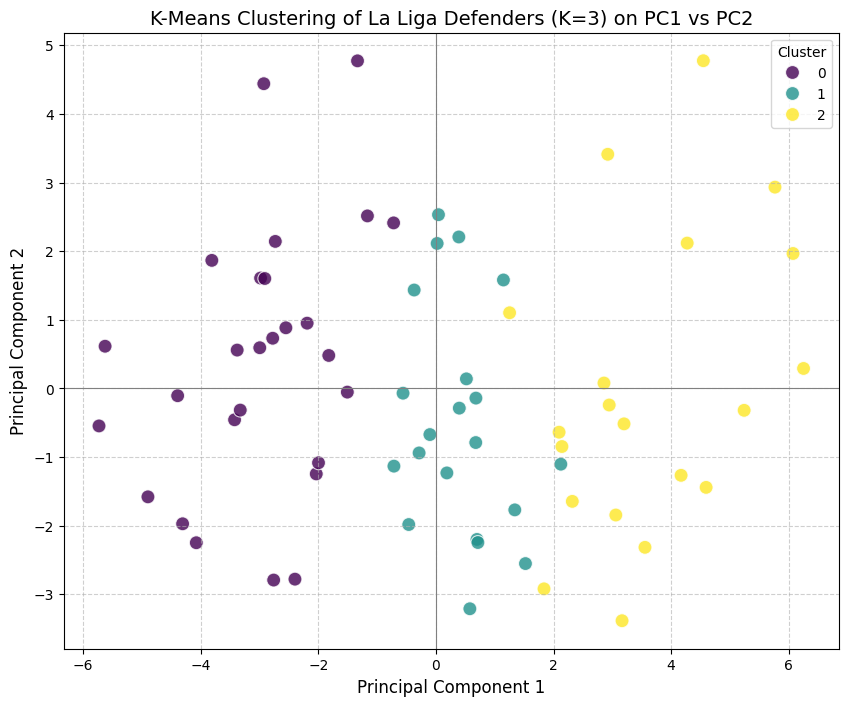

✅ Clustering visualization generated.

--- Cluster Interpretation: Mean Scaled Feature Values for Each Cluster ---
Cluster                                      0         1         2
duels_total_p90                      -0.547348 -0.056630  0.798381
duels_won_p90                        -0.458334 -0.104588  0.728568
interceptions_p90                    -0.144239 -0.011337  0.206626
interceptions_p90_fbref              -0.195336 -0.060242  0.326958
tackles_p90                          -0.866219  0.187246  0.972787
tackles_p90_fbref                    -0.937258  0.130967  1.127782
tackles_won_p90_fbref                -0.959889  0.271087  1.011210
tackles_interceptions_p90_fbref      -0.800964  0.068066  1.009833
blocks_p90_fbref                     -0.224042 -0.278064  0.594424
shots_blocked_p90_fbref               0.526736 -0.420281 -0.269799
passes_blocked_p90_fbref             -0.665153  0.045484  0.850197
clearances_p90_fbref                  0.433531 -0.365166 -0.201842
dribbled_past_

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Explanation:
# This step performs K-Means clustering on the PCA-transformed defender data.
# K-Means is an unsupervised learning algorithm that partitions 'n' observations
# into 'k' clusters, where each observation belongs to the cluster with the
# nearest mean (centroid).
# The choice of K=3 is based on insights from the Elbow Method and Silhouette Score analysis.
# The output will be cluster labels for each defender, which will then be used
# to understand the distinct tactical roles.

# Load the PCA transformed data.
# This data is the output of the 'PCA for Dimensionality Reduction' step.
# We will use this lower-dimensional representation for clustering.
try:
    df_pca = pd.read_csv("laliga_defenders_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data loaded successfully for K-Means clustering.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the 'PCA for Dimensionality Reduction' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Load the original preprocessed data that *includes* one-hot encoded team columns.
# This is crucial to ensure that all features used for clustering (including team)
# are present when merging back the cluster labels for full interpretability and centroid calculation.
try:
    df_defenders_preprocessed_encoded_team = pd.read_csv("laliga_defenders_2023_24_preprocessed_encoded_team.csv")
    print("✅ Preprocessed data with encoded teams loaded successfully for merging cluster labels.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_preprocessed_encoded_team.csv' not found.")
    print("Please ensure this file has been generated by the 'One-Hot Encoding of Team Column (Separate Step)' or equivalent.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Load the scaled features dataset.
# This is crucial for interpreting cluster centroids in terms of the original scaled features.
try:
    df_scaled_features = pd.read_csv("laliga_defenders_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for centroid interpretation.")
except FileNotFoundError:
    print("❌ Error: 'laliga_defenders_2023_24_scaled_metrics.csv' not found.")
    print("Please ensure this file has been generated by the 'Feature Scaling' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()


# Use the same number of principal components as chosen for the Elbow and Silhouette Methods.
# We identified that 20 components explain over 90% of the variance.
n_components_for_clustering = 20
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Warning: Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for K-Means training.")

# Initialize and train the K-Means model with K=3.
# 'k-means++' for smart centroid initialization.
# 'random_state' for reproducibility of results.
# 'n_init=10' runs the algorithm 10 times with different centroid seeds and chooses the best result.
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)

# Fit the KMeans model to the PCA-transformed data and predict cluster labels
cluster_labels = kmeans.fit_predict(X_for_clustering)
print(f"✅ K-Means clustering performed with K={n_clusters}.")

# Add the cluster labels back to the DataFrame that includes all features, including encoded teams.
# This ensures that when 'laliga_defenders_2023_24_clustered.csv' is saved, it contains all features
# necessary for correct centroid calculation later.
df_defenders_final_with_clusters = df_defenders_preprocessed_encoded_team.copy()
df_defenders_final_with_clusters['Cluster'] = cluster_labels

# Display the count of players in each cluster
print(f"\nDistribution of players across {n_clusters} clusters:")
print(df_defenders_final_with_clusters['Cluster'].value_counts().sort_index().to_string())

# Save the DataFrame with cluster assignments
output_filename_with_clusters = "laliga_defenders_2023_24_clustered.csv"
df_defenders_final_with_clusters.to_csv(output_filename_with_clusters, index=False)
print(f"\n✅ Defender data with cluster assignments saved as: {output_filename_with_clusters}")

# Display first few rows with the new 'Cluster' column
print("\nFirst 5 rows of defender data with cluster assignments:")
print(df_defenders_final_with_clusters.head().to_string())

# --- Clustering Visualization ---
# Explanation:
# This scatter plot visualizes the clusters in a 2D space using the first two
# principal components (PC1 and PC2). Each point represents a defender,
# colored according to their assigned cluster. This helps to visually assess
# the separation and distribution of the clusters.
print("\n--- Generating Clustering Visualization ---")

# Add cluster labels to the df_pca DataFrame for plotting
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters['Cluster'] = cluster_labels

# Plotting the clusters using PC1 and PC2
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=df_pca_with_clusters,
    palette='viridis', # A color palette suitable for distinct clusters
    s=100,             # Size of the points
    alpha=0.8,         # Transparency of the points
    edgecolor='w',     # White edge for better distinction
    legend='full'      # Show the full legend
)
plt.title(f'K-Means Clustering of La Liga Defenders (K={n_clusters}) on PC1 vs PC2', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='grey', linewidth=0.8)
plt.axvline(0, color='grey', linewidth=0.8)
plt.show()

print("✅ Clustering visualization generated.")

# --- Cluster Interpretation: Centroid Analysis ---
# Explanation:
# To understand the characteristics of each cluster, we examine the mean values
# of the *scaled* features for all players within that cluster. Since the features
# are scaled (mean=0, std=1), positive values indicate above-average performance
# for that feature in the cluster, and negative values indicate below-average performance.
# This allows us to define the "profile" or "archetype" of defenders in each cluster.
print("\n--- Cluster Interpretation: Mean Scaled Feature Values for Each Cluster ---")

# Add cluster labels to the scaled features DataFrame
df_scaled_features_with_clusters = df_scaled_features.copy()
df_scaled_features_with_clusters['Cluster'] = cluster_labels

# Calculate the mean of each scaled feature for each cluster
cluster_centroids_scaled = df_scaled_features_with_clusters.groupby('Cluster').mean()

# Display the scaled centroids
# Use .T (transpose) for better readability if you have many features
print(cluster_centroids_scaled.T.to_string())

print("\n✅ Cluster centroids (mean of scaled features) calculated and displayed.")
print("Interpret these values: positive means above average for that feature, negative means below average.")
print("This table is key to defining the tactical profiles of each defender cluster.")


#La Liga Defender Cluster Profiles (K=3)

Based on the analysis of scaled feature centroids, we've identified three distinct tactical profiles among La Liga defenders:

#Cluster 0: The Ball-Playing Anchor

For Cluster 0, "The Ball-Playing Anchor," these defenders stand out for their exceptionally high passing accuracy across short, medium, and long ranges. While they tend to be below average in direct defensive actions like tackles, duels, and interceptions, they compensate by being above average in shot blocks and clearances. Their primary role involves building play from the back with precise distribution, contributing defensively through positional awareness and clearing danger, rather than aggressive ball-winning.

#Cluster 1: The Balanced Contributor

Cluster 1, "The Balanced Contributor," includes versatile defenders who show moderate engagement in defensive actions across the pitch. Their passing is competent but not exceptional, yet they notably excel in attacking contributions, such as goals and assists. These players, often full-backs or adaptable center-backs, effectively balance their defensive duties with significant involvement in offensive phases.

#Cluster 2: The Defensive Destroyer

Finally, Cluster 2, "The Defensive Destroyer," represents aggressive, high-volume ball-winners. They demonstrate a significantly high volume of defensive actions, including tackles, duels, interceptions, and blocks, across all thirds of the pitch, being proactive in winning the ball. In contrast, their passing accuracy is below average, and they are less focused on shot blocks or clearances. Their primary strength lies in disrupting opponent attacks through relentless defensive work rate and direct ball recovery.

These profiles offer a data-driven understanding of the diverse roles played by defenders in La Liga, moving beyond traditional positional labels.